<div class="alert alert-block alert-warning">
<b>REQUIREMENT:</b> Before proceeding, install or update your
<b><a class="divlink" href="https://stenv.readthedocs.io/en/latest">stenv</a></b> distribution.  <b>stenv</b> is the replacement for AstroConda, which is unsupported as of February 2023.
</div>

<a id="titleFindsat"></a>
# Satellite trail detection in ACS/WFC data using acstools.findsat_mrt

This notebook provides examples of how to find and create masks for satellite trails in ACS/WFC imaging data using <a href= 'https://acstools.readthedocs.io/en/latest/findsat_mrt.html'>acstools.findsat_mrt</a>, which is based on the method described in <a href="https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr2208.pdf">ACS ISR 2022-08</a>. Many of the tools presented here should be applicable to any imaging data.

### Table of Contents:

[Introduction](#intro_ID) <br>
[Imports, Setup, and Data](#imports) <br>

[Example 1: Step-by-step guide to find trails in an FLC image](#example1) <br>
[Example 2: Quick run on an FLC image](#example2)<br>
[Example 3: Find trails in an FLC image using the WFC wrapper](#example3) <br>
[Example 4: Step-by-step guide to find trails in a DRC image](#example4) <br>
[Example 5: Find trails in a DRC image using the WFC wrapper](#example5)<br>
[Example 6: Create a new kernel for detection](#example6)<br>

### About this Notebook
**Author:** David V. Stark, ACS Instrument Team, Space Telescope Science Institute <br>
**First Published On:** 5/13/2023 <br>
**Updated On:** 5/15/2023

<a id="intro_ID"></a>
## Introduction

Despite being in orbit, HST imaging data still suffers from contamination by artificial satellites that can compromise science data unless they are identified and masked. This notebook presents examples of how to identify satellite trails in ACS/WFC data. The routine is also effective at identifying other linear features duch as <a href="https://hst-docs.stsci.edu/acsdhb/files/60243156/60243162/1/1567011208101/acs_Ch46.2.jpg">diffraction spikes</a> and <a href="https://hst-docs.stsci.edu/acsdhb/files/60243156/60243160/1/1567011424969/acs_Ch46.4.jpg">glint</a> (see <a href="https://hst-docs.stsci.edu/acsdhb/chapter-4-acs-data-processing-considerations/4-5-image-anomalies">Section 4.5 of the ACS DHB</a> for further discussion on these artifacts). 

A full description of the algorithm is provided in <a href="https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr2208.pdf">ACS ISR 2022-08</a>. To briefly summarize, the Median Radon Transform (MRT) is calculated for an input image and used to identify linear signals in the data. The MRT is similar to the standard <a href="https://en.wikipedia.org/wiki/Radon_transform">Radon Transform</a> except that it calculates the median, rather than the sum, of data along all possible paths through an image. This modification makes the algorithm more robust against false signals from localized sources (e.g., stars, galaxies) but still very sensitive to persistent linear features, even well-below the background noise level. 

Additional post-processing is done to filter out spurious detections, primarily eliminating them based on trail S/N, width, and persistence across the image. These parameters, especially the maximum allowed trail width, are tuned for ACS/WFC data binned 2x2 and may be different for images from other instruments. Once the final set of trails is identified and characterized, a mask can be created. The routine provides numerous ways of visualizing the results, as will be demonstrated below.

The following examples illustrate how to use `acstools.findsat_mrt` to identify satellite trails and then create masks for them. Examples 1 and 4 go through the analysis step by step, including how to preprocess data and run individual routines inside `findsat_mrt`. Examples 2, 3, and 5 demonstrate how to automate many of these steps. Our demonstrations stop at the creation of the masks. We leave it to the user to decide the best way to apply the masks to their own analysis.

<a id="imports"></a>
## Imports, setup, and data

It is recommended that you use the latest <a href="https://github.com/spacetelescope/stenv">stenv</a> python environment when using this notebook. In particular, you <b>must</b> use acstools v3.6.0 or greater in order to run this notebook. You can check you version with

`conda list acstools`

and update if necessary with

`conda update acstools`

Set your working directory and import the needed packages with the following

In [1]:
# Import modules and setup
import matplotlib.pyplot as plt
import numpy as np
from astroquery.mast import Observations
from astropy.io import fits
from astropy.nddata import bitmask, block_reduce, block_replicate
from acstools.findsat_mrt import TrailFinder, WfcWrapper
import os 
from acstools.utils_findsat_mrt import create_mrt_line_kernel
import shutil

In [2]:
# Check your own working directory
print('Current working directory is {}'.format(os.getcwd()))
# Define working directory if needed
# os.chdir('Insert your working directory here')

Current working directory is /home/runner/work/notebook-ci-testing/notebook-ci-testing/notebooks/ACS/acs_findsat_mrt


In [3]:
# These are optional configurations
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['font.serif'] = "Georgia"
plt.rcParams['font.family'] = "serif"

Download the example data needed and place it in the working directory that you defined above. Examples 1-3 use  <a href="https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:HST/product/jc8m32j5q_flc.fits">jc8m32j5q_flc.fits</a>, while examples 4-5 use <a href="https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:HST/product/hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits">hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits</a>.

In [4]:
# Download data files
obs_table = Observations.query_criteria(proposal_id=13498, obs_id='JC8M32010')

dl_table = Observations.download_products(obs_table['obsid'], 
                                          dataURI=['mast:HST/product/hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits',
                                                   'mast:HST/product/jc8m32j5q_flc.fits'])
for row in dl_table:
    oldfname = row['Local Path']
    newfname = os.path.basename(oldfname)
    os.rename(oldfname, newfname)
    
shutil.rmtree('mastDownload')

 [Done]


 [Done]


<a id="example1"></a>

## Example 1: Finding trails in an FLC image

FLC images are individual exposures processed by the CALACS pipeline. The data contain two chips, but we only analyze one here. 

We start by reading in an image and doing some pre-processing to remove bad pixels, subtract a median background, and make the image a bit smaller (to speed up the calculation of the MRT).

In [5]:
# Read in the image files and header information
image_file = 'jc8m32j5q_flc.fits'
ext = 4  # ACS image data are in extensions 1 or 4, we'll just use 4 for now (chip 1)
with fits.open(image_file) as h:
    image = h[ext].data  # image data
    dq = h[ext+2].data  # data quality bitmasks

    header = h[0].header  # primary header
    image_header = h[1].header  # image header

Below, we make a mask for bad pixels. We're ignoring cosmic rays here because routines to make them often partially (but not fully) mask trails. By default, any masked pixels are set to `NaN`.

In [6]:
mask = bitmask.bitfield_to_boolean_mask(dq, ignore_flags=[4096, 8192, 16384])
image[mask] = np.nan

Below we subtract Subtract the background from the image. Here we just do a simple median.

In [7]:
image = image - np.nanmedian(image)

The MRT is computationally demanding and WFC images are big. To help things a bit, let's rebin the images.

In [8]:
binsize = 2  # adjust this as needed
image_rebin = block_reduce(image, binsize, func=np.nansum)

We now set up `TrailFinder`. Many of the parameters in the call below are optional (and set to their current values by default) but we show them to illustrate the setup. Of note is that I'm explicitly defining the image header keys to save. These can be useful later when analyzing trail population properties. The keywords being saved here were chosen to ensure we know the original exposure ippsoot and which chip was analyzed. Additional keywords are saved that store information about the orientation of the telescope when the image was taken. In principle, the user can save any header keywords they like. We have also set `plot=False` in this example, so we can demonstrate how to manually create plots. Setting `plot=True` will automatically generate plots after specific processes are finished. Be aware that not all possible keyword parameters are defined below. See the <a href="https://acstools.readthedocs.io/en/latest/api/acstools.findsat_mrt.TrailFinder.html#acstools.findsat_mrt.TrailFinder">documentation</a> for complete information.

In [9]:
# Now we can set up TrailFinder
s = TrailFinder(image=image_rebin,
                header=header,
                image_header=image_header,
                save_image_header_keys=['ROOTNAME', 'CCDCHIP', 'CRPIX1', 'CRPIX2', 'CRVAL1', 'CRVAL2',
                                        'ORIENTAT', 'RA_APER', 'DEC_APER', 'PA_APER'],
                processes=8,
                plot=False,
                threshold=5,
                max_width=75,  
                check_persistence=True,
                min_persistence=0.5,
                output_root='example1')

Before we actually run anything, let's plot the image we are analyzing. You should see two satellite trails in this example.

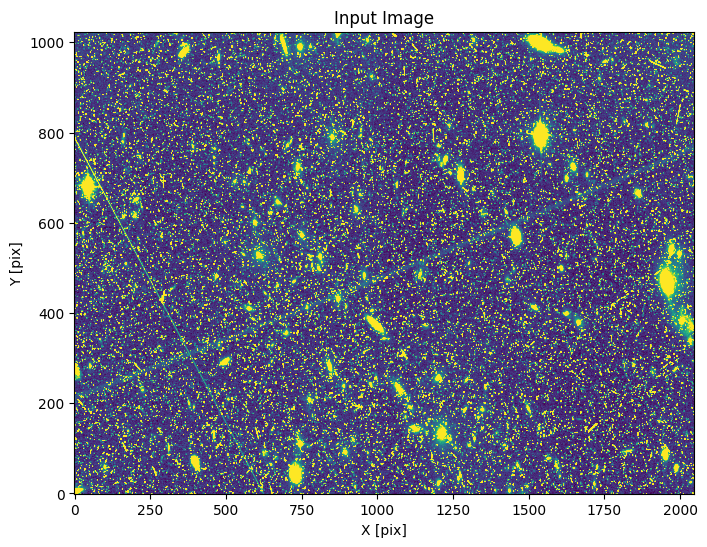

In [10]:
s.plot_image()

If you're having trouble seeing the trails, you can adjust the scale keyword (the min and max values to show given as multiples of the image standard deviation)

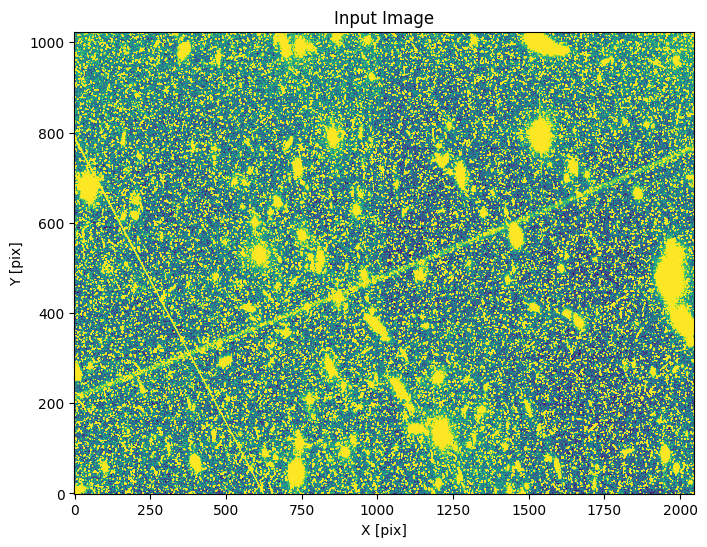

In [11]:
s.plot_image(scale=[-1, 1])

Next we run the Median Radon Transform. This step can take some time depending on the image size and number of processes being used. This tutorial assumes you can run 8 processes at the same time, but adjust as needed. If you're not sure how many processes you can run, you can see how many CPU cores are available and adjust based on that.

In [12]:
os.cpu_count()

4

In [13]:
s.processes = 8  # adjust this if necessary
s.run_mrt()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 4 processes


Now we will plot the MRT. You may be able to spot the signals from the satellite trails as two somewhat wide point-like sources.

<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

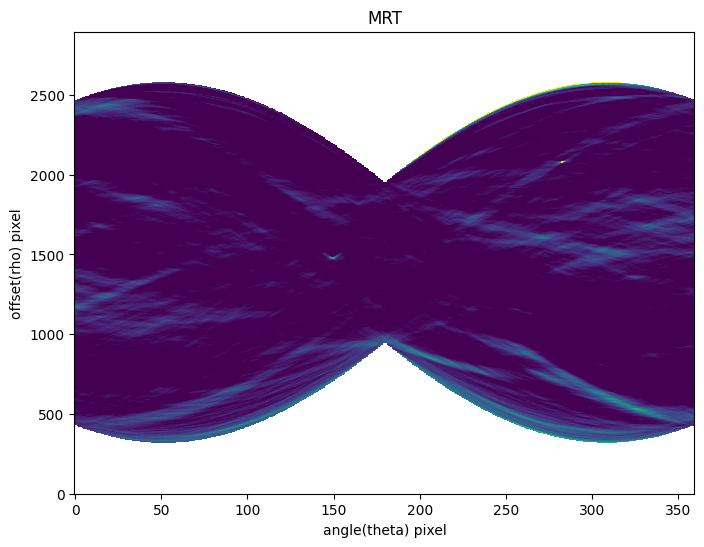

In [14]:
s.plot_mrt()

Note that the x axis in in pixels, not degrees or radians. The `theta` array ranges from 0 to 180 with a spacing of 0.5 degrees, hence 360 pixels.

We next run the source finder on the MRT. You can create your own detection kernels, or use the defaults provided (see [Example 6](#example6) for how to create detection kernels). Depending on the settings, this can pick up a lot more than the actual trails we're interested in. There are additional steps we'll take later to filter these false detections out. The ones we found and their location on the MRT are shown below.

The `threshold` in this case refers to the signal-to-noise ratio of a feature found in the MRT. The default is 5.

INFO:findsat_mrt:Detection threshold: 5


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width15.fits


INFO:findsat_mrt:{no} sources found using kernel: 2


INFO:findsat_mrt:2 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width7.fits


INFO:findsat_mrt:{no} sources found using kernel: 4


INFO:findsat_mrt:4 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width3.fits


INFO:findsat_mrt:{no} sources found using kernel: 8


INFO:findsat_mrt:8 sources found using kernel


INFO:findsat_mrt:Removing duplicate sources


INFO:findsat_mrt:8 final sources found


<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

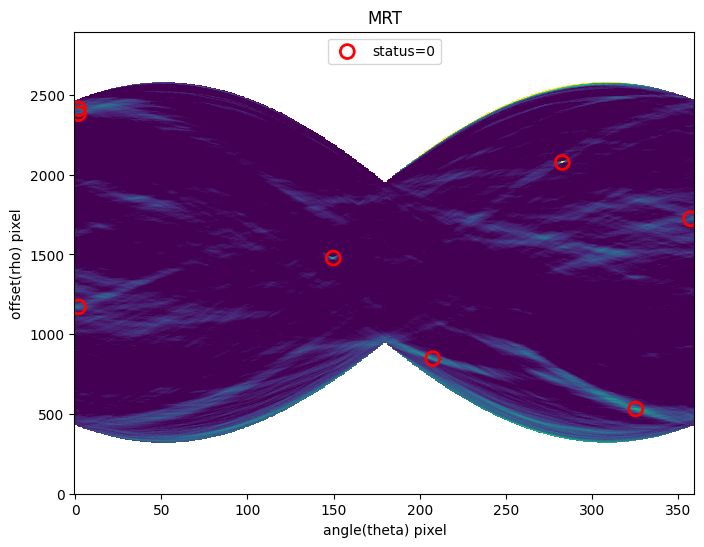

In [15]:
s.threshold = 5  # detection threshold
s.find_mrt_sources()  # finds the sources
s.plot_mrt(show_sources=True)  # overplots the sources on top of the MRT

We filter the sources further based on a reassessment of their S/N, width, and persistence. The default parameters (namely width) have been chosen for ACS data binned by 2 pixels in each direction. It's possible different defaults will be better for different imaging data.

In [16]:
# Parameters that affect how the filtering works
s.threshold = 5
s.max_width = 75
s.check_persistence = True
s.min_persistence = 0.5

# now filter
s.filter_sources()

# note: some extra columns have been added to the source list
s.source_list

INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True


INFO:findsat_mrt:Min persistence: 0.5


INFO:utils_findsat_mrt:amplitude of feature: 24.781228782083772
baseline noise: 1.1392404204749706
snr of feature = 20.752413570220774


INFO:utils_findsat_mrt:width of feature = 27.93697135868217


INFO:utils_findsat_mrt:breaking into 21.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.777939266096766
baseline noise: 5.266821168373301
snr of feature = 4.08426969704144


INFO:utils_findsat_mrt:width of feature = 26.912252404115833


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.08426969704144, 26.912252404115833, 255.94771205201673


INFO:utils_findsat_mrt:Checking persistence, step 2 of 21


INFO:utils_findsat_mrt:amplitude of feature: 36.86109099480041
baseline noise: 4.031873465370958
snr of feature = 8.142422576351603


INFO:utils_findsat_mrt:width of feature = 26.299791363903836


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.142422576351603, 26.299791363903836, 255.3153709824764


INFO:utils_findsat_mrt:Checking persistence, step 3 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.884373215737874
baseline noise: 4.432935911817287
snr of feature = 5.7414403930524545


INFO:utils_findsat_mrt:width of feature = 24.522434144873472


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.7414403930524545, 24.522434144873472, 253.71933453180375


INFO:utils_findsat_mrt:Checking persistence, step 4 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.338171095058804
baseline noise: 5.139947037197364
snr of feature = 5.875201405640844


INFO:utils_findsat_mrt:width of feature = 24.328122083921244


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.875201405640844, 24.328122083921244, 252.1528345263356


INFO:utils_findsat_mrt:Checking persistence, step 5 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.827924719714396
baseline noise: 4.373673374850432
snr of feature = 7.191723900950792


INFO:utils_findsat_mrt:width of feature = 31.80533203666792


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.191723900950792, 31.80533203666792, 250.32894672821345


INFO:utils_findsat_mrt:Checking persistence, step 6 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.98748795205496
baseline noise: 4.047251630718669
snr of feature = 6.162264814977087


INFO:utils_findsat_mrt:width of feature = 22.328341449863046


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.162264814977087, 22.328341449863046, 250.78695422770954


INFO:utils_findsat_mrt:Checking persistence, step 7 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.176049037358098
baseline noise: 5.473593475770235
snr of feature = 3.7822420779385055


INFO:utils_findsat_mrt:width of feature = 18.610593335348995


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7822420779385055, 18.610593335348995, 250.01554635050337


INFO:utils_findsat_mrt:Checking persistence, step 8 of 21


INFO:utils_findsat_mrt:amplitude of feature: 38.773673376342536
baseline noise: 4.532406342910618
snr of feature = 7.554765491622466


INFO:utils_findsat_mrt:width of feature = 24.568512312437377


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.554765491622466, 24.568512312437377, 249.70351180160577


INFO:utils_findsat_mrt:Checking persistence, step 9 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.60885136170824
baseline noise: 8.783011700036266
snr of feature = 2.3711501672696147


INFO:utils_findsat_mrt:width of feature = 20.19012908962668


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.3711501672696147, 20.19012908962668, 249.57377404180238


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 21


INFO:utils_findsat_mrt:amplitude of feature: 41.80623636545298
baseline noise: 4.939912133819193
snr of feature = 7.462951411472038


INFO:utils_findsat_mrt:width of feature = 42.53203134793276


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.462951411472038, 42.53203134793276, 249.78357415447687


INFO:utils_findsat_mrt:Checking persistence, step 11 of 21


INFO:utils_findsat_mrt:amplitude of feature: 27.730559231566154
baseline noise: 5.385939821448101
snr of feature = 4.148694592007217


INFO:utils_findsat_mrt:width of feature = 29.08177986641519


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.148694592007217, 29.08177986641519, 250.48055834836185


INFO:utils_findsat_mrt:Checking persistence, step 12 of 21


INFO:utils_findsat_mrt:amplitude of feature: 32.561900539500186
baseline noise: 4.5295217241865995
snr of feature = 6.188816506967426


INFO:utils_findsat_mrt:width of feature = 28.09886146195248


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.188816506967426, 28.09886146195248, 249.0269336127743


INFO:utils_findsat_mrt:Checking persistence, step 13 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.97240172562028
baseline noise: 3.8596124486331966
snr of feature = 5.988370486568414


INFO:utils_findsat_mrt:width of feature = 23.44420709235706


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.988370486568414, 23.44420709235706, 250.06034393794346


INFO:utils_findsat_mrt:Checking persistence, step 14 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.68602494941817
baseline noise: 5.694566385833712
snr of feature = 4.037437972587337


INFO:utils_findsat_mrt:width of feature = 21.804636480148332


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.037437972587337, 21.804636480148332, 251.089147339524


INFO:utils_findsat_mrt:Checking persistence, step 15 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.83959172421478
baseline noise: 4.547749129001824
snr of feature = 6.880731919810436


INFO:utils_findsat_mrt:width of feature = 27.597328312013047


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.880731919810436, 27.597328312013047, 251.16204416559495


INFO:utils_findsat_mrt:Checking persistence, step 16 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.653511720250755
baseline noise: 4.689231761741343
snr of feature = 5.323746239669532


INFO:utils_findsat_mrt:width of feature = 34.20544765839057


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.323746239669532, 34.20544765839057, 251.01088333237297


INFO:utils_findsat_mrt:Checking persistence, step 17 of 21


INFO:utils_findsat_mrt:amplitude of feature: 27.925070312484305
baseline noise: 6.539005857808222
snr of feature = 3.2705375893093898


INFO:utils_findsat_mrt:width of feature = 20.67192262702821


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2705375893093898, 20.67192262702821, 252.99250047723368


INFO:utils_findsat_mrt:Checking persistence, step 18 of 21


INFO:utils_findsat_mrt:amplitude of feature: 33.60054527635417
baseline noise: 4.936877710060228
snr of feature = 5.8060315141863725


INFO:utils_findsat_mrt:width of feature = 25.624363360386155


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.8060315141863725, 25.624363360386155, 254.44205498923287


INFO:utils_findsat_mrt:Checking persistence, step 19 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.422250393722546
baseline noise: 3.9568555503182568
snr of feature = 6.183039671851679


INFO:utils_findsat_mrt:width of feature = 24.644950933499302


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.183039671851679, 24.644950933499302, 255.1339854488413


INFO:utils_findsat_mrt:Checking persistence, step 20 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.481791025926363
baseline noise: 6.130826230606326
snr of feature = 3.6456692710909824


INFO:utils_findsat_mrt:width of feature = 27.528715120165543


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.6456692710909824, 27.528715120165543, 256.08658854547815


INFO:utils_findsat_mrt:Checking persistence, step 21 of 21


INFO:utils_findsat_mrt:amplitude of feature: 31.705863786725068
baseline noise: 5.038364135503358
snr of feature = 5.29288851182994


INFO:utils_findsat_mrt:width of feature = 29.3261044453607


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.29288851182994, 29.3261044453607, 257.26469437207624


INFO:utils_findsat_mrt:Number of sections analyzed: 21
Number of sections that passed: 20
persistance score: 0.9523809523809523


INFO:utils_findsat_mrt:amplitude of feature: 140.6325310562624
baseline noise: 1.6349383069861778
snr of feature = 85.0170261197821


INFO:utils_findsat_mrt:width of feature = 5.852792378744823


INFO:utils_findsat_mrt:breaking into 10.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 10


INFO:utils_findsat_mrt:amplitude of feature: 433.35799221899043
baseline noise: 5.146599100327714
snr of feature = 83.20278785487605


INFO:utils_findsat_mrt:width of feature = 3.9196903857742313


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 83.20278785487605, 3.9196903857742313, 252.12346347777913


INFO:utils_findsat_mrt:Checking persistence, step 2 of 10


INFO:utils_findsat_mrt:amplitude of feature: 382.87756197996185
baseline noise: 6.7085814104331645
snr of feature = 56.07280549424531


INFO:utils_findsat_mrt:width of feature = 3.963505073451529


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 56.07280549424531, 3.963505073451529, 251.94556991306192


INFO:utils_findsat_mrt:Checking persistence, step 3 of 10


INFO:utils_findsat_mrt:amplitude of feature: 294.4385404166353
baseline noise: 5.670862529053957
snr of feature = 50.92129749365571


INFO:utils_findsat_mrt:width of feature = 3.9409384384177315


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 50.92129749365571, 3.9409384384177315, 251.76604610986263


INFO:utils_findsat_mrt:Checking persistence, step 4 of 10


INFO:utils_findsat_mrt:amplitude of feature: 209.99469753845483
baseline noise: 4.176245406945087
snr of feature = 49.28313163523247


INFO:utils_findsat_mrt:width of feature = 4.040644251356582


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 49.28313163523247, 4.040644251356582, 251.53667204446884


INFO:utils_findsat_mrt:Checking persistence, step 5 of 10


INFO:utils_findsat_mrt:amplitude of feature: 231.35124981013368
baseline noise: 4.221398902077043
snr of feature = 53.80440374784353


INFO:utils_findsat_mrt:width of feature = 4.0823911470658345


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 53.80440374784353, 4.0823911470658345, 251.24883549025523


INFO:utils_findsat_mrt:Checking persistence, step 6 of 10


INFO:utils_findsat_mrt:amplitude of feature: 209.89648284455865
baseline noise: 4.617413792211489
snr of feature = 44.45758562912545


INFO:utils_findsat_mrt:width of feature = 4.000327266785064


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 44.45758562912545, 4.000327266785064, 250.96659870829532


INFO:utils_findsat_mrt:Checking persistence, step 7 of 10


INFO:utils_findsat_mrt:amplitude of feature: 155.9266668195209
baseline noise: 5.862285931168757
snr of feature = 25.598270478498133


INFO:utils_findsat_mrt:width of feature = 4.121455894765404


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 25.598270478498133, 4.121455894765404, 250.65087811069012


INFO:utils_findsat_mrt:Checking persistence, step 8 of 10


INFO:utils_findsat_mrt:amplitude of feature: 157.05851550614148
baseline noise: 4.338156976834571
snr of feature = 35.20397241151531


INFO:utils_findsat_mrt:width of feature = 3.9598865146421076


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 35.20397241151531, 3.9598865146421076, 250.3121777727571


INFO:utils_findsat_mrt:Checking persistence, step 9 of 10


INFO:utils_findsat_mrt:amplitude of feature: 170.627447731048
baseline noise: 5.29262014663969
snr of feature = 31.238748106527197


INFO:utils_findsat_mrt:width of feature = 4.038551384055381


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 31.238748106527197, 4.038551384055381, 249.89181733506314


INFO:utils_findsat_mrt:Checking persistence, step 10 of 10


INFO:utils_findsat_mrt:amplitude of feature: 158.2991830792352
baseline noise: 7.87008105556901
snr of feature = 19.11404736006116


INFO:utils_findsat_mrt:width of feature = 3.7413829072455655


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 19.11404736006116, 3.7413829072455655, 249.45429170495117


INFO:utils_findsat_mrt:Number of sections analyzed: 10
Number of sections that passed: 10
persistance score: 1.0


INFO:utils_findsat_mrt:amplitude of feature: 9.516165693052654
baseline noise: 1.6769988058063947
snr of feature = 4.674521448735767


INFO:utils_findsat_mrt:width of feature = 77.80569657005722


INFO:utils_findsat_mrt:amplitude of feature: 8.662488481692705
baseline noise: 1.310166879396368
snr of feature = 5.6117443647207494


INFO:utils_findsat_mrt:width of feature = 153.5992941626944


INFO:utils_findsat_mrt:amplitude of feature: 23.16941167211695
baseline noise: 2.171206884893149
snr of feature = 9.671213247031123


INFO:utils_findsat_mrt:width of feature = 183.82199492799182


INFO:utils_findsat_mrt:amplitude of feature: 15.82572897769589
baseline noise: 1.6913642253460386
snr of feature = 8.356783560003512


INFO:utils_findsat_mrt:width of feature = 79.72093191943699


INFO:utils_findsat_mrt:amplitude of feature: 6.643006846505017
baseline noise: 1.6379596760811124
snr of feature = 3.0556595766744947


INFO:utils_findsat_mrt:width of feature = 127.90245994123578


INFO:utils_findsat_mrt:amplitude of feature: 7.968046280696431
baseline noise: 1.7889030634523286
snr of feature = 3.4541520686533085


INFO:utils_findsat_mrt:width of feature = 108.52591914378449


<QTable length=8>
  id      xcentroid      ...        snr            persistence    
int64      float64       ...      float64            float64      
----- ------------------ ... ------------------ ------------------
    1  149.8247532736418 ... 20.752413570220774 0.9523809523809523
    2  282.7960369376785 ...   85.0170261197821                1.0
    3  1.892655399843995 ...  4.674521448735767                0.0
    6  1.890194693540622 ... 5.6117443647207494                0.0
    7 325.42673789644846 ...  9.671213247031123                0.0
    8 207.55564520164214 ...  8.356783560003512                0.0
   11 357.19878476679287 ... 3.0556595766744947                0.0
   13 1.9268017945417673 ... 3.4541520686533085                0.0

Several columns have been added to the source list that characterize the observed streak. Also, the `status` array has values of 0, 1, and 2 now (it just had 0 before). Those with `status=2` are sources that passed all filtering stages (checks for SNR and width, then persistence). Those with `status=1` are sources that passed the first filtering stage (checks for SNR and width), but not the second (persistence check). And `status=0` are sources that did not pass the filtering steps.

The `plot_mrt` command will overplot the different statuses

<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

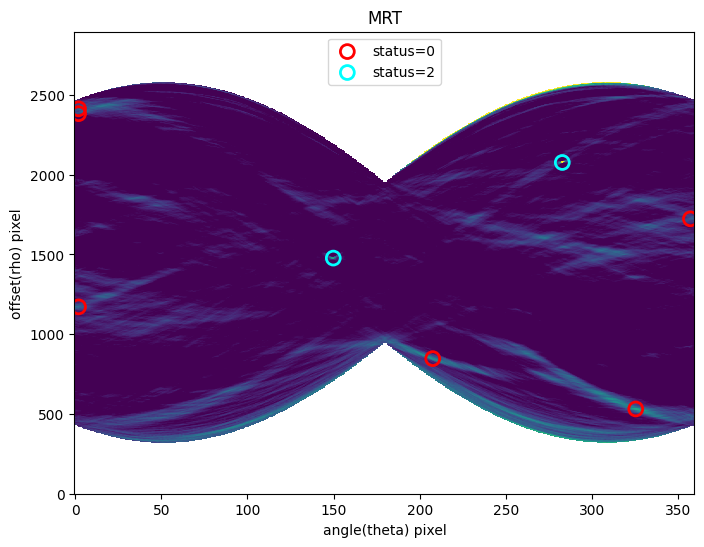

In [17]:
s.plot_mrt(show_sources=True)

Now we can make the mask itself. By default it only uses sources in the MRT with `status=2`. We make two types of masks, one a simple boolean mask, and one a segementation mask where pixels corresponding to each streak are assigned the ID number. We create these below.

In [18]:
# make the mask
s.mask_include_status = [2]
s.make_mask()

<Axes: title={'center': 'Segmentation Mask'}>

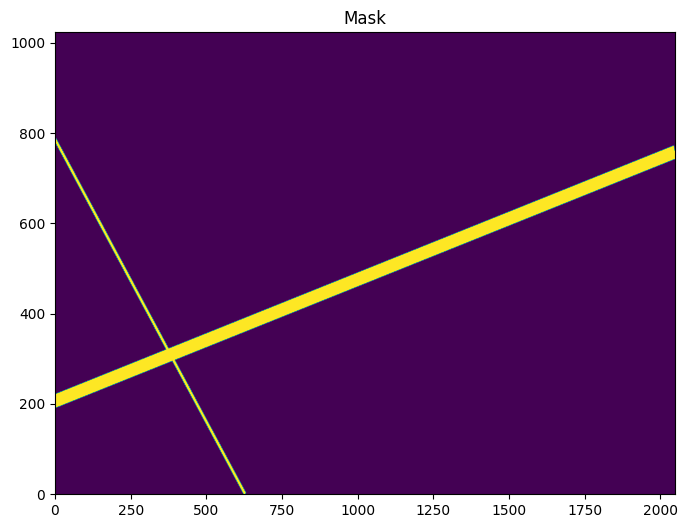

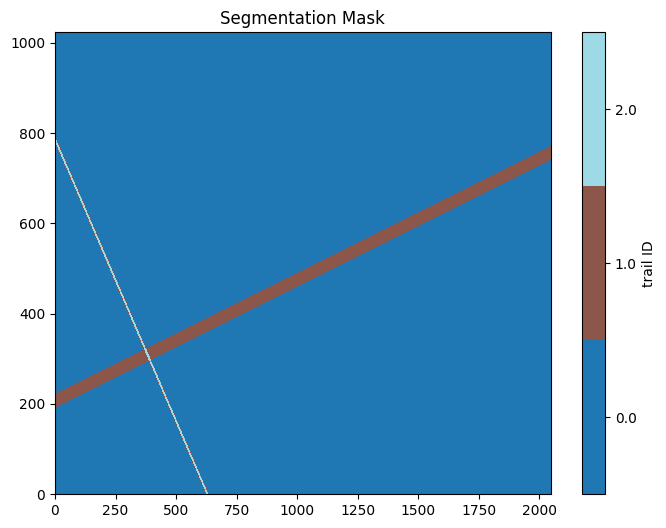

In [19]:
# plot the mask and segmentation map
s.plot_mask()
s.plot_segment()

We can also overlay the mask on top of the image to make sure it makes sense.

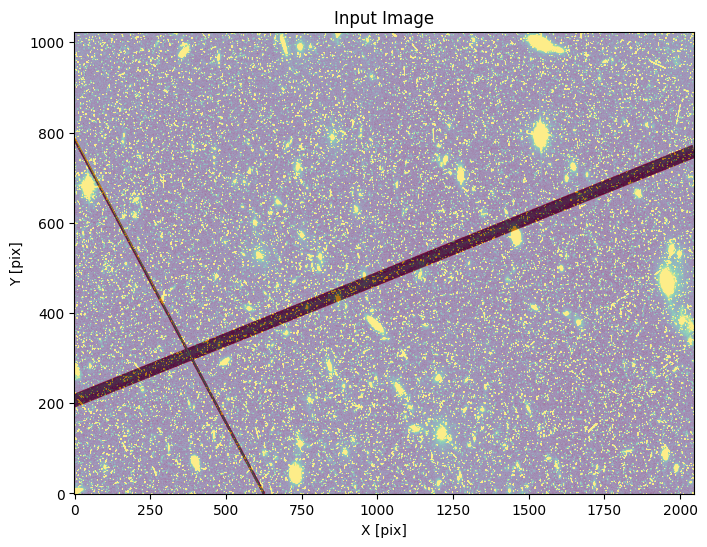

In [20]:
s.plot_image(overlay_mask=True)

We can save the results now. You have the optional of saving the catalog, mask, MRT, and a diagnostic image that shows the results. In this example we'll just save everything.

In [21]:
# define what to save
s.save_mask = True
s.save_mrt = True
s.save_catalog = True
s.save_diagnostic = True

s.save_output()

INFO:findsat_mrt:Wrote MRT to ./example1_mrt.fits


INFO:findsat_mrt:Wrote mask to ./example1_mask.fits


INFO:findsat_mrt:Wrote diagnostic plot to ./example1_diagnostic.png


INFO:findsat_mrt:wrote catalog ./example1_catalog.fits


Keep in mind that the mask we have created is applicable to the rebinned image. To convert it into a mask that can be applied to the original unbinned image, we need to resample it using the `block_replicate` function. The rescaled mask is plotted below. Note the difference in image size, but the mask pattern remains the same.

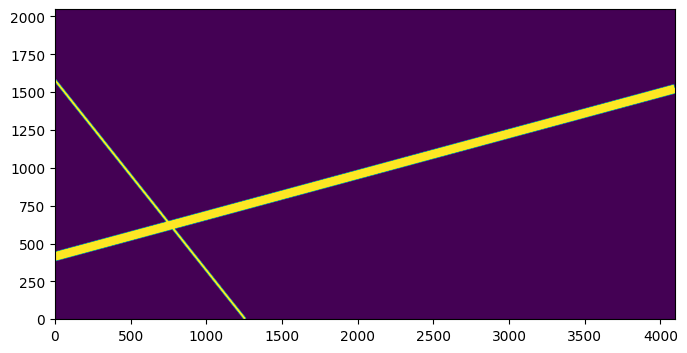

In [22]:
full_mask = block_replicate(s.mask, binsize, conserve_sum=False)
fig, ax = plt.subplots()
ax.imshow(full_mask, origin='lower')

## <a id="example2"></a>
## Example 2: Quick run of TrailFinder on an flc image

Example 1 thoroughly demonstrated the steps to read in an FLC file, pre-process it, and identify trails. This example demonstrates how one can run many of the steps simultaneously once a file is read in an all parameters set. 

First, we read in and preprocess the data file exactly as before.

In [23]:
# Read in the image files and header information
image_file = 'jc8m32j5q_flc.fits'
ext = 4  # ACS image data are in extensions 1 or 4, we'll just use 1 for now
with fits.open(image_file) as h:
    image = h[ext].data  # image data
    dq = h[ext+2].data  # data quality bitmasks
    
    header = h[0].header  # primary header
    image_header = h[1].header  # image header

# make a mask for bad pixels.
mask = bitmask.bitfield_to_boolean_mask(dq, ignore_flags=[4096, 8192, 16384])
image[mask] = np.nan

# Subtract the background from the image.
image = image - np.nanmedian(image)

# Rebin the image to speed up calculation
image_rebin = block_reduce(image, 2, func=np.nansum)
print(image)

[[ 5.3688492e+01  7.7842072e+01  8.2069962e+01 ... -3.5500183e+00
   6.0038452e+00  2.1702469e+01]
 [ 1.1057211e+02  1.1134854e+02  8.5704437e+01 ...  1.4351349e+01
  -6.9071655e+00  2.6282501e+00]
 [ 1.2605432e+02  8.3174591e+01  1.2411203e+02 ...  5.4317114e+02
   1.4528281e+03  1.2523743e+01]
 ...
 [-7.8663788e+00  1.1875504e+01 -1.3893051e+01 ...  3.0214722e+01
   9.3101196e+00 -1.3999176e+01]
 [-8.7981873e+00 -1.8275146e+00  2.6314880e+01 ...  1.9167786e+01
  -9.4055176e-02 -6.7887421e+00]
 [           nan            nan            nan ...            nan
             nan            nan]]


And initialize trail finder as before

In [24]:
s2 = TrailFinder(image=image_rebin,
                 header=header,
                 image_header=image_header,
                 save_image_header_keys=['ROOTNAME', 'CCDCHIP', 'CRPIX1', 'CRPIX2', 'CRVAL1', 'CRVAL2',
                                         'ORIENTAT', 'RA_APER', 'DEC_APER', 'PA_APER'],
                 processes=8,
                 plot=False,
                 threshold=5,
                 max_width=75,  
                 check_persistence=True,
                 min_persistence=0.5,
                 output_root='example2')

If you're feeling ok about the setup, run all the subsequent steps together with the `run_all` command (this calculates the MRT, finds MRT sources, filters the sources, and saves the output)

In [25]:
s2.run_all()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 4 processes


INFO:findsat_mrt:Detection threshold: 5


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width15.fits


INFO:findsat_mrt:{no} sources found using kernel: 2


INFO:findsat_mrt:2 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width7.fits


INFO:findsat_mrt:{no} sources found using kernel: 4


INFO:findsat_mrt:4 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width3.fits


INFO:findsat_mrt:{no} sources found using kernel: 8


INFO:findsat_mrt:8 sources found using kernel


INFO:findsat_mrt:Removing duplicate sources


INFO:findsat_mrt:8 final sources found


INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True


INFO:findsat_mrt:Min persistence: 0.5


INFO:utils_findsat_mrt:amplitude of feature: 24.781228782083772
baseline noise: 1.1392404204749706
snr of feature = 20.752413570220774


INFO:utils_findsat_mrt:width of feature = 27.93697135868217


INFO:utils_findsat_mrt:breaking into 21.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.777939266096766
baseline noise: 5.266821168373301
snr of feature = 4.08426969704144


INFO:utils_findsat_mrt:width of feature = 26.912252404115833


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.08426969704144, 26.912252404115833, 255.94771205201673


INFO:utils_findsat_mrt:Checking persistence, step 2 of 21


INFO:utils_findsat_mrt:amplitude of feature: 36.86109099480041
baseline noise: 4.031873465370958
snr of feature = 8.142422576351603


INFO:utils_findsat_mrt:width of feature = 26.299791363903836


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.142422576351603, 26.299791363903836, 255.3153709824764


INFO:utils_findsat_mrt:Checking persistence, step 3 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.884373215737874
baseline noise: 4.432935911817287
snr of feature = 5.7414403930524545


INFO:utils_findsat_mrt:width of feature = 24.522434144873472


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.7414403930524545, 24.522434144873472, 253.71933453180375


INFO:utils_findsat_mrt:Checking persistence, step 4 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.338171095058804
baseline noise: 5.139947037197364
snr of feature = 5.875201405640844


INFO:utils_findsat_mrt:width of feature = 24.328122083921244


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.875201405640844, 24.328122083921244, 252.1528345263356


INFO:utils_findsat_mrt:Checking persistence, step 5 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.827924719714396
baseline noise: 4.373673374850432
snr of feature = 7.191723900950792


INFO:utils_findsat_mrt:width of feature = 31.80533203666792


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.191723900950792, 31.80533203666792, 250.32894672821345


INFO:utils_findsat_mrt:Checking persistence, step 6 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.98748795205496
baseline noise: 4.047251630718669
snr of feature = 6.162264814977087


INFO:utils_findsat_mrt:width of feature = 22.328341449863046


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.162264814977087, 22.328341449863046, 250.78695422770954


INFO:utils_findsat_mrt:Checking persistence, step 7 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.176049037358098
baseline noise: 5.473593475770235
snr of feature = 3.7822420779385055


INFO:utils_findsat_mrt:width of feature = 18.610593335348995


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7822420779385055, 18.610593335348995, 250.01554635050337


INFO:utils_findsat_mrt:Checking persistence, step 8 of 21


INFO:utils_findsat_mrt:amplitude of feature: 38.773673376342536
baseline noise: 4.532406342910618
snr of feature = 7.554765491622466


INFO:utils_findsat_mrt:width of feature = 24.568512312437377


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.554765491622466, 24.568512312437377, 249.70351180160577


INFO:utils_findsat_mrt:Checking persistence, step 9 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.60885136170824
baseline noise: 8.783011700036266
snr of feature = 2.3711501672696147


INFO:utils_findsat_mrt:width of feature = 20.19012908962668


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.3711501672696147, 20.19012908962668, 249.57377404180238


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 21


INFO:utils_findsat_mrt:amplitude of feature: 41.80623636545298
baseline noise: 4.939912133819193
snr of feature = 7.462951411472038


INFO:utils_findsat_mrt:width of feature = 42.53203134793276


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.462951411472038, 42.53203134793276, 249.78357415447687


INFO:utils_findsat_mrt:Checking persistence, step 11 of 21


INFO:utils_findsat_mrt:amplitude of feature: 27.730559231566154
baseline noise: 5.385939821448101
snr of feature = 4.148694592007217


INFO:utils_findsat_mrt:width of feature = 29.08177986641519


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.148694592007217, 29.08177986641519, 250.48055834836185


INFO:utils_findsat_mrt:Checking persistence, step 12 of 21


INFO:utils_findsat_mrt:amplitude of feature: 32.561900539500186
baseline noise: 4.5295217241865995
snr of feature = 6.188816506967426


INFO:utils_findsat_mrt:width of feature = 28.09886146195248


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.188816506967426, 28.09886146195248, 249.0269336127743


INFO:utils_findsat_mrt:Checking persistence, step 13 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.97240172562028
baseline noise: 3.8596124486331966
snr of feature = 5.988370486568414


INFO:utils_findsat_mrt:width of feature = 23.44420709235706


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.988370486568414, 23.44420709235706, 250.06034393794346


INFO:utils_findsat_mrt:Checking persistence, step 14 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.68602494941817
baseline noise: 5.694566385833712
snr of feature = 4.037437972587337


INFO:utils_findsat_mrt:width of feature = 21.804636480148332


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.037437972587337, 21.804636480148332, 251.089147339524


INFO:utils_findsat_mrt:Checking persistence, step 15 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.83959172421478
baseline noise: 4.547749129001824
snr of feature = 6.880731919810436


INFO:utils_findsat_mrt:width of feature = 27.597328312013047


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.880731919810436, 27.597328312013047, 251.16204416559495


INFO:utils_findsat_mrt:Checking persistence, step 16 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.653511720250755
baseline noise: 4.689231761741343
snr of feature = 5.323746239669532


INFO:utils_findsat_mrt:width of feature = 34.20544765839057


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.323746239669532, 34.20544765839057, 251.01088333237297


INFO:utils_findsat_mrt:Checking persistence, step 17 of 21


INFO:utils_findsat_mrt:amplitude of feature: 27.925070312484305
baseline noise: 6.539005857808222
snr of feature = 3.2705375893093898


INFO:utils_findsat_mrt:width of feature = 20.67192262702821


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2705375893093898, 20.67192262702821, 252.99250047723368


INFO:utils_findsat_mrt:Checking persistence, step 18 of 21


INFO:utils_findsat_mrt:amplitude of feature: 33.60054527635417
baseline noise: 4.936877710060228
snr of feature = 5.8060315141863725


INFO:utils_findsat_mrt:width of feature = 25.624363360386155


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.8060315141863725, 25.624363360386155, 254.44205498923287


INFO:utils_findsat_mrt:Checking persistence, step 19 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.422250393722546
baseline noise: 3.9568555503182568
snr of feature = 6.183039671851679


INFO:utils_findsat_mrt:width of feature = 24.644950933499302


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.183039671851679, 24.644950933499302, 255.1339854488413


INFO:utils_findsat_mrt:Checking persistence, step 20 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.481791025926363
baseline noise: 6.130826230606326
snr of feature = 3.6456692710909824


INFO:utils_findsat_mrt:width of feature = 27.528715120165543


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.6456692710909824, 27.528715120165543, 256.08658854547815


INFO:utils_findsat_mrt:Checking persistence, step 21 of 21


INFO:utils_findsat_mrt:amplitude of feature: 31.705863786725068
baseline noise: 5.038364135503358
snr of feature = 5.29288851182994


INFO:utils_findsat_mrt:width of feature = 29.3261044453607


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.29288851182994, 29.3261044453607, 257.26469437207624


INFO:utils_findsat_mrt:Number of sections analyzed: 21
Number of sections that passed: 20
persistance score: 0.9523809523809523


INFO:utils_findsat_mrt:amplitude of feature: 140.6325310562624
baseline noise: 1.6349383069861778
snr of feature = 85.0170261197821


INFO:utils_findsat_mrt:width of feature = 5.852792378744823


INFO:utils_findsat_mrt:breaking into 10.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 10


INFO:utils_findsat_mrt:amplitude of feature: 433.35799221899043
baseline noise: 5.146599100327714
snr of feature = 83.20278785487605


INFO:utils_findsat_mrt:width of feature = 3.9196903857742313


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 83.20278785487605, 3.9196903857742313, 252.12346347777913


INFO:utils_findsat_mrt:Checking persistence, step 2 of 10


INFO:utils_findsat_mrt:amplitude of feature: 382.87756197996185
baseline noise: 6.7085814104331645
snr of feature = 56.07280549424531


INFO:utils_findsat_mrt:width of feature = 3.963505073451529


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 56.07280549424531, 3.963505073451529, 251.94556991306192


INFO:utils_findsat_mrt:Checking persistence, step 3 of 10


INFO:utils_findsat_mrt:amplitude of feature: 294.4385404166353
baseline noise: 5.670862529053957
snr of feature = 50.92129749365571


INFO:utils_findsat_mrt:width of feature = 3.9409384384177315


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 50.92129749365571, 3.9409384384177315, 251.76604610986263


INFO:utils_findsat_mrt:Checking persistence, step 4 of 10


INFO:utils_findsat_mrt:amplitude of feature: 209.99469753845483
baseline noise: 4.176245406945087
snr of feature = 49.28313163523247


INFO:utils_findsat_mrt:width of feature = 4.040644251356582


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 49.28313163523247, 4.040644251356582, 251.53667204446884


INFO:utils_findsat_mrt:Checking persistence, step 5 of 10


INFO:utils_findsat_mrt:amplitude of feature: 231.35124981013368
baseline noise: 4.221398902077043
snr of feature = 53.80440374784353


INFO:utils_findsat_mrt:width of feature = 4.0823911470658345


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 53.80440374784353, 4.0823911470658345, 251.24883549025523


INFO:utils_findsat_mrt:Checking persistence, step 6 of 10


INFO:utils_findsat_mrt:amplitude of feature: 209.89648284455865
baseline noise: 4.617413792211489
snr of feature = 44.45758562912545


INFO:utils_findsat_mrt:width of feature = 4.000327266785064


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 44.45758562912545, 4.000327266785064, 250.96659870829532


INFO:utils_findsat_mrt:Checking persistence, step 7 of 10


INFO:utils_findsat_mrt:amplitude of feature: 155.9266668195209
baseline noise: 5.862285931168757
snr of feature = 25.598270478498133


INFO:utils_findsat_mrt:width of feature = 4.121455894765404


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 25.598270478498133, 4.121455894765404, 250.65087811069012


INFO:utils_findsat_mrt:Checking persistence, step 8 of 10


INFO:utils_findsat_mrt:amplitude of feature: 157.05851550614148
baseline noise: 4.338156976834571
snr of feature = 35.20397241151531


INFO:utils_findsat_mrt:width of feature = 3.9598865146421076


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 35.20397241151531, 3.9598865146421076, 250.3121777727571


INFO:utils_findsat_mrt:Checking persistence, step 9 of 10


INFO:utils_findsat_mrt:amplitude of feature: 170.627447731048
baseline noise: 5.29262014663969
snr of feature = 31.238748106527197


INFO:utils_findsat_mrt:width of feature = 4.038551384055381


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 31.238748106527197, 4.038551384055381, 249.89181733506314


INFO:utils_findsat_mrt:Checking persistence, step 10 of 10


INFO:utils_findsat_mrt:amplitude of feature: 158.2991830792352
baseline noise: 7.87008105556901
snr of feature = 19.11404736006116


INFO:utils_findsat_mrt:width of feature = 3.7413829072455655


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 19.11404736006116, 3.7413829072455655, 249.45429170495117


INFO:utils_findsat_mrt:Number of sections analyzed: 10
Number of sections that passed: 10
persistance score: 1.0


INFO:utils_findsat_mrt:amplitude of feature: 9.516165693052654
baseline noise: 1.6769988058063947
snr of feature = 4.674521448735767


INFO:utils_findsat_mrt:width of feature = 77.80569657005722


INFO:utils_findsat_mrt:amplitude of feature: 8.662488481692705
baseline noise: 1.310166879396368
snr of feature = 5.6117443647207494


INFO:utils_findsat_mrt:width of feature = 153.5992941626944


INFO:utils_findsat_mrt:amplitude of feature: 23.16941167211695
baseline noise: 2.171206884893149
snr of feature = 9.671213247031123


INFO:utils_findsat_mrt:width of feature = 183.82199492799182


INFO:utils_findsat_mrt:amplitude of feature: 15.82572897769589
baseline noise: 1.6913642253460386
snr of feature = 8.356783560003512


INFO:utils_findsat_mrt:width of feature = 79.72093191943699


INFO:utils_findsat_mrt:amplitude of feature: 6.643006846505017
baseline noise: 1.6379596760811124
snr of feature = 3.0556595766744947


INFO:utils_findsat_mrt:width of feature = 127.90245994123578


INFO:utils_findsat_mrt:amplitude of feature: 7.968046280696431
baseline noise: 1.7889030634523286
snr of feature = 3.4541520686533085


INFO:utils_findsat_mrt:width of feature = 108.52591914378449


INFO:findsat_mrt:Wrote diagnostic plot to ./example2_diagnostic.png


INFO:findsat_mrt:wrote catalog ./example2_catalog.fits


If we plot the mask, it should look identical to the one in the previous example.

<Axes: title={'center': 'Mask'}>

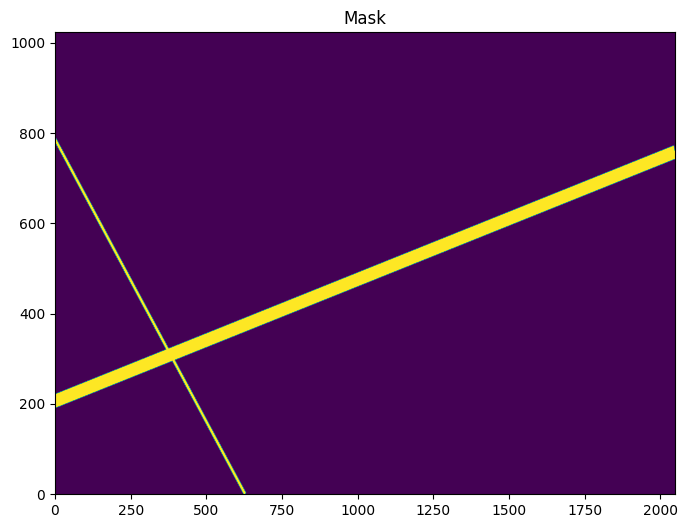

In [26]:
s2.plot_mask()

## <a id="example3"></a>
## Example 3: find trails in an FLC image using the WFC wrapper

The approaches shown in examples 1 and 2 can be useful for imaging data from any telescope, not just ACS/WFC data. However, for ACS/WFC data, we provide a convenience wrapper that performs even more of the steps all together, including reading the image and pre-processing it.

The `WfcWrapper` class has the same properties as the TrailFinder class, but with a few additional keywords. It also contains the additional routines that read the image, rebin, mask, and subtract the background. By default, these will be run automatically when WfcWrapper is initialized, although this can be turned off. In most cases, you probably will only need to adjust the `binsize` keyword. The specific value of `binsize` is up to the user. Larger values speed up the MRT calculation, but keep in mind that the parameters to filter out spurious trails (e.g., `max_width`) are tuned to WFC data binned 2x2. A user may want to start with a larger value for `binsize` and reduce it once they get a sense for the computation time.

In [27]:
w = WfcWrapper('jc8m32j5q_flc.fits', binsize=2, extension=4, processes=8, output_root='example3')

INFO:findsat_mrt:image type is flc


INFO:findsat_mrt:masking bad pixels


INFO:findsat_mrt:Subtracting median background


INFO:findsat_mrt:Rebinning the data by 2


We can plot the image to see that it looks like the one from the last example after preprocessing.

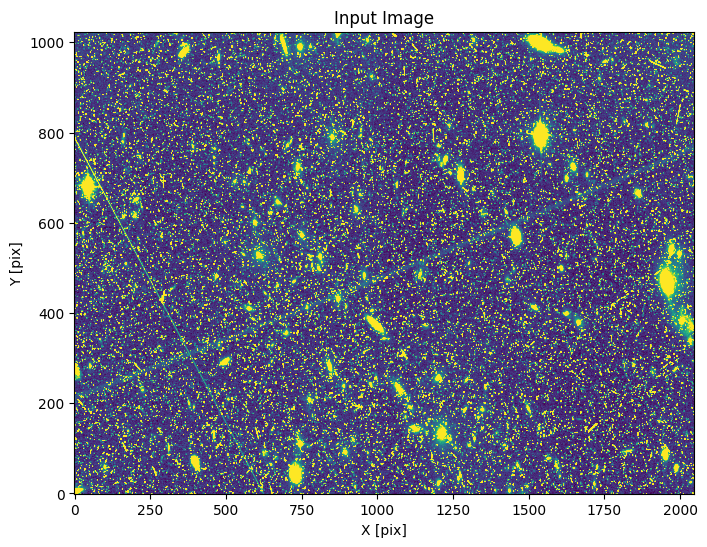

In [28]:
w.plot_image()

From here, everything is the same as the last example:

In [29]:
w.run_mrt()
w.find_mrt_sources()
w.filter_sources()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 4 processes


INFO:findsat_mrt:Detection threshold: 5


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width15.fits


INFO:findsat_mrt:{no} sources found using kernel: 2


INFO:findsat_mrt:2 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width7.fits


INFO:findsat_mrt:{no} sources found using kernel: 4


INFO:findsat_mrt:4 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width3.fits


INFO:findsat_mrt:{no} sources found using kernel: 8


INFO:findsat_mrt:8 sources found using kernel


INFO:findsat_mrt:Removing duplicate sources


INFO:findsat_mrt:8 final sources found


INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True


INFO:findsat_mrt:Min persistence: 0.5


INFO:utils_findsat_mrt:amplitude of feature: 24.781228782083772
baseline noise: 1.1392404204749706
snr of feature = 20.752413570220774


INFO:utils_findsat_mrt:width of feature = 27.93697135868217


INFO:utils_findsat_mrt:breaking into 21.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.777939266096766
baseline noise: 5.266821168373301
snr of feature = 4.08426969704144


INFO:utils_findsat_mrt:width of feature = 26.912252404115833


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.08426969704144, 26.912252404115833, 255.94771205201673


INFO:utils_findsat_mrt:Checking persistence, step 2 of 21


INFO:utils_findsat_mrt:amplitude of feature: 36.86109099480041
baseline noise: 4.031873465370958
snr of feature = 8.142422576351603


INFO:utils_findsat_mrt:width of feature = 26.299791363903836


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.142422576351603, 26.299791363903836, 255.3153709824764


INFO:utils_findsat_mrt:Checking persistence, step 3 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.884373215737874
baseline noise: 4.432935911817287
snr of feature = 5.7414403930524545


INFO:utils_findsat_mrt:width of feature = 24.522434144873472


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.7414403930524545, 24.522434144873472, 253.71933453180375


INFO:utils_findsat_mrt:Checking persistence, step 4 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.338171095058804
baseline noise: 5.139947037197364
snr of feature = 5.875201405640844


INFO:utils_findsat_mrt:width of feature = 24.328122083921244


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.875201405640844, 24.328122083921244, 252.1528345263356


INFO:utils_findsat_mrt:Checking persistence, step 5 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.827924719714396
baseline noise: 4.373673374850432
snr of feature = 7.191723900950792


INFO:utils_findsat_mrt:width of feature = 31.80533203666792


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.191723900950792, 31.80533203666792, 250.32894672821345


INFO:utils_findsat_mrt:Checking persistence, step 6 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.98748795205496
baseline noise: 4.047251630718669
snr of feature = 6.162264814977087


INFO:utils_findsat_mrt:width of feature = 22.328341449863046


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.162264814977087, 22.328341449863046, 250.78695422770954


INFO:utils_findsat_mrt:Checking persistence, step 7 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.176049037358098
baseline noise: 5.473593475770235
snr of feature = 3.7822420779385055


INFO:utils_findsat_mrt:width of feature = 18.610593335348995


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7822420779385055, 18.610593335348995, 250.01554635050337


INFO:utils_findsat_mrt:Checking persistence, step 8 of 21


INFO:utils_findsat_mrt:amplitude of feature: 38.773673376342536
baseline noise: 4.532406342910618
snr of feature = 7.554765491622466


INFO:utils_findsat_mrt:width of feature = 24.568512312437377


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.554765491622466, 24.568512312437377, 249.70351180160577


INFO:utils_findsat_mrt:Checking persistence, step 9 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.60885136170824
baseline noise: 8.783011700036266
snr of feature = 2.3711501672696147


INFO:utils_findsat_mrt:width of feature = 20.19012908962668


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.3711501672696147, 20.19012908962668, 249.57377404180238


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 21


INFO:utils_findsat_mrt:amplitude of feature: 41.80623636545298
baseline noise: 4.939912133819193
snr of feature = 7.462951411472038


INFO:utils_findsat_mrt:width of feature = 42.53203134793276


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.462951411472038, 42.53203134793276, 249.78357415447687


INFO:utils_findsat_mrt:Checking persistence, step 11 of 21


INFO:utils_findsat_mrt:amplitude of feature: 27.730559231566154
baseline noise: 5.385939821448101
snr of feature = 4.148694592007217


INFO:utils_findsat_mrt:width of feature = 29.08177986641519


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.148694592007217, 29.08177986641519, 250.48055834836185


INFO:utils_findsat_mrt:Checking persistence, step 12 of 21


INFO:utils_findsat_mrt:amplitude of feature: 32.561900539500186
baseline noise: 4.5295217241865995
snr of feature = 6.188816506967426


INFO:utils_findsat_mrt:width of feature = 28.09886146195248


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.188816506967426, 28.09886146195248, 249.0269336127743


INFO:utils_findsat_mrt:Checking persistence, step 13 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.97240172562028
baseline noise: 3.8596124486331966
snr of feature = 5.988370486568414


INFO:utils_findsat_mrt:width of feature = 23.44420709235706


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.988370486568414, 23.44420709235706, 250.06034393794346


INFO:utils_findsat_mrt:Checking persistence, step 14 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.68602494941817
baseline noise: 5.694566385833712
snr of feature = 4.037437972587337


INFO:utils_findsat_mrt:width of feature = 21.804636480148332


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.037437972587337, 21.804636480148332, 251.089147339524


INFO:utils_findsat_mrt:Checking persistence, step 15 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.83959172421478
baseline noise: 4.547749129001824
snr of feature = 6.880731919810436


INFO:utils_findsat_mrt:width of feature = 27.597328312013047


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.880731919810436, 27.597328312013047, 251.16204416559495


INFO:utils_findsat_mrt:Checking persistence, step 16 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.653511720250755
baseline noise: 4.689231761741343
snr of feature = 5.323746239669532


INFO:utils_findsat_mrt:width of feature = 34.20544765839057


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.323746239669532, 34.20544765839057, 251.01088333237297


INFO:utils_findsat_mrt:Checking persistence, step 17 of 21


INFO:utils_findsat_mrt:amplitude of feature: 27.925070312484305
baseline noise: 6.539005857808222
snr of feature = 3.2705375893093898


INFO:utils_findsat_mrt:width of feature = 20.67192262702821


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2705375893093898, 20.67192262702821, 252.99250047723368


INFO:utils_findsat_mrt:Checking persistence, step 18 of 21


INFO:utils_findsat_mrt:amplitude of feature: 33.60054527635417
baseline noise: 4.936877710060228
snr of feature = 5.8060315141863725


INFO:utils_findsat_mrt:width of feature = 25.624363360386155


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.8060315141863725, 25.624363360386155, 254.44205498923287


INFO:utils_findsat_mrt:Checking persistence, step 19 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.422250393722546
baseline noise: 3.9568555503182568
snr of feature = 6.183039671851679


INFO:utils_findsat_mrt:width of feature = 24.644950933499302


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.183039671851679, 24.644950933499302, 255.1339854488413


INFO:utils_findsat_mrt:Checking persistence, step 20 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.481791025926363
baseline noise: 6.130826230606326
snr of feature = 3.6456692710909824


INFO:utils_findsat_mrt:width of feature = 27.528715120165543


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.6456692710909824, 27.528715120165543, 256.08658854547815


INFO:utils_findsat_mrt:Checking persistence, step 21 of 21


INFO:utils_findsat_mrt:amplitude of feature: 31.705863786725068
baseline noise: 5.038364135503358
snr of feature = 5.29288851182994


INFO:utils_findsat_mrt:width of feature = 29.3261044453607


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.29288851182994, 29.3261044453607, 257.26469437207624


INFO:utils_findsat_mrt:Number of sections analyzed: 21
Number of sections that passed: 20
persistance score: 0.9523809523809523


INFO:utils_findsat_mrt:amplitude of feature: 140.6325310562624
baseline noise: 1.6349383069861778
snr of feature = 85.0170261197821


INFO:utils_findsat_mrt:width of feature = 5.852792378744823


INFO:utils_findsat_mrt:breaking into 10.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 10


INFO:utils_findsat_mrt:amplitude of feature: 433.35799221899043
baseline noise: 5.146599100327714
snr of feature = 83.20278785487605


INFO:utils_findsat_mrt:width of feature = 3.9196903857742313


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 83.20278785487605, 3.9196903857742313, 252.12346347777913


INFO:utils_findsat_mrt:Checking persistence, step 2 of 10


INFO:utils_findsat_mrt:amplitude of feature: 382.87756197996185
baseline noise: 6.7085814104331645
snr of feature = 56.07280549424531


INFO:utils_findsat_mrt:width of feature = 3.963505073451529


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 56.07280549424531, 3.963505073451529, 251.94556991306192


INFO:utils_findsat_mrt:Checking persistence, step 3 of 10


INFO:utils_findsat_mrt:amplitude of feature: 294.4385404166353
baseline noise: 5.670862529053957
snr of feature = 50.92129749365571


INFO:utils_findsat_mrt:width of feature = 3.9409384384177315


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 50.92129749365571, 3.9409384384177315, 251.76604610986263


INFO:utils_findsat_mrt:Checking persistence, step 4 of 10


INFO:utils_findsat_mrt:amplitude of feature: 209.99469753845483
baseline noise: 4.176245406945087
snr of feature = 49.28313163523247


INFO:utils_findsat_mrt:width of feature = 4.040644251356582


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 49.28313163523247, 4.040644251356582, 251.53667204446884


INFO:utils_findsat_mrt:Checking persistence, step 5 of 10


INFO:utils_findsat_mrt:amplitude of feature: 231.35124981013368
baseline noise: 4.221398902077043
snr of feature = 53.80440374784353


INFO:utils_findsat_mrt:width of feature = 4.0823911470658345


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 53.80440374784353, 4.0823911470658345, 251.24883549025523


INFO:utils_findsat_mrt:Checking persistence, step 6 of 10


INFO:utils_findsat_mrt:amplitude of feature: 209.89648284455865
baseline noise: 4.617413792211489
snr of feature = 44.45758562912545


INFO:utils_findsat_mrt:width of feature = 4.000327266785064


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 44.45758562912545, 4.000327266785064, 250.96659870829532


INFO:utils_findsat_mrt:Checking persistence, step 7 of 10


INFO:utils_findsat_mrt:amplitude of feature: 155.9266668195209
baseline noise: 5.862285931168757
snr of feature = 25.598270478498133


INFO:utils_findsat_mrt:width of feature = 4.121455894765404


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 25.598270478498133, 4.121455894765404, 250.65087811069012


INFO:utils_findsat_mrt:Checking persistence, step 8 of 10


INFO:utils_findsat_mrt:amplitude of feature: 157.05851550614148
baseline noise: 4.338156976834571
snr of feature = 35.20397241151531


INFO:utils_findsat_mrt:width of feature = 3.9598865146421076


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 35.20397241151531, 3.9598865146421076, 250.3121777727571


INFO:utils_findsat_mrt:Checking persistence, step 9 of 10


INFO:utils_findsat_mrt:amplitude of feature: 170.627447731048
baseline noise: 5.29262014663969
snr of feature = 31.238748106527197


INFO:utils_findsat_mrt:width of feature = 4.038551384055381


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 31.238748106527197, 4.038551384055381, 249.89181733506314


INFO:utils_findsat_mrt:Checking persistence, step 10 of 10


INFO:utils_findsat_mrt:amplitude of feature: 158.2991830792352
baseline noise: 7.87008105556901
snr of feature = 19.11404736006116


INFO:utils_findsat_mrt:width of feature = 3.7413829072455655


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 19.11404736006116, 3.7413829072455655, 249.45429170495117


INFO:utils_findsat_mrt:Number of sections analyzed: 10
Number of sections that passed: 10
persistance score: 1.0


INFO:utils_findsat_mrt:amplitude of feature: 9.516165693052654
baseline noise: 1.6769988058063947
snr of feature = 4.674521448735767


INFO:utils_findsat_mrt:width of feature = 77.80569657005722


INFO:utils_findsat_mrt:amplitude of feature: 8.662488481692705
baseline noise: 1.310166879396368
snr of feature = 5.6117443647207494


INFO:utils_findsat_mrt:width of feature = 153.5992941626944


INFO:utils_findsat_mrt:amplitude of feature: 23.16941167211695
baseline noise: 2.171206884893149
snr of feature = 9.671213247031123


INFO:utils_findsat_mrt:width of feature = 183.82199492799182


INFO:utils_findsat_mrt:amplitude of feature: 15.82572897769589
baseline noise: 1.6913642253460386
snr of feature = 8.356783560003512


INFO:utils_findsat_mrt:width of feature = 79.72093191943699


INFO:utils_findsat_mrt:amplitude of feature: 6.643006846505017
baseline noise: 1.6379596760811124
snr of feature = 3.0556595766744947


INFO:utils_findsat_mrt:width of feature = 127.90245994123578


INFO:utils_findsat_mrt:amplitude of feature: 7.968046280696431
baseline noise: 1.7889030634523286
snr of feature = 3.4541520686533085


INFO:utils_findsat_mrt:width of feature = 108.52591914378449


<QTable length=8>
  id      xcentroid      ...        snr            persistence    
int64      float64       ...      float64            float64      
----- ------------------ ... ------------------ ------------------
    1  149.8247532736418 ... 20.752413570220774 0.9523809523809523
    2  282.7960369376785 ...   85.0170261197821                1.0
    3  1.892655399843995 ...  4.674521448735767                0.0
    6  1.890194693540622 ... 5.6117443647207494                0.0
    7 325.42673789644846 ...  9.671213247031123                0.0
    8 207.55564520164214 ...  8.356783560003512                0.0
   11 357.19878476679287 ... 3.0556595766744947                0.0
   13 1.9268017945417673 ... 3.4541520686533085                0.0

Below is the resulting MRT and sources

<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

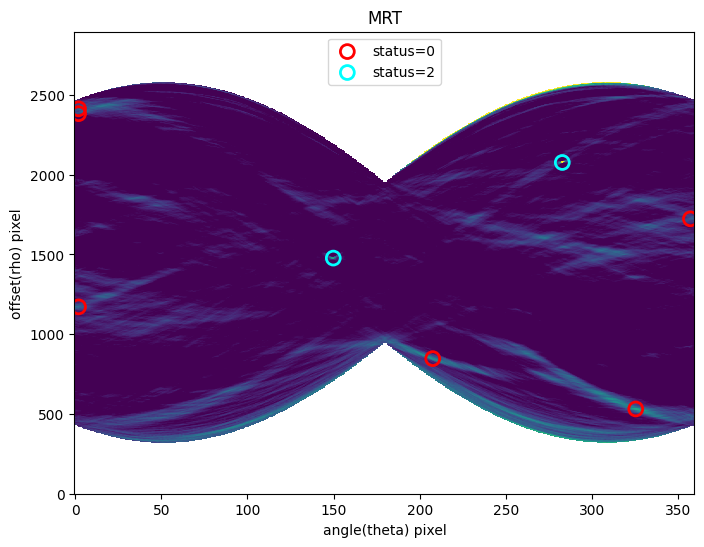

In [30]:
w.plot_mrt(show_sources=True)

Lastly, we generate the mask

<Axes: title={'center': 'Mask'}>

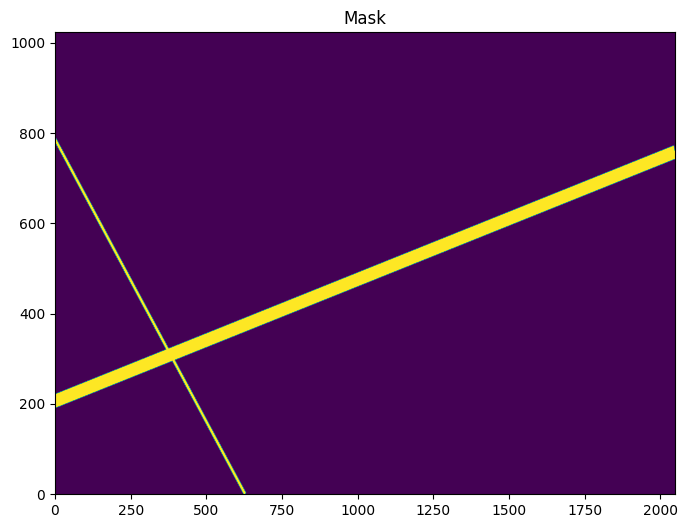

In [31]:
w.make_mask()
w.plot_mask()

If you're really feeling very confident, you can run everything in a single line by setting `execute=True`.

In [32]:
w = WfcWrapper('jc8m32j5q_flc.fits', binsize=2, extension=4, output_root='example3', processes=8,
               execute=True)

INFO:findsat_mrt:image type is flc


INFO:findsat_mrt:masking bad pixels


INFO:findsat_mrt:Subtracting median background


INFO:findsat_mrt:Rebinning the data by 2


INFO:findsat_mrt:Running the trailfinding pipeline


INFO:utils_findsat_mrt:Calculating median Radon Transform with 4 processes


INFO:findsat_mrt:Detection threshold: 5


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width15.fits


INFO:findsat_mrt:{no} sources found using kernel: 2


INFO:findsat_mrt:2 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width7.fits


INFO:findsat_mrt:{no} sources found using kernel: 4


INFO:findsat_mrt:4 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width3.fits


INFO:findsat_mrt:{no} sources found using kernel: 8


INFO:findsat_mrt:8 sources found using kernel


INFO:findsat_mrt:Removing duplicate sources


INFO:findsat_mrt:8 final sources found


INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True


INFO:findsat_mrt:Min persistence: 0.5


INFO:utils_findsat_mrt:amplitude of feature: 24.781228782083772
baseline noise: 1.1392404204749706
snr of feature = 20.752413570220774


INFO:utils_findsat_mrt:width of feature = 27.93697135868217


INFO:utils_findsat_mrt:breaking into 21.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.777939266096766
baseline noise: 5.266821168373301
snr of feature = 4.08426969704144


INFO:utils_findsat_mrt:width of feature = 26.912252404115833


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.08426969704144, 26.912252404115833, 255.94771205201673


INFO:utils_findsat_mrt:Checking persistence, step 2 of 21


INFO:utils_findsat_mrt:amplitude of feature: 36.86109099480041
baseline noise: 4.031873465370958
snr of feature = 8.142422576351603


INFO:utils_findsat_mrt:width of feature = 26.299791363903836


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.142422576351603, 26.299791363903836, 255.3153709824764


INFO:utils_findsat_mrt:Checking persistence, step 3 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.884373215737874
baseline noise: 4.432935911817287
snr of feature = 5.7414403930524545


INFO:utils_findsat_mrt:width of feature = 24.522434144873472


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.7414403930524545, 24.522434144873472, 253.71933453180375


INFO:utils_findsat_mrt:Checking persistence, step 4 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.338171095058804
baseline noise: 5.139947037197364
snr of feature = 5.875201405640844


INFO:utils_findsat_mrt:width of feature = 24.328122083921244


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.875201405640844, 24.328122083921244, 252.1528345263356


INFO:utils_findsat_mrt:Checking persistence, step 5 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.827924719714396
baseline noise: 4.373673374850432
snr of feature = 7.191723900950792


INFO:utils_findsat_mrt:width of feature = 31.80533203666792


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.191723900950792, 31.80533203666792, 250.32894672821345


INFO:utils_findsat_mrt:Checking persistence, step 6 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.98748795205496
baseline noise: 4.047251630718669
snr of feature = 6.162264814977087


INFO:utils_findsat_mrt:width of feature = 22.328341449863046


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.162264814977087, 22.328341449863046, 250.78695422770954


INFO:utils_findsat_mrt:Checking persistence, step 7 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.176049037358098
baseline noise: 5.473593475770235
snr of feature = 3.7822420779385055


INFO:utils_findsat_mrt:width of feature = 18.610593335348995


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7822420779385055, 18.610593335348995, 250.01554635050337


INFO:utils_findsat_mrt:Checking persistence, step 8 of 21


INFO:utils_findsat_mrt:amplitude of feature: 38.773673376342536
baseline noise: 4.532406342910618
snr of feature = 7.554765491622466


INFO:utils_findsat_mrt:width of feature = 24.568512312437377


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.554765491622466, 24.568512312437377, 249.70351180160577


INFO:utils_findsat_mrt:Checking persistence, step 9 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.60885136170824
baseline noise: 8.783011700036266
snr of feature = 2.3711501672696147


INFO:utils_findsat_mrt:width of feature = 20.19012908962668


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.3711501672696147, 20.19012908962668, 249.57377404180238


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 21


INFO:utils_findsat_mrt:amplitude of feature: 41.80623636545298
baseline noise: 4.939912133819193
snr of feature = 7.462951411472038


INFO:utils_findsat_mrt:width of feature = 42.53203134793276


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.462951411472038, 42.53203134793276, 249.78357415447687


INFO:utils_findsat_mrt:Checking persistence, step 11 of 21


INFO:utils_findsat_mrt:amplitude of feature: 27.730559231566154
baseline noise: 5.385939821448101
snr of feature = 4.148694592007217


INFO:utils_findsat_mrt:width of feature = 29.08177986641519


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.148694592007217, 29.08177986641519, 250.48055834836185


INFO:utils_findsat_mrt:Checking persistence, step 12 of 21


INFO:utils_findsat_mrt:amplitude of feature: 32.561900539500186
baseline noise: 4.5295217241865995
snr of feature = 6.188816506967426


INFO:utils_findsat_mrt:width of feature = 28.09886146195248


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.188816506967426, 28.09886146195248, 249.0269336127743


INFO:utils_findsat_mrt:Checking persistence, step 13 of 21


INFO:utils_findsat_mrt:amplitude of feature: 26.97240172562028
baseline noise: 3.8596124486331966
snr of feature = 5.988370486568414


INFO:utils_findsat_mrt:width of feature = 23.44420709235706


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.988370486568414, 23.44420709235706, 250.06034393794346


INFO:utils_findsat_mrt:Checking persistence, step 14 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.68602494941817
baseline noise: 5.694566385833712
snr of feature = 4.037437972587337


INFO:utils_findsat_mrt:width of feature = 21.804636480148332


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.037437972587337, 21.804636480148332, 251.089147339524


INFO:utils_findsat_mrt:Checking persistence, step 15 of 21


INFO:utils_findsat_mrt:amplitude of feature: 35.83959172421478
baseline noise: 4.547749129001824
snr of feature = 6.880731919810436


INFO:utils_findsat_mrt:width of feature = 27.597328312013047


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.880731919810436, 27.597328312013047, 251.16204416559495


INFO:utils_findsat_mrt:Checking persistence, step 16 of 21


INFO:utils_findsat_mrt:amplitude of feature: 29.653511720250755
baseline noise: 4.689231761741343
snr of feature = 5.323746239669532


INFO:utils_findsat_mrt:width of feature = 34.20544765839057


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.323746239669532, 34.20544765839057, 251.01088333237297


INFO:utils_findsat_mrt:Checking persistence, step 17 of 21


INFO:utils_findsat_mrt:amplitude of feature: 27.925070312484305
baseline noise: 6.539005857808222
snr of feature = 3.2705375893093898


INFO:utils_findsat_mrt:width of feature = 20.67192262702821


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2705375893093898, 20.67192262702821, 252.99250047723368


INFO:utils_findsat_mrt:Checking persistence, step 18 of 21


INFO:utils_findsat_mrt:amplitude of feature: 33.60054527635417
baseline noise: 4.936877710060228
snr of feature = 5.8060315141863725


INFO:utils_findsat_mrt:width of feature = 25.624363360386155


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.8060315141863725, 25.624363360386155, 254.44205498923287


INFO:utils_findsat_mrt:Checking persistence, step 19 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.422250393722546
baseline noise: 3.9568555503182568
snr of feature = 6.183039671851679


INFO:utils_findsat_mrt:width of feature = 24.644950933499302


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.183039671851679, 24.644950933499302, 255.1339854488413


INFO:utils_findsat_mrt:Checking persistence, step 20 of 21


INFO:utils_findsat_mrt:amplitude of feature: 28.481791025926363
baseline noise: 6.130826230606326
snr of feature = 3.6456692710909824


INFO:utils_findsat_mrt:width of feature = 27.528715120165543


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.6456692710909824, 27.528715120165543, 256.08658854547815


INFO:utils_findsat_mrt:Checking persistence, step 21 of 21


INFO:utils_findsat_mrt:amplitude of feature: 31.705863786725068
baseline noise: 5.038364135503358
snr of feature = 5.29288851182994


INFO:utils_findsat_mrt:width of feature = 29.3261044453607


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.29288851182994, 29.3261044453607, 257.26469437207624


INFO:utils_findsat_mrt:Number of sections analyzed: 21
Number of sections that passed: 20
persistance score: 0.9523809523809523


INFO:utils_findsat_mrt:amplitude of feature: 140.6325310562624
baseline noise: 1.6349383069861778
snr of feature = 85.0170261197821


INFO:utils_findsat_mrt:width of feature = 5.852792378744823


INFO:utils_findsat_mrt:breaking into 10.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 10


INFO:utils_findsat_mrt:amplitude of feature: 433.35799221899043
baseline noise: 5.146599100327714
snr of feature = 83.20278785487605


INFO:utils_findsat_mrt:width of feature = 3.9196903857742313


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 83.20278785487605, 3.9196903857742313, 252.12346347777913


INFO:utils_findsat_mrt:Checking persistence, step 2 of 10


INFO:utils_findsat_mrt:amplitude of feature: 382.87756197996185
baseline noise: 6.7085814104331645
snr of feature = 56.07280549424531


INFO:utils_findsat_mrt:width of feature = 3.963505073451529


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 56.07280549424531, 3.963505073451529, 251.94556991306192


INFO:utils_findsat_mrt:Checking persistence, step 3 of 10


INFO:utils_findsat_mrt:amplitude of feature: 294.4385404166353
baseline noise: 5.670862529053957
snr of feature = 50.92129749365571


INFO:utils_findsat_mrt:width of feature = 3.9409384384177315


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 50.92129749365571, 3.9409384384177315, 251.76604610986263


INFO:utils_findsat_mrt:Checking persistence, step 4 of 10


INFO:utils_findsat_mrt:amplitude of feature: 209.99469753845483
baseline noise: 4.176245406945087
snr of feature = 49.28313163523247


INFO:utils_findsat_mrt:width of feature = 4.040644251356582


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 49.28313163523247, 4.040644251356582, 251.53667204446884


INFO:utils_findsat_mrt:Checking persistence, step 5 of 10


INFO:utils_findsat_mrt:amplitude of feature: 231.35124981013368
baseline noise: 4.221398902077043
snr of feature = 53.80440374784353


INFO:utils_findsat_mrt:width of feature = 4.0823911470658345


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 53.80440374784353, 4.0823911470658345, 251.24883549025523


INFO:utils_findsat_mrt:Checking persistence, step 6 of 10


INFO:utils_findsat_mrt:amplitude of feature: 209.89648284455865
baseline noise: 4.617413792211489
snr of feature = 44.45758562912545


INFO:utils_findsat_mrt:width of feature = 4.000327266785064


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 44.45758562912545, 4.000327266785064, 250.96659870829532


INFO:utils_findsat_mrt:Checking persistence, step 7 of 10


INFO:utils_findsat_mrt:amplitude of feature: 155.9266668195209
baseline noise: 5.862285931168757
snr of feature = 25.598270478498133


INFO:utils_findsat_mrt:width of feature = 4.121455894765404


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 25.598270478498133, 4.121455894765404, 250.65087811069012


INFO:utils_findsat_mrt:Checking persistence, step 8 of 10


INFO:utils_findsat_mrt:amplitude of feature: 157.05851550614148
baseline noise: 4.338156976834571
snr of feature = 35.20397241151531


INFO:utils_findsat_mrt:width of feature = 3.9598865146421076


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 35.20397241151531, 3.9598865146421076, 250.3121777727571


INFO:utils_findsat_mrt:Checking persistence, step 9 of 10


INFO:utils_findsat_mrt:amplitude of feature: 170.627447731048
baseline noise: 5.29262014663969
snr of feature = 31.238748106527197


INFO:utils_findsat_mrt:width of feature = 4.038551384055381


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 31.238748106527197, 4.038551384055381, 249.89181733506314


INFO:utils_findsat_mrt:Checking persistence, step 10 of 10


INFO:utils_findsat_mrt:amplitude of feature: 158.2991830792352
baseline noise: 7.87008105556901
snr of feature = 19.11404736006116


INFO:utils_findsat_mrt:width of feature = 3.7413829072455655


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 19.11404736006116, 3.7413829072455655, 249.45429170495117


INFO:utils_findsat_mrt:Number of sections analyzed: 10
Number of sections that passed: 10
persistance score: 1.0


INFO:utils_findsat_mrt:amplitude of feature: 9.516165693052654
baseline noise: 1.6769988058063947
snr of feature = 4.674521448735767


INFO:utils_findsat_mrt:width of feature = 77.80569657005722


INFO:utils_findsat_mrt:amplitude of feature: 8.662488481692705
baseline noise: 1.310166879396368
snr of feature = 5.6117443647207494


INFO:utils_findsat_mrt:width of feature = 153.5992941626944


INFO:utils_findsat_mrt:amplitude of feature: 23.16941167211695
baseline noise: 2.171206884893149
snr of feature = 9.671213247031123


INFO:utils_findsat_mrt:width of feature = 183.82199492799182


INFO:utils_findsat_mrt:amplitude of feature: 15.82572897769589
baseline noise: 1.6913642253460386
snr of feature = 8.356783560003512


INFO:utils_findsat_mrt:width of feature = 79.72093191943699


INFO:utils_findsat_mrt:amplitude of feature: 6.643006846505017
baseline noise: 1.6379596760811124
snr of feature = 3.0556595766744947


INFO:utils_findsat_mrt:width of feature = 127.90245994123578


INFO:utils_findsat_mrt:amplitude of feature: 7.968046280696431
baseline noise: 1.7889030634523286
snr of feature = 3.4541520686533085


INFO:utils_findsat_mrt:width of feature = 108.52591914378449


INFO:findsat_mrt:Wrote diagnostic plot to ./example3_diagnostic.png


INFO:findsat_mrt:wrote catalog ./example3_catalog.fits


We'll plot the image and mask together to check that everything looks ok

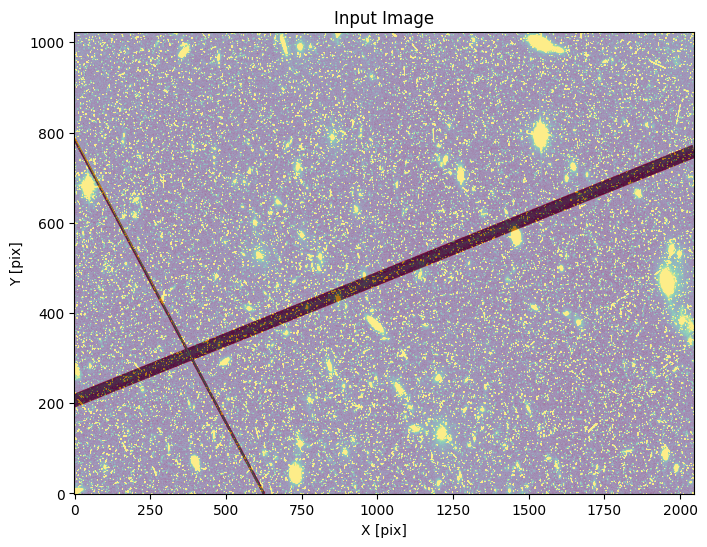

In [33]:
w.plot_image(overlay_mask=True)

<a id="example4"></a>
## Example 4: Finding trails in a DRC image

Applying `TrailFinder` to a DRC image (that shows both chips together) can boost sensitivity by increasing the number of pixels over which we search for trails. The DRC files also remove the distortion in the original FLC files (though this does not appear to create signficant curvature to most trails). 

Here, we demonstrate the steps that go into preparing a DRC image to be analyzed. The subsequent example will illustrate how to do all of this in a single line.

There are no DQ arrays for the DRC files, so we ignore the pre-processing steps that incorporated those.

In [34]:
# Read in the image files and header information
image_file = 'hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits'
ext = 1
with fits.open(image_file) as h:
    image = h[ext].data  # image data
    wht = h[ext+1].data
    image = image*wht  # wht is effective exposure time, so this turns it into counts
    
    header = h[0].header  # primary header
    image_header = h[1].header  # image header

In [35]:
# Flag anything with wht == 0 as bad
image[wht == 0] = np.nan

# Subtract the background from the image. 
median = np.nanmedian(image)
image = image - np.nanmedian(image)

In [36]:
# Let's rebin the images
binsize = 2
image_rebin = block_reduce(image, binsize, func=np.nansum)

Setting up `TrailFinder` is essentially the same as earlier examples at this point. We'll use the default settings. In fact, about all the steps from here on out are the same.

In [37]:
s4 = TrailFinder(image=image_rebin, processes=8, output_root='example4')

We can do a quick plot of our image to make sure things look ok

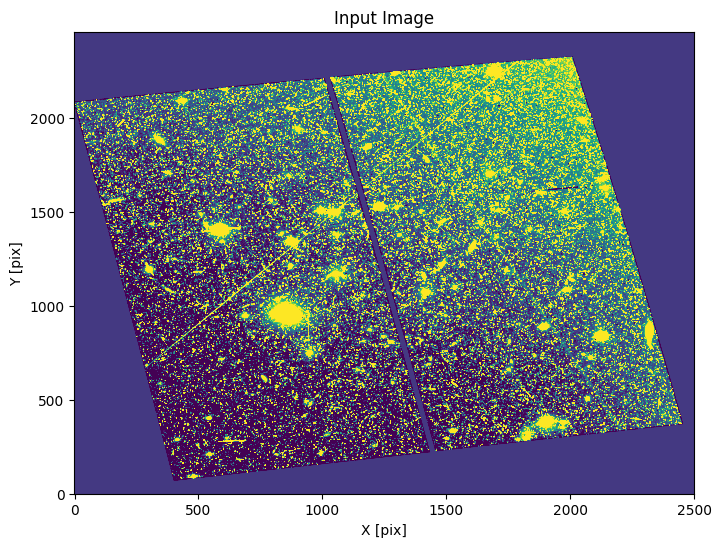

In [38]:
s4.plot_image()

Now run the MRT calculation and plot the results

INFO:utils_findsat_mrt:Calculating median Radon Transform with 4 processes


<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

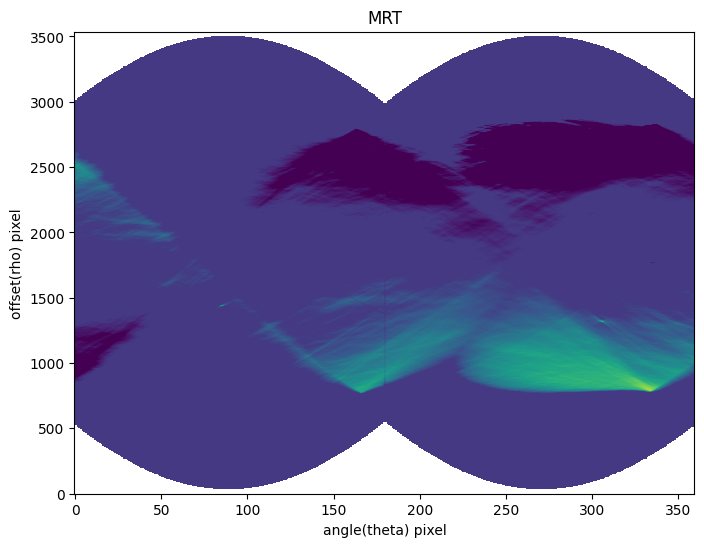

In [39]:
s4.run_mrt()
s4.plot_mrt(scale=[-1, 5])  # adjusted scale manually due to varying background in image

This example has a clear gradient in the background due to the cluster. This causes some large scale variation in the RT, but you can see the "point source" signals from the satellite trails around `x,y = (90,700)` and `x,y = (300,700)`. This is a case where we may have wanted to explore some different background subtraction methods, but we'll proceed with the simpler approach here. Now we'll try to pull the sources out.

In [40]:
s4.find_mrt_sources()

INFO:findsat_mrt:Detection threshold: 5


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width15.fits


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/photutils/detection/starfinder.py:326: RuntimeWarning: invalid value encountered in divide
  return moments / self.moments[:, 0, 0][:, np.newaxis, np.newaxis]
/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/photutils/detection/starfinder.py:317: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(self.flux)
INFO:findsat_mrt:{no} sources found using kernel: 97


INFO:findsat_mrt:54 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width7.fits


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/photutils/detection/starfinder.py:326: RuntimeWarning: invalid value encountered in divide
  return moments / self.moments[:, 0, 0][:, np.newaxis, np.newaxis]
/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/photutils/detection/starfinder.py:317: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(self.flux)
INFO:findsat_mrt:{no} sources found using kernel: 130


INFO:findsat_mrt:69 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width3.fits


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/photutils/detection/starfinder.py:326: RuntimeWarning: invalid value encountered in divide
  return moments / self.moments[:, 0, 0][:, np.newaxis, np.newaxis]
/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/photutils/detection/starfinder.py:317: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(self.flux)
INFO:findsat_mrt:{no} sources found using kernel: 202


INFO:findsat_mrt:115 sources found using kernel


INFO:findsat_mrt:Removing duplicate sources


INFO:findsat_mrt:131 final sources found


<QTable length=131>
  id      xcentroid      ...                endpoints                 status
int64      float64       ...               float64[2,2]               int64 
----- ------------------ ... ---------------------------------------- ------
    1  166.3291751107258 ...                 0.0 .. 2368.713398598511      0
    2  333.6414724966775 ...  1963.5543159844756 .. 165.1231012410044      0
    3  175.6169480469905 ...                0.0 .. 2176.7564306069494      0
    4 154.43033393278887 ...                 0.0 .. 2423.150175048332      0
    5  346.4116386719312 ...                 1990.880733152526 .. 0.0      0
    7  351.5145652388694 ...                1995.3688431350345 .. 0.0      0
    8 147.42462800513917 ...                            0.0 .. 2456.0      0
    9 226.49472667413414 ... 496.22151601340664 .. 1595.2180526055413      0
   11 144.34444604437752 ...                            0.0 .. 2456.0      0
   12 142.12598196596468 ...                            0.0 .. 2456.0      0
  ...                ... ...                                      ...    ...
  284   58.1545089913092 ...              422.1259564641803 .. 2456.0      0
  286  60.95692166151612 ...              418.0210987882469 .. 2456.0      0
  287  244.2220969614178 ...                -0.0 .. 538.5319438314716      0
  294 13.348888801564964 ...              1349.597267594565 .. 2456.0      0
  296 1.8775893962202779 ...              1500.742347309361 .. 2456.0      0
  298  7.612927255252101 ...              1485.657361311005 .. 2456.0      0
  301  10.64503737828278 ...             1479.0325778552224 .. 2456.0      0
  305  4.166943510886547 ...             1592.6015475889083 .. 2456.0      0
  309   4.23881358487796 ...             1638.0261595819734 .. 2456.0      0
  351 2.6684987357377894 ...             1914.2654205554988 .. 2456.0      0

And below we plot the MRT with the sources overlaid

<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

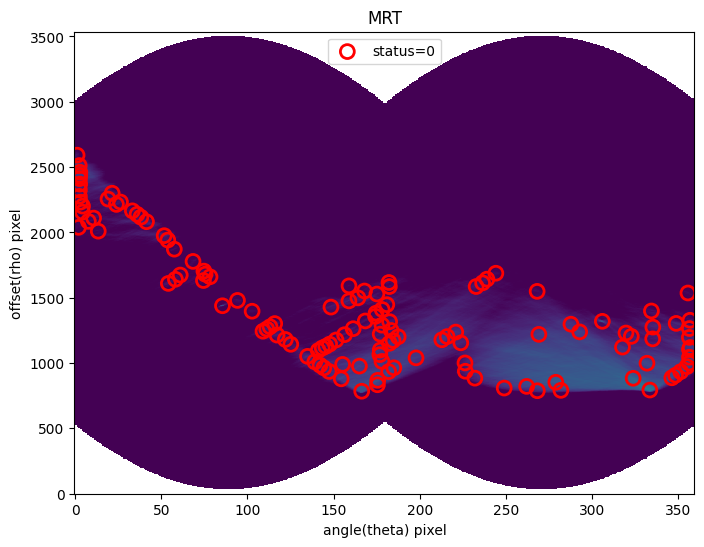

In [41]:
s4.plot_mrt(show_sources=True)

It's clearly shredding those large-scale features quite a bit, but we'll try to filter these out.

In [42]:
s4.filter_sources()

INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True


INFO:findsat_mrt:Min persistence: 0.5


INFO:utils_findsat_mrt:amplitude of feature: 15.99405940928866
baseline noise: 1.6026299959616415
snr of feature = 8.979882723767185


INFO:utils_findsat_mrt:width of feature = 143.16799805509876


INFO:utils_findsat_mrt:amplitude of feature: 24.98593980542087
baseline noise: 2.2209910073060746
snr of feature = 10.24990588580873


INFO:utils_findsat_mrt:width of feature = 141.12418748611918


INFO:utils_findsat_mrt:amplitude of feature: 12.462047410002342
baseline noise: 1.2162319884270165
snr of feature = 9.246439436377447


INFO:utils_findsat_mrt:width of feature = 186.7063173228225


INFO:utils_findsat_mrt:amplitude of feature: 12.366655185892373
baseline noise: 1.20677834224946
snr of feature = 9.247660861099536


INFO:utils_findsat_mrt:width of feature = 126.55867957204475


INFO:utils_findsat_mrt:amplitude of feature: 9.490616184410307
baseline noise: 1.913850750250663
snr of feature = 3.958911337870673


INFO:utils_findsat_mrt:width of feature = 176.6056124853829


INFO:utils_findsat_mrt:amplitude of feature: 11.833474257783369
baseline noise: 1.1968054366768914
snr of feature = 8.887550553447328


INFO:utils_findsat_mrt:width of feature = 182.66806151508968


INFO:utils_findsat_mrt:amplitude of feature: 6.903377365774249
baseline noise: 0.5557335207637911
snr of feature = 11.42209999549129


INFO:utils_findsat_mrt:width of feature = 202.34100738283985


INFO:utils_findsat_mrt:amplitude of feature: -2.4094122201963284
baseline noise: 1.1918408584560014
snr of feature = -3.021588874975858


INFO:utils_findsat_mrt:width of feature = 23.615460614512102


INFO:utils_findsat_mrt:amplitude of feature: 6.450202313392029
baseline noise: 0.420085280136181
snr of feature = 14.354506854658265


INFO:utils_findsat_mrt:width of feature = 205.0707492706507


INFO:utils_findsat_mrt:amplitude of feature: 6.006959474637118
baseline noise: 0.6055671184143364
snr of feature = 8.91956018082059


INFO:utils_findsat_mrt:width of feature = 193.33231594396335


INFO:utils_findsat_mrt:amplitude of feature: 8.749394010704167
baseline noise: 1.0248790424272876
snr of feature = 7.537001586043178


INFO:utils_findsat_mrt:width of feature = 184.18880710430543


INFO:utils_findsat_mrt:amplitude of feature: 7.5012154415417935
baseline noise: 0.3940681014791912
snr of feature = 18.035327684186832


INFO:utils_findsat_mrt:width of feature = 218.922497126986


INFO:utils_findsat_mrt:amplitude of feature: 6.044952723834221
baseline noise: 2.4797766538399055
snr of feature = 1.4377004737397143


INFO:utils_findsat_mrt:width of feature = 150.6398001356198


INFO:utils_findsat_mrt:amplitude of feature: 9.664966339341918
baseline noise: 0.43622142601426883
snr of feature = 21.1561018394951


INFO:utils_findsat_mrt:width of feature = 157.815020400659


INFO:utils_findsat_mrt:amplitude of feature: 2.128025684932389
baseline noise: 0.8557996680638119
snr of feature = 1.4865932581475536


INFO:utils_findsat_mrt:width of feature = 13.900959393906192


INFO:utils_findsat_mrt:amplitude of feature: 5.753622267703956
baseline noise: 1.3622649920612073
snr of feature = 3.223570524996243


INFO:utils_findsat_mrt:width of feature = 164.0610598631819


INFO:utils_findsat_mrt:amplitude of feature: 2.664283027200659
baseline noise: 1.8154678111270959
snr of feature = 0.467546276982236


INFO:utils_findsat_mrt:width of feature = 1.3292002832748153


INFO:utils_findsat_mrt:amplitude of feature: 3.0019484350478174
baseline noise: 1.2197746895806025
snr of feature = 1.4610679830387225


INFO:utils_findsat_mrt:width of feature = 15.56214067516754


INFO:utils_findsat_mrt:amplitude of feature: 4.635915136908951
baseline noise: 0.9535267866654203
snr of feature = 3.8618614618276377


INFO:utils_findsat_mrt:width of feature = 127.39804730255779


INFO:utils_findsat_mrt:amplitude of feature: 2.99461888548488
baseline noise: 0.6643779704775601
snr of feature = 3.5074024404095225


INFO:utils_findsat_mrt:width of feature = 35.776564789422224


INFO:utils_findsat_mrt:amplitude of feature: 6.277094484562031
baseline noise: 0.48553046912099335
snr of feature = 11.928322492151961


INFO:utils_findsat_mrt:width of feature = 75.90829205524739


INFO:utils_findsat_mrt:amplitude of feature: -0.08880037641248695
baseline noise: 0.9830211521785395
snr of feature = -1.0903341461327567


INFO:utils_findsat_mrt:width of feature = 14.351593598434647


INFO:utils_findsat_mrt:amplitude of feature: 6.223148025043565
baseline noise: 0.17637286271652328
snr of feature = 34.28404500099185


INFO:utils_findsat_mrt:width of feature = 244.50972189170122


INFO:utils_findsat_mrt:amplitude of feature: 4.63147998549964
baseline noise: 0.852696461731759
snr of feature = 4.431569372404186


INFO:utils_findsat_mrt:width of feature = 29.048027978488392


INFO:utils_findsat_mrt:amplitude of feature: 4.188910336470276
baseline noise: 0.5264154802694442
snr of feature = 6.957422403927398


INFO:utils_findsat_mrt:width of feature = 48.20888016686308


INFO:utils_findsat_mrt:breaking into 5.0 sections for persistence check
Section size for persistence check: 508.0


INFO:utils_findsat_mrt:Checking persistence, step 1 of 5


INFO:utils_findsat_mrt:amplitude of feature: 8.566025283241697
baseline noise: 0.8702262193092349
snr of feature = 8.843446558115895


INFO:utils_findsat_mrt:width of feature = 268.74105545965654


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.843446558115895, 268.74105545965654, 239.61430482630476


INFO:utils_findsat_mrt:Checking persistence, step 2 of 5


INFO:utils_findsat_mrt:amplitude of feature: 11.160141468392215
baseline noise: 1.9520700502723205
snr of feature = 4.717080422823626


INFO:utils_findsat_mrt:width of feature = 210.14172887663125


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.717080422823626, 210.14172887663125, 246.3910145167347


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 5


INFO:utils_findsat_mrt:amplitude of feature: 7.603656152533606
baseline noise: 3.132148262514024
snr of feature = 1.4276169310167073


INFO:utils_findsat_mrt:width of feature = 268.5097482830402


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.4276169310167073, 268.5097482830402, 239.6532307730479


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 5


INFO:utils_findsat_mrt:amplitude of feature: 4.999785736331674
baseline noise: 2.6448161604091944
snr of feature = 0.8904095532893783


INFO:utils_findsat_mrt:width of feature = 268.3549353427398


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8904095532893783, 268.3549353427398, 239.57021874402264


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 5


INFO:utils_findsat_mrt:amplitude of feature: 14.114940116667846
baseline noise: 5.770460742729542
snr of feature = 1.4460681297332942


INFO:utils_findsat_mrt:width of feature = 268.597302408675


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.4460681297332942, 268.597302408675, 239.52896088338736


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 5
Number of sections that passed: 1
persistance score: 0.2


INFO:utils_findsat_mrt:amplitude of feature: 4.831049898516181
baseline noise: 0.7890184148706302
snr of feature = 5.122860769109292


INFO:utils_findsat_mrt:width of feature = 26.995375067344185


INFO:utils_findsat_mrt:breaking into 2.0 sections for persistence check
Section size for persistence check: 1228.0


INFO:utils_findsat_mrt:Checking persistence, step 1 of 2


INFO:utils_findsat_mrt:amplitude of feature: 8.754972209650262
baseline noise: 1.2389711737615516
snr of feature = 6.066324378693911


INFO:utils_findsat_mrt:width of feature = 355.4396149544613


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.066324378693911, 355.4396149544613, 240.09323824246073


INFO:utils_findsat_mrt:Checking persistence, step 2 of 2


INFO:utils_findsat_mrt:amplitude of feature: 4.525932322238157
baseline noise: 0.766566838065555
snr of feature = 4.904158773238127


INFO:utils_findsat_mrt:width of feature = 244.61092769667624


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.904158773238127, 244.61092769667624, 244.05882476846912


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 2
Number of sections that passed: 1
persistance score: 0.5


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 6.704894065856934
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 111.3894575036523


INFO:utils_findsat_mrt:amplitude of feature: 6.755399166323678
baseline noise: 0.7523828550561829
snr of feature = 7.978672388566364


INFO:utils_findsat_mrt:width of feature = 56.619023578581874


INFO:utils_findsat_mrt:breaking into 7.0 sections for persistence check
Section size for persistence check: 352.0


INFO:utils_findsat_mrt:Checking persistence, step 1 of 7


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 16.0273394396704
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 837.5785542682762


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 837.5785542682762, 278.1596895631911


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 7


INFO:utils_findsat_mrt:amplitude of feature: 6.260855196950168
baseline noise: 2.698044223859438
snr of feature = 1.3205161507672694


INFO:utils_findsat_mrt:width of feature = 47.57070588387441


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3205161507672694, 47.57070588387441, 259.477696587951


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 7


INFO:utils_findsat_mrt:amplitude of feature: 21.512919927056235
baseline noise: 3.1368056823600408
snr of feature = 5.858225247434053


INFO:utils_findsat_mrt:width of feature = 90.43477471463893


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.858225247434053, 90.43477471463893, 256.65446769506264


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 7


INFO:utils_findsat_mrt:amplitude of feature: 10.412032405648326
baseline noise: 2.2840618043156042
snr of feature = 3.558559836680157


INFO:utils_findsat_mrt:width of feature = 108.20737758132759


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.558559836680157, 108.20737758132759, 269.0652054937933


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 7


INFO:utils_findsat_mrt:amplitude of feature: 10.008337407841069
baseline noise: 2.8466360546173606
snr of feature = 2.5158472020359377


INFO:utils_findsat_mrt:width of feature = 28.487343341446035


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.5158472020359377, 28.487343341446035, 253.15968956319108


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 7


INFO:utils_findsat_mrt:amplitude of feature: 10.04966581551703
baseline noise: 2.1632194767441058
snr of feature = 3.645698655895487


INFO:utils_findsat_mrt:width of feature = 70.59347096306522


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.645698655895487, 70.59347096306522, 253.15968956319108


INFO:utils_findsat_mrt:Checking persistence, step 7 of 7


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 70.59347096306522


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 70.59347096306522, 253.15968956319108


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 7
Number of sections that passed: 1
persistance score: 0.14285714285714285


INFO:utils_findsat_mrt:amplitude of feature: 27.560123237932967
baseline noise: 0.7110841669676935
snr of feature = 37.757891847682075


INFO:utils_findsat_mrt:width of feature = 21.264022681900855


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 21.264022681900855


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 21.264022681900855, 250.63543354990355


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 21.264022681900855


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 21.264022681900855, 250.63543354990355


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 4.673899631640953
baseline noise: 7.015631389388987
snr of feature = -0.33378774165499336


INFO:utils_findsat_mrt:width of feature = 2.7616640425765695


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.33378774165499336, 2.7616640425765695, 250.7010922898889


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 30.43715873432439
baseline noise: 5.459683893555869
snr of feature = 4.57489395498698


INFO:utils_findsat_mrt:width of feature = 18.50767932153599


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.57489395498698, 18.50767932153599, 250.63543354990355


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 37.565402819635906
baseline noise: 4.748002987397133
snr of feature = 6.911832178570165


INFO:utils_findsat_mrt:width of feature = 23.81933507911569


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.911832178570165, 23.81933507911569, 249.25007696197406


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 36.6243512560693
baseline noise: 4.791147748778954
snr of feature = 6.644170703231431


INFO:utils_findsat_mrt:width of feature = 26.36301188841159


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.644170703231431, 26.36301188841159, 249.20904397573244


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 38.941099574584356
baseline noise: 4.103603573620928
snr of feature = 8.489488659408588


INFO:utils_findsat_mrt:width of feature = 25.373784280623198


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.489488659408588, 25.373784280623198, 249.22812599786607


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 38.831698346596106
baseline noise: 4.56910043508633
snr of feature = 7.498762261473992


INFO:utils_findsat_mrt:width of feature = 28.96657479412883


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.498762261473992, 28.96657479412883, 248.5528776654172


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 30.49439063679295
baseline noise: 4.62920583936506
snr of feature = 5.587391378771688


INFO:utils_findsat_mrt:width of feature = 17.748079412524305


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.587391378771688, 17.748079412524305, 250.1342112344761


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 30.413255067170766
baseline noise: 7.339480495678269
snr of feature = 3.1437885263240504


INFO:utils_findsat_mrt:width of feature = 17.702581348040695


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.1437885263240504, 17.702581348040695, 248.93990377415054


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 40.34566179596672
baseline noise: 7.987636909359319
snr of feature = 4.0510134916989875


INFO:utils_findsat_mrt:width of feature = 18.567867583080925


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.0510134916989875, 18.567867583080925, 250.525617900396


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 54.45969534023246
baseline noise: 5.932489628268837
snr of feature = 8.1799056977238


INFO:utils_findsat_mrt:width of feature = 34.8983177804069


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.1799056977238, 34.8983177804069, 248.86188991143175


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 39.384743400864494
baseline noise: 7.692260440376863
snr of feature = 4.1200480932929695


INFO:utils_findsat_mrt:width of feature = 34.4845801207168


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.1200480932929695, 34.4845801207168, 252.3268535174114


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 35.27515328051952
baseline noise: 4.332938368510719
snr of feature = 7.141162019953677


INFO:utils_findsat_mrt:width of feature = 23.19675622780383


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.141162019953677, 23.19675622780383, 250.1194116647244


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 34.639564886553735
baseline noise: 4.591736284682545
snr of feature = 6.543892492717181


INFO:utils_findsat_mrt:width of feature = 29.210846372319537


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.543892492717181, 29.210846372319537, 248.98588775010057


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 30.497174538271
baseline noise: 4.282493140044581
snr of feature = 6.121359810970654


INFO:utils_findsat_mrt:width of feature = 21.632782766470143


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.121359810970654, 21.632782766470143, 251.54467967600502


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 36.41679746736839
baseline noise: 4.713452023272333
snr of feature = 6.7261415386351775


INFO:utils_findsat_mrt:width of feature = 21.279384636968246


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.7261415386351775, 21.279384636968246, 251.07584909000198


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 55.31747763489938
baseline noise: 4.22283697588067
snr of feature = 12.099600564940815


INFO:utils_findsat_mrt:width of feature = 118.91036373852279


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 12.099600564940815, 118.91036373852279, 229.79646445303374


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 28.07200179262619
baseline noise: 6.7950677086228435
snr of feature = 3.1312320930964703


INFO:utils_findsat_mrt:width of feature = 19.295900908460226


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.1312320930964703, 19.295900908460226, 251.17060582408158


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 26.747092862962965
baseline noise: 5.98354124895968
snr of feature = 3.470110884188073


INFO:utils_findsat_mrt:width of feature = 18.96077597542876


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.470110884188073, 18.96077597542876, 251.68672923580726


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 33.282969512596594
baseline noise: 4.218162486012624
snr of feature = 6.890395313827411


INFO:utils_findsat_mrt:width of feature = 27.24655218140029


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.890395313827411, 27.24655218140029, 251.64467038236194


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 32.374893960117504
baseline noise: 5.7280418999470974
snr of feature = 4.6520001993031


INFO:utils_findsat_mrt:width of feature = 23.169932019838768


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.6520001993031, 23.169932019838768, 251.7694518154589


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: 32.51574746727797
baseline noise: 6.655921197527361
snr of feature = 3.8852362433854224


INFO:utils_findsat_mrt:width of feature = 31.41806700211353


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.8852362433854224, 31.41806700211353, 250.96580134078974


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 16.679324688176187
baseline noise: 1.4447150799346378
snr of feature = 10.545061666367323


INFO:utils_findsat_mrt:width of feature = 18.27359256856684


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.545061666367323, 18.27359256856684, 252.12787874382062


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 18.27359256856684


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 18.27359256856684, 252.12787874382062


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 18.27359256856684


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 18.27359256856684, 252.12787874382062


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 18.27359256856684


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 18.27359256856684, 252.12787874382062


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 20
persistance score: 0.7407407407407407


INFO:utils_findsat_mrt:amplitude of feature: 3.653925390834935
baseline noise: 0.5476604602994544
snr of feature = 5.671880947616725


INFO:utils_findsat_mrt:width of feature = 24.37043815328977


INFO:utils_findsat_mrt:breaking into 3.0 sections for persistence check
Section size for persistence check: 837.0


INFO:utils_findsat_mrt:Checking persistence, step 1 of 3


INFO:utils_findsat_mrt:amplitude of feature: 7.265233013090317
baseline noise: 1.968971622450528
snr of feature = 2.6898617177875863


INFO:utils_findsat_mrt:width of feature = 44.683801946898086


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.6898617177875863, 44.683801946898086, 246.86492401201164


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 3


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 2.285089106785248
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 247.1106426533748


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 3


INFO:utils_findsat_mrt:amplitude of feature: 6.223806690381245
baseline noise: 2.4055390951754463
snr of feature = 1.5872814550649887


INFO:utils_findsat_mrt:width of feature = 43.010750908078904


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5872814550649887, 43.010750908078904, 247.20696349526284


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 3
Number of sections that passed: 0
persistance score: 0.0


INFO:utils_findsat_mrt:amplitude of feature: 1.6667038273620527
baseline noise: 0.4784529378049123
snr of feature = 2.483527209611671


INFO:utils_findsat_mrt:width of feature = 26.423337293416807


INFO:utils_findsat_mrt:amplitude of feature: 192.1035636412341
baseline noise: 0.29135058411192283
snr of feature = 658.3553406690176


INFO:utils_findsat_mrt:width of feature = 4.3525989517090125


INFO:utils_findsat_mrt:breaking into 28.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.3525989517090125


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.3525989517090125, 250.55962827991826


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.3525989517090125


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.3525989517090125, 250.55962827991826


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.3525989517090125


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.3525989517090125, 250.55962827991826


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 28


INFO:utils_findsat_mrt:amplitude of feature: 17.5731879822535
baseline noise: 1.6641236729514486
snr of feature = 9.560025236036772


INFO:utils_findsat_mrt:width of feature = 383.4215317935903


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.560025236036772, 383.4215317935903, 250.55962827991826


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 28


INFO:utils_findsat_mrt:amplitude of feature: 219.61164914990138
baseline noise: 5.43737048308796
snr of feature = 39.38931131012077


INFO:utils_findsat_mrt:width of feature = 5.970967817242581


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 39.38931131012077, 5.970967817242581, 250.55962827991826


INFO:utils_findsat_mrt:Checking persistence, step 6 of 28


INFO:utils_findsat_mrt:amplitude of feature: 299.3260536399842
baseline noise: 5.04503738043011
snr of feature = 58.33079005540795


INFO:utils_findsat_mrt:width of feature = 4.104770895696674


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 58.33079005540795, 4.104770895696674, 249.93115600980926


INFO:utils_findsat_mrt:Checking persistence, step 7 of 28


INFO:utils_findsat_mrt:amplitude of feature: 382.12330354985994
baseline noise: 4.1363858860261855
snr of feature = 91.38096108024504


INFO:utils_findsat_mrt:width of feature = 4.046508131613109


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 91.38096108024504, 4.046508131613109, 250.03290538797776


INFO:utils_findsat_mrt:Checking persistence, step 8 of 28


INFO:utils_findsat_mrt:amplitude of feature: 488.6273352432391
baseline noise: 3.6026613133426255
snr of feature = 134.62955069730944


INFO:utils_findsat_mrt:width of feature = 4.07748868643688


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 134.62955069730944, 4.07748868643688, 250.08034482197655


INFO:utils_findsat_mrt:Checking persistence, step 9 of 28


INFO:utils_findsat_mrt:amplitude of feature: 555.847843834708
baseline noise: 4.52775977420012
snr of feature = 121.76442911172443


INFO:utils_findsat_mrt:width of feature = 4.085448803907866


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 121.76442911172443, 4.085448803907866, 250.13540785772884


INFO:utils_findsat_mrt:Checking persistence, step 10 of 28


INFO:utils_findsat_mrt:amplitude of feature: 547.3186719913294
baseline noise: 6.279854331672693
snr of feature = 86.1546763801361


INFO:utils_findsat_mrt:width of feature = 4.244474898775309


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 86.1546763801361, 4.244474898775309, 250.1956850279054


INFO:utils_findsat_mrt:Checking persistence, step 11 of 28


INFO:utils_findsat_mrt:amplitude of feature: 482.70805298813906
baseline noise: 22.073949012087247
snr of feature = 20.867770588933492


INFO:utils_findsat_mrt:width of feature = 4.787250387286633


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 20.867770588933492, 4.787250387286633, 250.248089302173


INFO:utils_findsat_mrt:Checking persistence, step 12 of 28


INFO:utils_findsat_mrt:amplitude of feature: 334.96907494978603
baseline noise: 5.2244809998243245
snr of feature = 63.1152824483522


INFO:utils_findsat_mrt:width of feature = 4.272441597325326


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 63.1152824483522, 4.272441597325326, 250.30226981375108


INFO:utils_findsat_mrt:Checking persistence, step 13 of 28


INFO:utils_findsat_mrt:amplitude of feature: 259.86435834800557
baseline noise: 7.13400039263327
snr of feature = 35.42617662543828


INFO:utils_findsat_mrt:width of feature = 4.301650921948351


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 35.42617662543828, 4.301650921948351, 250.35273781418158


INFO:utils_findsat_mrt:Checking persistence, step 14 of 28


INFO:utils_findsat_mrt:amplitude of feature: 241.0480412800095
baseline noise: 8.148765107317434
snr of feature = 28.580928902166168


INFO:utils_findsat_mrt:width of feature = 111.93585378551941


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 28.580928902166168, 111.93585378551941, 254.65438873612993


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 28


INFO:utils_findsat_mrt:amplitude of feature: 163.33166988583912
baseline noise: 5.953528240972188
snr of feature = 26.43443270526381


INFO:utils_findsat_mrt:width of feature = 4.136023832680223


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 26.43443270526381, 4.136023832680223, 250.48788201043433


INFO:utils_findsat_mrt:Checking persistence, step 16 of 28


INFO:utils_findsat_mrt:amplitude of feature: 299.4883372633503
baseline noise: 4.94411926033906
snr of feature = 59.574658800364745


INFO:utils_findsat_mrt:width of feature = 162.34324665270236


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 59.574658800364745, 162.34324665270236, 254.62390584311456


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 28


INFO:utils_findsat_mrt:amplitude of feature: 199.10176765606167
baseline noise: 6.204115856362477
snr of feature = 31.091884204882763


INFO:utils_findsat_mrt:width of feature = 4.2382368087442615


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 31.091884204882763, 4.2382368087442615, 250.61160793090744


INFO:utils_findsat_mrt:Checking persistence, step 18 of 28


INFO:utils_findsat_mrt:amplitude of feature: 186.40625110100663
baseline noise: 5.650670527884082
snr of feature = 31.988341858042688


INFO:utils_findsat_mrt:width of feature = 4.001383454464758


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 31.988341858042688, 4.001383454464758, 250.65894800002766


INFO:utils_findsat_mrt:Checking persistence, step 19 of 28


INFO:utils_findsat_mrt:amplitude of feature: 183.79760418074102
baseline noise: 4.60678738252066
snr of feature = 38.897131974902194


INFO:utils_findsat_mrt:width of feature = 4.208832882390709


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 38.897131974902194, 4.208832882390709, 250.7244471285358


INFO:utils_findsat_mrt:Checking persistence, step 20 of 28


INFO:utils_findsat_mrt:amplitude of feature: 172.31090090548048
baseline noise: 4.644479233179664
snr of feature = 36.10015531440206


INFO:utils_findsat_mrt:width of feature = 4.173478222890878


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 36.10015531440206, 4.173478222890878, 250.7514532298155


INFO:utils_findsat_mrt:Checking persistence, step 21 of 28


INFO:utils_findsat_mrt:amplitude of feature: 185.98458742132652
baseline noise: 5.462042748890869
snr of feature = 33.05037198932448


INFO:utils_findsat_mrt:width of feature = 4.349229887770832


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 33.05037198932448, 4.349229887770832, 250.8293980270281


INFO:utils_findsat_mrt:Checking persistence, step 22 of 28


INFO:utils_findsat_mrt:amplitude of feature: 225.34105410635516
baseline noise: 4.961666040268754
snr of feature = 44.41640897986542


INFO:utils_findsat_mrt:width of feature = 4.112089663692132


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 44.41640897986542, 4.112089663692132, 250.92298604484492


INFO:utils_findsat_mrt:Checking persistence, step 23 of 28


INFO:utils_findsat_mrt:amplitude of feature: 273.1164795661465
baseline noise: 4.282453489863793
snr of feature = 62.77570245948735


INFO:utils_findsat_mrt:width of feature = 4.239289775006057


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 62.77570245948735, 4.239289775006057, 250.97160244574863


INFO:utils_findsat_mrt:Checking persistence, step 24 of 28


INFO:utils_findsat_mrt:amplitude of feature: 308.7159429518224
baseline noise: 4.780830556866008
snr of feature = 63.573705191968955


INFO:utils_findsat_mrt:width of feature = 4.055915296617343


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 63.573705191968955, 4.055915296617343, 251.0276837387912


INFO:utils_findsat_mrt:Checking persistence, step 25 of 28


INFO:utils_findsat_mrt:amplitude of feature: 354.4701636871301
baseline noise: 7.49814430510368
snr of feature = 46.27438540304656


INFO:utils_findsat_mrt:width of feature = 3.988756335687299


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 46.27438540304656, 3.988756335687299, 251.13695521351738


INFO:utils_findsat_mrt:Checking persistence, step 26 of 28


INFO:utils_findsat_mrt:amplitude of feature: 463.6687281012708
baseline noise: 8.098608619880173
snr of feature = 56.25288748527414


INFO:utils_findsat_mrt:width of feature = 4.774038940578976


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 56.25288748527414, 4.774038940578976, 251.2181194561904


INFO:utils_findsat_mrt:Checking persistence, step 27 of 28


INFO:utils_findsat_mrt:amplitude of feature: -29.227650590882337
baseline noise: 8.17820153889639
snr of feature = -4.573848168435633


INFO:utils_findsat_mrt:width of feature = 4.215031613473798


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -4.573848168435633, 4.215031613473798, 251.22513343696892


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 28


INFO:utils_findsat_mrt:amplitude of feature: -0.13014520061031298
baseline noise: 16.380948143604893
snr of feature = -1.0079449125575262


INFO:utils_findsat_mrt:width of feature = 4.75937690342198


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0079449125575262, 4.75937690342198, 251.2196350015951


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 28
Number of sections that passed: 20
persistance score: 0.7142857142857143


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 1.9365272521972656
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.863845504563301


INFO:utils_findsat_mrt:breaking into 29.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.863845504563301


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.863845504563301, 241.4057071657873


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.863845504563301


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.863845504563301, 241.4057071657873


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 1.6845326136276513
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 241.55018120621298


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 29


INFO:utils_findsat_mrt:amplitude of feature: 26.24626835581196
baseline noise: 3.454387189978931
snr of feature = 6.597952085959433


INFO:utils_findsat_mrt:width of feature = 210.08960899569652


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.597952085959433, 210.08960899569652, 241.4057071657873


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 7.535800456575885
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 241.5399076997939


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 29


INFO:utils_findsat_mrt:amplitude of feature: 5.529040822268662
baseline noise: 4.242695733030739
snr of feature = 0.3031905114532058


INFO:utils_findsat_mrt:width of feature = 1.8583865843810372


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3031905114532058, 1.8583865843810372, 241.41252496288178


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 3.862819702472811
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.6596629878545741


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.6596629878545741, 241.4057071657873


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 29


INFO:utils_findsat_mrt:amplitude of feature: 69.41814271129371
baseline noise: 4.1853627021465165
snr of feature = 15.585932367508253


INFO:utils_findsat_mrt:width of feature = 21.460699103388436


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 15.585932367508253, 21.460699103388436, 241.4057071657873


INFO:utils_findsat_mrt:Checking persistence, step 9 of 29


INFO:utils_findsat_mrt:amplitude of feature: 132.86914802526212
baseline noise: 5.649220944046675
snr of feature = 22.51990643334348


INFO:utils_findsat_mrt:width of feature = 18.933106773761807


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 22.51990643334348, 18.933106773761807, 247.36001982887439


INFO:utils_findsat_mrt:Checking persistence, step 10 of 29


INFO:utils_findsat_mrt:amplitude of feature: 102.8515131078504
baseline noise: 15.554432519629515
snr of feature = 5.612360365963398


INFO:utils_findsat_mrt:width of feature = 207.31768351913615


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.612360365963398, 207.31768351913615, 245.50922676230152


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 29


INFO:utils_findsat_mrt:amplitude of feature: 79.80952005998259
baseline noise: 5.547586933855401
snr of feature = 13.386348697471867


INFO:utils_findsat_mrt:width of feature = 19.00496462818876


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 13.386348697471867, 19.00496462818876, 260.8966641380518


INFO:utils_findsat_mrt:Checking persistence, step 12 of 29


INFO:utils_findsat_mrt:amplitude of feature: 29.662418961054513
baseline noise: 4.985862617994843
snr of feature = 4.949305312584767


INFO:utils_findsat_mrt:width of feature = 16.06552852163486


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.949305312584767, 16.06552852163486, 268.9249019737924


INFO:utils_findsat_mrt:Checking persistence, step 13 of 29


INFO:utils_findsat_mrt:amplitude of feature: 180.19962236277712
baseline noise: 9.504555084742085
snr of feature = 17.959290651285336


INFO:utils_findsat_mrt:width of feature = 118.78352054736024


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 17.959290651285336, 118.78352054736024, 284.99043049542723


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 29


INFO:utils_findsat_mrt:amplitude of feature: 44.9280576915405
baseline noise: 5.128039549015562
snr of feature = 7.761254132715379


INFO:utils_findsat_mrt:width of feature = 19.389381813480554


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.761254132715379, 19.389381813480554, 284.90447765009645


INFO:utils_findsat_mrt:Checking persistence, step 15 of 29


INFO:utils_findsat_mrt:amplitude of feature: 223.28426819245894
baseline noise: 5.486601202685439
snr of feature = 39.69628171319824


INFO:utils_findsat_mrt:width of feature = 161.53664504962148


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 39.69628171319824, 161.53664504962148, 301.9283336866104


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 29


INFO:utils_findsat_mrt:amplitude of feature: 56.84655441148949
baseline noise: 3.525893142767287
snr of feature = 15.122597058308363


INFO:utils_findsat_mrt:width of feature = 23.551535809244342


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 15.122597058308363, 23.551535809244342, 298.99519518300366


INFO:utils_findsat_mrt:Checking persistence, step 17 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0.14021463786659716
baseline noise: 7.852641487739405
snr of feature = -0.982144271060188


INFO:utils_findsat_mrt:width of feature = 16.26923680120092


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.982144271060188, 16.26923680120092, 299.3471830377014


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 29


INFO:utils_findsat_mrt:amplitude of feature: 39.26201694361517
baseline noise: 4.228909821410864
snr of feature = 8.284193468688448


INFO:utils_findsat_mrt:width of feature = 16.268173864081632


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.284193468688448, 16.268173864081632, 314.6871352485201


INFO:utils_findsat_mrt:Checking persistence, step 19 of 29


INFO:utils_findsat_mrt:amplitude of feature: 35.090322668920436
baseline noise: 5.49088904277535
snr of feature = 5.3906450113193625


INFO:utils_findsat_mrt:width of feature = 14.046376930000406


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.3906450113193625, 14.046376930000406, 322.8736878719307


INFO:utils_findsat_mrt:Checking persistence, step 20 of 29


INFO:utils_findsat_mrt:amplitude of feature: 23.715829991689503
baseline noise: 5.3089197926978065
snr of feature = 3.467166752888152


INFO:utils_findsat_mrt:width of feature = 15.129785563724568


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.467166752888152, 15.129785563724568, 323.6229622685062


INFO:utils_findsat_mrt:Checking persistence, step 21 of 29


INFO:utils_findsat_mrt:amplitude of feature: 4.783667208703861
baseline noise: 5.528035247585521
snr of feature = -0.13465327291586604


INFO:utils_findsat_mrt:width of feature = 15.129785563724568


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.13465327291586604, 15.129785563724568, 323.6229622685062


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 29


INFO:utils_findsat_mrt:amplitude of feature: 33.79061620422858
baseline noise: 4.503150654083405
snr of feature = 6.50377209201021


INFO:utils_findsat_mrt:width of feature = 104.07465247207688


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.50377209201021, 104.07465247207688, 338.7527478322308


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 29


INFO:utils_findsat_mrt:amplitude of feature: 2.704519713867448
baseline noise: 4.224565057232597
snr of feature = -0.3598110865313294


INFO:utils_findsat_mrt:width of feature = 15.129785563724568


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.3598110865313294, 15.129785563724568, 323.6229622685062


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 29


INFO:utils_findsat_mrt:amplitude of feature: 39.420146567373784
baseline noise: 4.084820065312737
snr of feature = 8.650399757413979


INFO:utils_findsat_mrt:width of feature = 215.75375063154817


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.650399757413979, 215.75375063154817, 311.8181903813452


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 29


INFO:utils_findsat_mrt:amplitude of feature: -12.870464242201123
baseline noise: 12.278712878854336
snr of feature = -2.0481932731211483


INFO:utils_findsat_mrt:width of feature = 15.129785563724568


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.0481932731211483, 15.129785563724568, 323.6229622685062


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 29


INFO:utils_findsat_mrt:amplitude of feature: 61.198331009885095
baseline noise: 5.755698879960518
snr of feature = 9.632649880791694


INFO:utils_findsat_mrt:width of feature = 209.9756530345104


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.632649880791694, 209.9756530345104, 331.10114776369096


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 29


INFO:utils_findsat_mrt:amplitude of feature: -34.85409808816729
baseline noise: 13.421811605878151
snr of feature = -3.5968251612846927


INFO:utils_findsat_mrt:width of feature = 15.129785563724568


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -3.5968251612846927, 15.129785563724568, 323.6229622685062


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 15.129785563724568


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 15.129785563724568, 323.6229622685062


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 29 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 15.129785563724568


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 15.129785563724568, 323.6229622685062


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 29
Number of sections that passed: 9
persistance score: 0.3103448275862069


INFO:utils_findsat_mrt:amplitude of feature: 7.088926018566924
baseline noise: 0.022843715293336578
snr of feature = 309.3228142855876


INFO:utils_findsat_mrt:width of feature = 108.00317215876692


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 3.3340237140655518
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 33.71428592415296


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 33.71428592415296


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 33.71428592415296, 253.7966809808162


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


INFO:utils_findsat_mrt:amplitude of feature: 3.310484436857153
baseline noise: 2.0819361275891652
snr of feature = 0.5900989434726889


INFO:utils_findsat_mrt:width of feature = 31.858043002611822


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5900989434726889, 31.858043002611822, 253.7966809808162


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 11.03670264697698
baseline noise: 3.7246798089335935
snr of feature = 1.9631278963914158


INFO:utils_findsat_mrt:width of feature = 27.319976529057925


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9631278963914158, 27.319976529057925, 253.7966809808162


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 32.453788797433646
baseline noise: 3.8319889888749046
snr of feature = 7.469175900988764


INFO:utils_findsat_mrt:width of feature = 55.74085597733617


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.469175900988764, 55.74085597733617, 253.7966809808162


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 10.312262586223229
baseline noise: 4.224322916298965
snr of feature = 1.4411634220562999


INFO:utils_findsat_mrt:width of feature = 22.902539338460855


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.4411634220562999, 22.902539338460855, 258.8798202823051


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 666.9556836975784
baseline noise: 5.918340053234874
snr of feature = 111.69303177890744


INFO:utils_findsat_mrt:width of feature = 104.8233002098421


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 111.69303177890744, 104.8233002098421, 228.32240928887998


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 189.00879492080819
baseline noise: 4.69666534664371
snr of feature = 39.24318978908643


INFO:utils_findsat_mrt:width of feature = 149.99757476135474


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 39.24318978908643, 149.99757476135474, 227.94036868042082


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 23.036925021508935
baseline noise: 4.247454161752115
snr of feature = 4.423701856268175


INFO:utils_findsat_mrt:width of feature = 45.810723758546175


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.423701856268175, 45.810723758546175, 253.8922528560325


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: 1.7203014058864934
baseline noise: 9.1923856763433
snr of feature = -0.8128558280236536


INFO:utils_findsat_mrt:width of feature = 9.541161973446975


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8128558280236536, 9.541161973446975, 251.8949043633039


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: 3.1608500072108203
baseline noise: 6.142898546763684
snr of feature = -0.48544649026051745


INFO:utils_findsat_mrt:width of feature = 9.823752083091165


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.48544649026051745, 9.823752083091165, 254.16968882799156


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 8.054250781173081
baseline noise: 16.722300311244833
snr of feature = -0.5183527008089289


INFO:utils_findsat_mrt:width of feature = 18.882171969295626


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5183527008089289, 18.882171969295626, 251.56600056847492


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 30.03640771466912
baseline noise: 3.2581715343200894
snr of feature = 8.218792625949657


INFO:utils_findsat_mrt:width of feature = 311.3907543200154


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.218792625949657, 311.3907543200154, 268.6138094215323


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 3.2281115390487116
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 254.19613239959045


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.8742636562648123
baseline noise: 5.075837350940243
snr of feature = -0.8277597180881171


INFO:utils_findsat_mrt:width of feature = 18.392693214924037


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8277597180881171, 18.392693214924037, 252.9802305240121


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 30.807607656792616
baseline noise: 6.624164933090651
snr of feature = 3.6507911514846056


INFO:utils_findsat_mrt:width of feature = 93.81715855255632


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.6507911514846056, 93.81715855255632, 287.01295544804276


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 1.899270848420013
baseline noise: 5.135505048618179
snr of feature = -0.630168633768347


INFO:utils_findsat_mrt:width of feature = 20.963578162054233


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.630168633768347, 20.963578162054233, 255.99281115240876


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 23.159824627967673
baseline noise: 7.530176441318094
snr of feature = 2.075601854544824


INFO:utils_findsat_mrt:width of feature = 5.115718244556916


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.075601854544824, 5.115718244556916, 258.484696759009


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 2.6967133020282628
baseline noise: 6.946307700217198
snr of feature = -0.6117774480471199


INFO:utils_findsat_mrt:width of feature = 28.368791154967454


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6117774480471199, 28.368791154967454, 252.0041249515884


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 35.35223485144636
baseline noise: 4.490041783905606
snr of feature = 6.873475694182887


INFO:utils_findsat_mrt:width of feature = 81.40797182732953


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.873475694182887, 81.40797182732953, 255.36224064448166


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 5.1213132359079765
baseline noise: 5.383551078414772
snr of feature = -0.04871094166046506


INFO:utils_findsat_mrt:width of feature = 25.891958313521712


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.04871094166046506, 25.891958313521712, 251.16200917892766


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 20.755211020224287
baseline noise: 3.9478618133447743
snr of feature = 4.257329663887021


INFO:utils_findsat_mrt:width of feature = 151.08912833464728


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.257329663887021, 151.08912833464728, 259.83071611799454


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 19.08984589594919
baseline noise: 4.62577264125549
snr of feature = 3.126844827109353


INFO:utils_findsat_mrt:width of feature = 132.9226722808296


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.126844827109353, 132.9226722808296, 256.56811964999457


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.9715999366269941
baseline noise: 2.1473958012564593
snr of feature = -0.5475450142640202


INFO:utils_findsat_mrt:width of feature = 225.11594890715048


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5475450142640202, 225.11594890715048, 285.5934364402776


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 45.81072375854612


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 45.81072375854612, 253.8922528560325


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 45.81072375854612


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 45.81072375854612, 253.8922528560325


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 2
persistance score: 0.08


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 3.922079086303711
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 26.470234866820334


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 26.470234866820334


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 26.470234866820334, 250.24847003051158


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: -1.648910465634593
baseline noise: 12.554343054231103
snr of feature = -1.131341835929748


INFO:utils_findsat_mrt:width of feature = 12.31679396553028


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.131341835929748, 12.31679396553028, 250.63164185045022


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 34.377211974507894
baseline noise: 9.169434405804576
snr of feature = 2.749109318318031


INFO:utils_findsat_mrt:width of feature = 153.84424822922745


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.749109318318031, 153.84424822922745, 257.63563164584764


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 23.223055648765012
baseline noise: 4.240667654394674
snr of feature = 4.476273441211215


INFO:utils_findsat_mrt:width of feature = 36.4039992287523


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.476273441211215, 36.4039992287523, 250.24847003051158


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 7.480583176719364
baseline noise: 4.034352533375556
snr of feature = 0.8542214927509904


INFO:utils_findsat_mrt:width of feature = 32.70368457867599


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8542214927509904, 32.70368457867599, 249.21180679418262


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 18.3602645152736
baseline noise: 3.9975601863175596
snr of feature = 3.592867564099531


INFO:utils_findsat_mrt:width of feature = 99.36897953576772


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.592867564099531, 99.36897953576772, 255.7464050471374


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 27.639219759060367
baseline noise: 4.711018872703774
snr of feature = 4.86693038298051


INFO:utils_findsat_mrt:width of feature = 85.19871709556631


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.86693038298051, 85.19871709556631, 238.5330182337662


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 17.42740637776396
baseline noise: 4.382803391996676
snr of feature = 2.976314887769708


INFO:utils_findsat_mrt:width of feature = 57.20393385010172


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.976314887769708, 57.20393385010172, 255.0622377815519


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 5.518042362610522
baseline noise: 5.521421644243914
snr of feature = -0.0006120310766186215


INFO:utils_findsat_mrt:width of feature = 20.94232134131755


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.0006120310766186215, 20.94232134131755, 250.58291356271843


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 2.8412902372810436
baseline noise: 9.515214836508635
snr of feature = -0.7013950513887102


INFO:utils_findsat_mrt:width of feature = 16.679134119138638


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7013950513887102, 16.679134119138638, 251.12921905964123


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 522.5067038010151
baseline noise: 14.48134395109903
snr of feature = 35.081368246305665


INFO:utils_findsat_mrt:width of feature = 240.60159819894898


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 35.081368246305665, 240.60159819894898, 286.65246925926385


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 2.699377259671044
baseline noise: 5.453770276269979
snr of feature = -0.5050438278604502


INFO:utils_findsat_mrt:width of feature = 17.779129466811213


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5050438278604502, 17.779129466811213, 249.97867606370548


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 25.41069207263928
baseline noise: 6.312131484208172
snr of feature = 3.0256911846992254


INFO:utils_findsat_mrt:width of feature = 169.32546550079203


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.0256911846992254, 169.32546550079203, 247.57699244119485


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 104.07466474066455
baseline noise: 6.677086081545314
snr of feature = 14.586838850005957


INFO:utils_findsat_mrt:width of feature = 151.64764765718755


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 14.586838850005957, 151.64764765718755, 229.55166368624901


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 2.5711855649314934
baseline noise: 5.7036848269978595
snr of feature = -0.5492062337033374


INFO:utils_findsat_mrt:width of feature = 20.0454990265153


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5492062337033374, 20.0454990265153, 250.04014743066924


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 8.262070599358603
baseline noise: 6.9415106910840345
snr of feature = 0.19024099609480555


INFO:utils_findsat_mrt:width of feature = 14.06116869816077


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.19024099609480555, 14.06116869816077, 250.14327790670487


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: -4.594313787974311
baseline noise: 10.410630241218369
snr of feature = -1.441309861316968


INFO:utils_findsat_mrt:width of feature = 17.309969339382206


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.441309861316968, 17.309969339382206, 250.2860907218094


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 268.7650951850537
baseline noise: 6.91921027442662
snr of feature = 37.84331947222484


INFO:utils_findsat_mrt:width of feature = 72.66627786917215


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 37.84331947222484, 72.66627786917215, 244.91922543573122


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 29.725959022711592
baseline noise: 4.320505939714207
snr of feature = 5.880203253389789


INFO:utils_findsat_mrt:width of feature = 165.59716473803397


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.880203253389789, 165.59716473803397, 285.37213758082436


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.553806440794282
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 245.54658651483848


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 12.865704510535718
baseline noise: 5.65875799203293
snr of feature = 1.273591577630565


INFO:utils_findsat_mrt:width of feature = 70.66282527403715


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.273591577630565, 70.66282527403715, 246.1437315319612


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 12.973076687039296
baseline noise: 4.235388398277103
snr of feature = 2.0630193661380765


INFO:utils_findsat_mrt:width of feature = 76.71042182437219


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.0630193661380765, 76.71042182437219, 242.86381174487727


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: 8.603902197237026
baseline noise: 4.7374151333861025
snr of feature = 0.8161596471887241


INFO:utils_findsat_mrt:width of feature = 68.73910770762089


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8161596471887241, 68.73910770762089, 244.1823701022374


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 17.184098491600068
baseline noise: 3.8747767641529536
snr of feature = 3.4348615514000076


INFO:utils_findsat_mrt:width of feature = 136.28570107263624


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.4348615514000076, 136.28570107263624, 220.32703183300754


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 8.060097416931235
baseline noise: 8.179083954059978
snr of feature = -0.014547660568966244


INFO:utils_findsat_mrt:width of feature = 71.14678948687751


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.014547660568966244, 71.14678948687751, 245.89151010045867


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 9.668451759652744
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 227.485395875891


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


INFO:utils_findsat_mrt:amplitude of feature: 4.0193206954528335
baseline noise: 8.063541680106608
snr of feature = -0.5015440044950951


INFO:utils_findsat_mrt:width of feature = 233.44701739628545


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5015440044950951, 233.44701739628545, 274.5251908167137


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 2
persistance score: 0.07407407407407407


INFO:utils_findsat_mrt:amplitude of feature: 4.432431234598194
baseline noise: 0.7805233070652421
snr of feature = 4.678794207009757


INFO:utils_findsat_mrt:width of feature = 79.27841472384816


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 1.1569013595581055
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.1961056317894645


INFO:utils_findsat_mrt:breaking into 31.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.1961056317894645


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.1961056317894645, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.1961056317894645


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.1961056317894645, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.1961056317894645


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.1961056317894645, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 31


INFO:utils_findsat_mrt:amplitude of feature: 39.287554834095495
baseline noise: 5.335224160872351
snr of feature = 6.363805840103947


INFO:utils_findsat_mrt:width of feature = 269.0801152322382


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.363805840103947, 269.0801152322382, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 9.234947020959872
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 27.658480783508764
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 793.264386552722


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 793.264386552722, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 14.672140078361636
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 297320.76329867897


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 297320.76329867897, 281.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 19.376328720171564
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1140.0668879064265


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 1140.0668879064265, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 29.236391060022683
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1168.9513293910798


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 1168.9513293910798, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 12.917013939991413
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 936.486776819056


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 936.486776819056, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 21.899192297865007
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1083.9567556461034


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 1083.9567556461034, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 31


INFO:utils_findsat_mrt:amplitude of feature: 78.57919125360671
baseline noise: 9.309599613368613
snr of feature = 7.4406628122617375


INFO:utils_findsat_mrt:width of feature = 218.2239049726879


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.4406628122617375, 218.2239049726879, 280.16512077648554


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 31


INFO:utils_findsat_mrt:amplitude of feature: 338.85230835816236
baseline noise: 11.779044781365211
snr of feature = 27.767384337840067


INFO:utils_findsat_mrt:width of feature = 181.92065733674042


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 27.767384337840067, 181.92065733674042, 273.84475708298066


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.977489978248758
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 31


INFO:utils_findsat_mrt:amplitude of feature: 74.67377780038966
baseline noise: 6.705147846770484
snr of feature = 10.136783186124088


INFO:utils_findsat_mrt:width of feature = 152.1591433613769


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.136783186124088, 152.1591433613769, 259.83604333185855


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 31


INFO:utils_findsat_mrt:amplitude of feature: 95.12847504161137
baseline noise: 7.621114986229521
snr of feature = 11.482225397923742


INFO:utils_findsat_mrt:width of feature = 159.87531998930544


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 11.482225397923742, 159.87531998930544, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.697996161353552
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 31


INFO:utils_findsat_mrt:amplitude of feature: 19.08830085464711
baseline noise: 5.9811414439142245
snr of feature = 2.1914143869761413


INFO:utils_findsat_mrt:width of feature = 300.6214910863289


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.1914143869761413, 300.6214910863289, 267.3687820861953


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 6.486051015639842
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 6.757867297676476
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.027198158083777
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 31


INFO:utils_findsat_mrt:amplitude of feature: 16.603308584785083
baseline noise: 5.684627006673738
snr of feature = 1.9207384346049161


INFO:utils_findsat_mrt:width of feature = 205.95795207805872


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9207384346049161, 205.95795207805872, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 7.008137935067111
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 56.57556745130384
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 804.7402535131514


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 804.7402535131514, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 63.100702527426705
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 565.042959248517


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 565.042959248517, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.386508343261001
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.856451592581457
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 6.762201377702511
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 29 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 11.444442125365672
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 30 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 79.79502868652344
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 229.39376084275605


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 229.39376084275605, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 31 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.1961056317894645


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.1961056317894645, 256.99480275991215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 31
Number of sections that passed: 0
persistance score: 0.0


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 2.1917648315429688
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 5.326609877966632


INFO:utils_findsat_mrt:breaking into 30.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 30


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 5.326609877966632


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 5.326609877966632, 250.23290959182808


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 30


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 5.326609877966632


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 5.326609877966632, 250.23290959182808


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 30


INFO:utils_findsat_mrt:amplitude of feature: 31.18063713743134
baseline noise: 10.317305451527426
snr of feature = 2.022168654783328


INFO:utils_findsat_mrt:width of feature = 117.21633413882557


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.022168654783328, 117.21633413882557, 275.23290959182805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 30


INFO:utils_findsat_mrt:amplitude of feature: -5.120017655919973
baseline noise: 11.112296994068839
snr of feature = -1.4607524131736913


INFO:utils_findsat_mrt:width of feature = 2.850014156449504


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.4607524131736913, 2.850014156449504, 250.2396596513052


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 30


INFO:utils_findsat_mrt:amplitude of feature: 18.028789707998143
baseline noise: 6.486242528316901
snr of feature = 1.7795429525322406


INFO:utils_findsat_mrt:width of feature = 236.58412111200482


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.7795429525322406, 236.58412111200482, 275.23290959182805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 30


INFO:utils_findsat_mrt:amplitude of feature: 24.74357409962431
baseline noise: 3.430202010137247
snr of feature = 6.213445163433476


INFO:utils_findsat_mrt:width of feature = 86.30244963368455


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.213445163433476, 86.30244963368455, 251.17811165717103


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 30


INFO:utils_findsat_mrt:amplitude of feature: 1.9457681338488655
baseline noise: 3.7072926129419996
snr of feature = -0.47515118524600075


INFO:utils_findsat_mrt:width of feature = 5.302590092590947


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.47515118524600075, 5.302590092590947, 250.38643379139154


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 30


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.431941174826384
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 250.23290959182808


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 30


INFO:utils_findsat_mrt:amplitude of feature: 2.0453732853039774
baseline noise: 4.603930983454785
snr of feature = -0.5557332869118877


INFO:utils_findsat_mrt:width of feature = 4.577832881824747


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5557332869118877, 4.577832881824747, 250.25753513343548


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 30


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.598131088448523
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 250.23290959182808


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 30


INFO:utils_findsat_mrt:amplitude of feature: -11.470289853308188
baseline noise: 11.169325362876332
snr of feature = -2.0269456283753873


INFO:utils_findsat_mrt:width of feature = 2.700007305364011


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.0269456283753873, 2.700007305364011, 250.23290959182808


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 30


INFO:utils_findsat_mrt:amplitude of feature: -40.1603070758421
baseline noise: 43.40495659346583
snr of feature = -1.9252470277066889


INFO:utils_findsat_mrt:width of feature = 4.2948391072629875


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.9252470277066889, 4.2948391072629875, 250.23290959182808


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 30


INFO:utils_findsat_mrt:amplitude of feature: 19.825781339783504
baseline noise: 5.483570879263513
snr of feature = 2.6154873851920124


INFO:utils_findsat_mrt:width of feature = 17.729220874441495


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.6154873851920124, 17.729220874441495, 250.23290959182808


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 30


INFO:utils_findsat_mrt:amplitude of feature: 5.5543672316386115
baseline noise: 6.823094727865046
snr of feature = -0.18594604747975127


INFO:utils_findsat_mrt:width of feature = 7.726647022797238


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.18594604747975127, 7.726647022797238, 250.23290959182808


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 30


INFO:utils_findsat_mrt:amplitude of feature: 116.08598359738635
baseline noise: 5.40843053650911
snr of feature = 20.463894712848514


INFO:utils_findsat_mrt:width of feature = 231.22572459893493


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 20.463894712848514, 231.22572459893493, 275.23290959182805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 30


INFO:utils_findsat_mrt:amplitude of feature: 5.034681811948266
baseline noise: 4.0042721907639
snr of feature = 0.25732756718213834


INFO:utils_findsat_mrt:width of feature = 5.2785154035209985


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.25732756718213834, 5.2785154035209985, 251.64865933520002


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 30


INFO:utils_findsat_mrt:amplitude of feature: 11.975927718562652
baseline noise: 6.638164362066138
snr of feature = 0.8041023188577885


INFO:utils_findsat_mrt:width of feature = 270.7852919346776


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8041023188577885, 270.7852919346776, 250.23290959182808


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 30


INFO:utils_findsat_mrt:amplitude of feature: 28.81874884553556
baseline noise: 3.868036132178437
snr of feature = 6.4504859470651175


INFO:utils_findsat_mrt:width of feature = 222.25557309347957


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.4504859470651175, 222.25557309347957, 250.23290959182808


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 30


INFO:utils_findsat_mrt:amplitude of feature: 3.9338833003131555
baseline noise: 9.553476846494307
snr of feature = -0.5882249610772111


INFO:utils_findsat_mrt:width of feature = 4.99968317930626


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5882249610772111, 4.99968317930626, 250.23290959182808


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 30


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 30.501129289457733
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 143169.50245905595


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 143169.50245905595, 250.23290959182808


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 30


INFO:utils_findsat_mrt:amplitude of feature: 27.84883538095744
baseline noise: 6.64567697304459
snr of feature = 3.1905189635178774


INFO:utils_findsat_mrt:width of feature = 349.90417191944005


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.1905189635178774, 349.90417191944005, 250.23290959182808


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 30


INFO:utils_findsat_mrt:amplitude of feature: 30.497812967693278
baseline noise: 6.850200062696172
snr of feature = 3.4521054405073297


INFO:utils_findsat_mrt:width of feature = 67.72243862968872


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.4521054405073297, 67.72243862968872, 250.23290959182808


INFO:utils_findsat_mrt:Checking persistence, step 23 of 30


INFO:utils_findsat_mrt:amplitude of feature: -0.5950932691597544
baseline noise: 7.027758297478829
snr of feature = -1.084677537839234


INFO:utils_findsat_mrt:width of feature = 12.621664777117246


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.084677537839234, 12.621664777117246, 251.71438266393054


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 30


INFO:utils_findsat_mrt:amplitude of feature: 6.719012404383541
baseline noise: 4.894047701310745
snr of feature = 0.3728947518398781


INFO:utils_findsat_mrt:width of feature = 50.059988368814146


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3728947518398781, 50.059988368814146, 250.60461282818432


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 30


INFO:utils_findsat_mrt:amplitude of feature: 8.545193982159184
baseline noise: 4.097893613652277
snr of feature = 1.0852649648323152


INFO:utils_findsat_mrt:width of feature = 49.54549132402789


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.0852649648323152, 49.54549132402789, 265.52323181572206


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 30


INFO:utils_findsat_mrt:amplitude of feature: 7.127487615073463
baseline noise: 4.886184213381352
snr of feature = 0.4587021904647098


INFO:utils_findsat_mrt:width of feature = 32.278523289195874


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4587021904647098, 32.278523289195874, 249.69420611837245


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 30


INFO:utils_findsat_mrt:amplitude of feature: 22.576044301483876
baseline noise: 6.892566249712013
snr of feature = 2.2754192681756455


INFO:utils_findsat_mrt:width of feature = 68.28492556058464


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.2754192681756455, 68.28492556058464, 283.8538748599372


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 30


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 13.23561433614147
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 251.1442875990068


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 29 of 30


INFO:utils_findsat_mrt:amplitude of feature: 51.942948347978685
baseline noise: 11.974066749081908
snr of feature = 3.3379537993607165


INFO:utils_findsat_mrt:width of feature = 237.88765841982533


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.3379537993607165, 237.88765841982533, 243.14782414196407


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 30 of 30


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 67.72243862968872


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 67.72243862968872, 250.23290959182808


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 30
Number of sections that passed: 1
persistance score: 0.03333333333333333


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.4044466018676758
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.955333790865211


INFO:utils_findsat_mrt:breaking into 29.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.955333790865211


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.955333790865211, 261.54143674872324


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 29


INFO:utils_findsat_mrt:amplitude of feature: 5.260593469507555
baseline noise: 10.741063278702416
snr of feature = -0.5102353153492393


INFO:utils_findsat_mrt:width of feature = 1.9025215484293767


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5102353153492393, 1.9025215484293767, 261.54143674872324


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 29


INFO:utils_findsat_mrt:amplitude of feature: 30.168447863584973
baseline noise: 9.158246864022612
snr of feature = 2.2941291397264183


INFO:utils_findsat_mrt:width of feature = 99.2163911530705


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.2941291397264183, 99.2163911530705, 273.8055336670849


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 29


INFO:utils_findsat_mrt:amplitude of feature: 31.320410692624307
baseline noise: 3.911480920377867
snr of feature = 7.007302433575111


INFO:utils_findsat_mrt:width of feature = 57.43599329887692


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.007302433575111, 57.43599329887692, 261.5954093857517


INFO:utils_findsat_mrt:Checking persistence, step 5 of 29


INFO:utils_findsat_mrt:amplitude of feature: 6.543717197700339
baseline noise: 3.9639386596268147
snr of feature = 0.6508119220786321


INFO:utils_findsat_mrt:width of feature = 31.32816615972024


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6508119220786321, 31.32816615972024, 259.93021516322233


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 29


INFO:utils_findsat_mrt:amplitude of feature: 2.1625799819699694
baseline noise: 3.724128851844795
snr of feature = -0.41930581137150835


INFO:utils_findsat_mrt:width of feature = 37.87584735551778


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.41930581137150835, 37.87584735551778, 262.3758536057423


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 29.128273772811568
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1564.0134930291538


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 1564.0134930291538, 204.15941608687476


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 29


INFO:utils_findsat_mrt:amplitude of feature: 8.217321202477109
baseline noise: 4.550005675656264
snr of feature = 0.8060024070831284


INFO:utils_findsat_mrt:width of feature = 49.241086290460004


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8060024070831284, 49.241086290460004, 262.2362063361265


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 29


INFO:utils_findsat_mrt:amplitude of feature: 19.547210725228055
baseline noise: 4.993045622520894
snr of feature = 2.914887265812532


INFO:utils_findsat_mrt:width of feature = 201.88234625426844


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.914887265812532, 201.88234625426844, 251.7416322878051


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 29


INFO:utils_findsat_mrt:amplitude of feature: 54.98609426917378
baseline noise: 7.283752815497086
snr of feature = 6.549143369086339


INFO:utils_findsat_mrt:width of feature = 125.64224857263605


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.549143369086339, 125.64224857263605, 239.17099776134017


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 19.45065286542048
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 259.880675661522


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 29


INFO:utils_findsat_mrt:amplitude of feature: 4.773995314065621
baseline noise: 5.495960933376256
snr of feature = -0.13136294600025838


INFO:utils_findsat_mrt:width of feature = 35.245598096570035


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.13136294600025838, 35.245598096570035, 261.5855314629878


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 29


INFO:utils_findsat_mrt:amplitude of feature: 3.1795827493359674
baseline noise: 6.940648739966271
snr of feature = -0.5418896895002038


INFO:utils_findsat_mrt:width of feature = 24.747615711339535


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5418896895002038, 24.747615711339535, 259.53983770484353


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 9.680393164384089
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 262.40922489881837


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 29


INFO:utils_findsat_mrt:amplitude of feature: 12.03936976595638
baseline noise: 8.197005698277883
snr of feature = 0.46875215281181803


INFO:utils_findsat_mrt:width of feature = 224.906950897924


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.46875215281181803, 224.906950897924, 249.37830399099695


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 46.776567256185395
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1424.9547657055532


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 1424.9547657055532, 204.15941608687476


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 29


INFO:utils_findsat_mrt:amplitude of feature: 28.659796352517716
baseline noise: 4.143138684702622
snr of feature = 5.917411782119672


INFO:utils_findsat_mrt:width of feature = 71.57157653730826


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.917411782119672, 71.57157653730826, 294.51970525105156


INFO:utils_findsat_mrt:Checking persistence, step 18 of 29


INFO:utils_findsat_mrt:amplitude of feature: 10.912625721947421
baseline noise: 10.184816878531095
snr of feature = 0.07146017960818701


INFO:utils_findsat_mrt:width of feature = 40.009952233929994


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.07146017960818701, 40.009952233929994, 295.37605790335317


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 29


INFO:utils_findsat_mrt:amplitude of feature: 11.653186884563919
baseline noise: 5.6425565072322845
snr of feature = 1.0652317561423754


INFO:utils_findsat_mrt:width of feature = 95.36933449189848


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.0652317561423754, 95.36933449189848, 308.3976695435917


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 29


INFO:utils_findsat_mrt:amplitude of feature: 21.87906416924934
baseline noise: 5.289544900757482
snr of feature = 3.1362847994949767


INFO:utils_findsat_mrt:width of feature = 46.117175743195844


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.1362847994949767, 46.117175743195844, 234.35544664747619


INFO:utils_findsat_mrt:Checking persistence, step 21 of 29


INFO:utils_findsat_mrt:amplitude of feature: 8.123814162702889
baseline noise: 8.051662677995305
snr of feature = 0.008961066501800887


INFO:utils_findsat_mrt:width of feature = 19.769540717115262


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.008961066501800887, 19.769540717115262, 231.64744141434448


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 29


INFO:utils_findsat_mrt:amplitude of feature: 1.5552483999409645
baseline noise: 6.16916573231936
snr of feature = -0.7478997213848146


INFO:utils_findsat_mrt:width of feature = 12.253700363293035


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7478997213848146, 12.253700363293035, 231.8364481395046


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 29


INFO:utils_findsat_mrt:amplitude of feature: 6.2808372349363495
baseline noise: 4.609928779116934
snr of feature = 0.3624586269941226


INFO:utils_findsat_mrt:width of feature = 2.9159712167958673


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3624586269941226, 2.9159712167958673, 233.30323087418094


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.675994585411456
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 232.77017483616245


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 29


INFO:utils_findsat_mrt:amplitude of feature: 8.029943799491242
baseline noise: 4.939840903744229
snr of feature = 0.6255470481660294


INFO:utils_findsat_mrt:width of feature = 34.06587252955052


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6255470481660294, 34.06587252955052, 232.48677154726582


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 29


INFO:utils_findsat_mrt:amplitude of feature: 21.4929554028758
baseline noise: 12.878834756896472
snr of feature = 0.6688586979009543


INFO:utils_findsat_mrt:width of feature = 277.2118139290792


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6688586979009543, 277.2118139290792, 263.79400887024775


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 29


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 12.785145893350807
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 234.57571760978763


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 79.24335479736328
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 243.10686015642776


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 243.10686015642776, 248.55087799966154


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 29 of 29


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 46.117175743195844


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 46.117175743195844, 234.35544664747619


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 29
Number of sections that passed: 3
persistance score: 0.10344827586206896


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 6.925955772399902
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 64.94066745075202


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


INFO:utils_findsat_mrt:amplitude of feature: 1.2656920358451629
baseline noise: 4.351687653241975
snr of feature = -0.7091491539145206


INFO:utils_findsat_mrt:width of feature = 60.812496866876415


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7091491539145206, 60.812496866876415, 212.29867676890862


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: 29.720437762413404
baseline noise: 2.886455670892689
snr of feature = 9.296516264606902


INFO:utils_findsat_mrt:width of feature = 208.16025513106825


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.296516264606902, 208.16025513106825, 237.29867676890862


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: -8.741938789249843
baseline noise: 8.264413396760311
snr of feature = -2.0577809179628797


INFO:utils_findsat_mrt:width of feature = 9.749359974727554


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.0577809179628797, 9.749359974727554, 212.29867676890862


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 25.191914264196733
baseline noise: 4.212543951951761
snr of feature = 4.980213987446892


INFO:utils_findsat_mrt:width of feature = 96.16341787395754


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.980213987446892, 96.16341787395754, 215.99345359911644


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 7.388329107700322
baseline noise: 4.417083362188718
snr of feature = 0.672671421813356


INFO:utils_findsat_mrt:width of feature = 24.00343342400282


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.672671421813356, 24.00343342400282, 216.44994857923928


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 4.079138093042172
baseline noise: 5.163082270869877
snr of feature = -0.20994129493990848


INFO:utils_findsat_mrt:width of feature = 48.55567939706651


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.20994129493990848, 48.55567939706651, 213.29777769641495


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 15.930142183161504
baseline noise: 4.113255192362517
snr of feature = 2.8728796143600714


INFO:utils_findsat_mrt:width of feature = 50.199125825443275


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.8728796143600714, 50.199125825443275, 212.29867676890862


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 29.944915966375277
baseline noise: 9.842962234579455
snr of feature = 2.042266672646102


INFO:utils_findsat_mrt:width of feature = 179.4167245681678


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.042266672646102, 179.4167245681678, 237.29867676890862


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 4.3775499187313685
baseline noise: 6.647813865911831
snr of feature = -0.34150534190220855


INFO:utils_findsat_mrt:width of feature = 17.477192608809048


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.34150534190220855, 17.477192608809048, 213.56658776624954


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 19.341782523104694
baseline noise: 8.097392186700613
snr of feature = 1.3886434147122313


INFO:utils_findsat_mrt:width of feature = 33.09011153235207


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3886434147122313, 33.09011153235207, 212.29867676890862


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 13.320653809980861
baseline noise: 4.3870425036955485
snr of feature = 2.0363630620765205


INFO:utils_findsat_mrt:width of feature = 169.37240192911833


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.0363630620765205, 169.37240192911833, 237.29867676890862


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 23.57691627695877
baseline noise: 5.283344368406214
snr of feature = 3.46249849204341


INFO:utils_findsat_mrt:width of feature = 86.34232322985144


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.46249849204341, 86.34232322985144, 212.29867676890862


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 97.30442973336804
baseline noise: 5.342109694655443
snr of feature = 17.21460720484962


INFO:utils_findsat_mrt:width of feature = 126.24198386647475


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 17.21460720484962, 126.24198386647475, 212.29867676890862


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 58.46319197218762
baseline noise: 4.105521877756065
snr of feature = 13.240136507113577


INFO:utils_findsat_mrt:width of feature = 53.602060200064784


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 13.240136507113577, 53.602060200064784, 214.18630864201313


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 41.98293346983035
baseline noise: 5.375554774105523
snr of feature = 6.809972223158342


INFO:utils_findsat_mrt:width of feature = 314.1454026915164


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.809972223158342, 314.1454026915164, 175.75595310481313


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.555048019961642
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 214.25912016693584


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 12.240901715981956
baseline noise: 6.111308837768948
snr of feature = 1.0029918370891455


INFO:utils_findsat_mrt:width of feature = 47.406676464266354


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.0029918370891455, 47.406676464266354, 213.70384681832147


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.760296475315684
baseline noise: 7.2658928486369945
snr of feature = -0.8953609017977319


INFO:utils_findsat_mrt:width of feature = 36.664414344983754


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8953609017977319, 36.664414344983754, 214.9239844561902


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 12.197421576112916
baseline noise: 7.42635668857751
snr of feature = 0.6424502737491438


INFO:utils_findsat_mrt:width of feature = 48.46703579198862


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6424502737491438, 48.46703579198862, 216.20998913344417


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 24.326712887947032
baseline noise: 6.348752819568218
snr of feature = 2.8317309839133893


INFO:utils_findsat_mrt:width of feature = 196.96921544122782


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.8317309839133893, 196.96921544122782, 245.26765283231964


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 6.382757745373411
baseline noise: 4.471866015786918
snr of feature = 0.4273141732870616


INFO:utils_findsat_mrt:width of feature = 47.38000732725004


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4273141732870616, 47.38000732725004, 213.22987319529602


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 14.232392240032702
baseline noise: 3.8031154599049883
snr of feature = 2.7422982263042477


INFO:utils_findsat_mrt:width of feature = 121.24426613688473


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.7422982263042477, 121.24426613688473, 182.65529919925868


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: 12.468392156615437
baseline noise: 4.440930961050829
snr of feature = 1.807607743954912


INFO:utils_findsat_mrt:width of feature = 255.87937214429854


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.807607743954912, 255.87937214429854, 171.76715777468408


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 3.0760360611378843
baseline noise: 8.766006121107731
snr of feature = -0.6490949220613622


INFO:utils_findsat_mrt:width of feature = 38.345695419475305


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6490949220613622, 38.345695419475305, 215.21254633183543


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 31.842743094325733
baseline noise: 8.826144394077247
snr of feature = 2.607775000338052


INFO:utils_findsat_mrt:width of feature = 142.47831306195434


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.607775000338052, 142.47831306195434, 160.58424844194835


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


INFO:utils_findsat_mrt:amplitude of feature: 55.68895549227315
baseline noise: 11.645770115347695
snr of feature = 3.7819040682317735


INFO:utils_findsat_mrt:width of feature = 191.88057536022322


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7819040682317735, 191.88057536022322, 250.3660694899047


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 53.602060200064784


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 53.602060200064784, 214.18630864201313


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 1
persistance score: 0.037037037037037035


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 8.264371871948242
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 78.09223409377154


INFO:utils_findsat_mrt:amplitude of feature: 5.891476161886509
baseline noise: 0.004657800937416988
snr of feature = 1263.8621615748275


INFO:utils_findsat_mrt:width of feature = 81.47216482407646


INFO:utils_findsat_mrt:amplitude of feature: 5.475939492708571
baseline noise: 0.009334822623290061
snr of feature = 585.6141986507906


INFO:utils_findsat_mrt:width of feature = 143.09167770164527


INFO:utils_findsat_mrt:amplitude of feature: 6.363991643265329
baseline noise: 0.11616348085811176
snr of feature = 53.784787751312706


INFO:utils_findsat_mrt:width of feature = 105.97544592048223


INFO:utils_findsat_mrt:amplitude of feature: 3.595117579642631
baseline noise: 0.3403250779596134
snr of feature = 9.563775085858543


INFO:utils_findsat_mrt:width of feature = 12.269345281679847


INFO:utils_findsat_mrt:breaking into 10.0 sections for persistence check
Section size for persistence check: 256.0


INFO:utils_findsat_mrt:Checking persistence, step 1 of 10


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 12.269345281679847


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 12.269345281679847, 252.92981026063978


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 10


INFO:utils_findsat_mrt:amplitude of feature: 15.72459006185721
baseline noise: 3.465227154742933
snr of feature = 3.537823744205229


INFO:utils_findsat_mrt:width of feature = 119.01007672200225


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.537823744205229, 119.01007672200225, 277.9298102606398


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 10


INFO:utils_findsat_mrt:amplitude of feature: -1.4472025589959827
baseline noise: 3.8000426487502676
snr of feature = -1.3808385043972937


INFO:utils_findsat_mrt:width of feature = 5.684566978925261


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.3808385043972937, 5.684566978925261, 252.92981026063978


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 10


INFO:utils_findsat_mrt:amplitude of feature: 7.150376335099697
baseline noise: 2.6163966523964675
snr of feature = 1.7329099081939152


INFO:utils_findsat_mrt:width of feature = 97.8766266707047


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.7329099081939152, 97.8766266707047, 258.63205551148974


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 10


INFO:utils_findsat_mrt:amplitude of feature: 7.732707769044463
baseline noise: 3.524347226185066
snr of feature = 1.1940822719147177


INFO:utils_findsat_mrt:width of feature = 3.2133816769135137


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.1940822719147177, 3.2133816769135137, 253.2733751890731


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 10


INFO:utils_findsat_mrt:amplitude of feature: 7.660761035323565
baseline noise: 3.74521812148478
snr of feature = 1.045477936619211


INFO:utils_findsat_mrt:width of feature = 11.143551066782067


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.045477936619211, 11.143551066782067, 252.92981026063978


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 10


INFO:utils_findsat_mrt:amplitude of feature: 11.12042819973
baseline noise: 4.381620796642321
snr of feature = 1.5379713845277743


INFO:utils_findsat_mrt:width of feature = 117.24616948478845


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5379713845277743, 117.24616948478845, 277.9298102606398


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 10


INFO:utils_findsat_mrt:amplitude of feature: 11.471946892080425
baseline noise: 2.488419087456653
snr of feature = 3.610134582999682


INFO:utils_findsat_mrt:width of feature = 100.88485702908255


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.610134582999682, 100.88485702908255, 262.31437990241966


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 10


INFO:utils_findsat_mrt:amplitude of feature: -0.0018302356880326442
baseline noise: 4.578269380027627
snr of feature = -1.0003997658364134


INFO:utils_findsat_mrt:width of feature = 9.129949363557472


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0003997658364134, 9.129949363557472, 252.98809109517774


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 10


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 12.269345281679847


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 12.269345281679847, 252.92981026063978


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 10
Number of sections that passed: 0
persistance score: 0.0


INFO:utils_findsat_mrt:amplitude of feature: 3.0949833036414773
baseline noise: 0.43276060017110574
snr of feature = 6.151721534764895


INFO:utils_findsat_mrt:width of feature = 9.199894559385143


INFO:utils_findsat_mrt:breaking into 4.0 sections for persistence check
Section size for persistence check: 614.0


INFO:utils_findsat_mrt:Checking persistence, step 1 of 4


INFO:utils_findsat_mrt:amplitude of feature: -0.10753812713389732
baseline noise: 0.10239950784377268
snr of feature = -2.0501820701908495


INFO:utils_findsat_mrt:width of feature = 7.759788433296137


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.0501820701908495, 7.759788433296137, 248.85778739866396


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 4


INFO:utils_findsat_mrt:amplitude of feature: 1.878900474788562
baseline noise: 2.2680763533001946
snr of feature = -0.17158852608526917


INFO:utils_findsat_mrt:width of feature = 9.596416390386707


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.17158852608526917, 9.596416390386707, 248.93299769648667


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 4


INFO:utils_findsat_mrt:amplitude of feature: 9.824014545052734
baseline noise: 2.7059598273601178
snr of feature = 2.630510122774754


INFO:utils_findsat_mrt:width of feature = 187.06621521165815


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.630510122774754, 187.06621521165815, 273.85778739866396


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 4


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 2.1167261059816456
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 249.77433032316992


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 4
Number of sections that passed: 0
persistance score: 0.0


INFO:utils_findsat_mrt:amplitude of feature: 5.03703872213744
baseline noise: 0.010063741973387361
snr of feature = 499.51350039154676


INFO:utils_findsat_mrt:width of feature = 147.07728071119834


INFO:utils_findsat_mrt:amplitude of feature: 2.656515659038412
baseline noise: 0.7094427741876531
snr of feature = 2.744510136254828


INFO:utils_findsat_mrt:width of feature = 20.707363441572966


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 4.564503745371732
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 574.4835897069224


INFO:utils_findsat_mrt:amplitude of feature: 1.4259648537009149
baseline noise: 1.845584069690976
snr of feature = -0.22736391307296125


INFO:utils_findsat_mrt:width of feature = 10.962305598830483


INFO:utils_findsat_mrt:amplitude of feature: 6.8514618250226
baseline noise: 1.4388797741480428
snr of feature = 3.761663863875864


INFO:utils_findsat_mrt:width of feature = 212.24702460714542


INFO:utils_findsat_mrt:amplitude of feature: 9.745583900595694
baseline noise: 1.5682403699599787
snr of feature = 5.214343213753897


INFO:utils_findsat_mrt:width of feature = 174.25343626356164


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 2.189787878424355
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 2.7522936365886155
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:amplitude of feature: 16.484729967463164
baseline noise: 1.38182465890565
snr of feature = 10.929682873454011


INFO:utils_findsat_mrt:width of feature = 216.62055760285827


INFO:utils_findsat_mrt:amplitude of feature: 10.588277672394684
baseline noise: 0.9377024243716081
snr of feature = 10.291724748915215


INFO:utils_findsat_mrt:width of feature = 175.51428299588122


INFO:utils_findsat_mrt:amplitude of feature: 2.1344557962371624
baseline noise: 2.4363227972995136
snr of feature = -0.12390271165912366


INFO:utils_findsat_mrt:width of feature = 16.46641788054029


INFO:utils_findsat_mrt:amplitude of feature: 4.2977189501933175
baseline noise: 1.0896827556547497
snr of feature = 2.944009325549966


INFO:utils_findsat_mrt:width of feature = 4.176502260729023


INFO:utils_findsat_mrt:amplitude of feature: 3.871969689422219
baseline noise: 1.3939968602142225
snr of feature = 1.7776028769729035


INFO:utils_findsat_mrt:width of feature = 62.18542684865389


INFO:utils_findsat_mrt:amplitude of feature: 5.6060333661145645
baseline noise: 0.4196948056775968
snr of feature = 12.357404690924469


INFO:utils_findsat_mrt:width of feature = 119.20910330652367


INFO:utils_findsat_mrt:amplitude of feature: 3.2132733080072016
baseline noise: 0.6483198091743824
snr of feature = 3.956309004500753


INFO:utils_findsat_mrt:width of feature = 26.27199897567874


INFO:utils_findsat_mrt:amplitude of feature: 5.712789462411931
baseline noise: 0.985783863080844
snr of feature = 4.795174455948085


INFO:utils_findsat_mrt:width of feature = 110.3635821872052


INFO:utils_findsat_mrt:amplitude of feature: 4.2072200971109455
baseline noise: 0.9260413160790809
snr of feature = 3.5432315211642917


INFO:utils_findsat_mrt:width of feature = 23.563222335582395


INFO:utils_findsat_mrt:amplitude of feature: 0.8662115916888649
baseline noise: 1.1917324747765503
snr of feature = -0.27314929313201824


INFO:utils_findsat_mrt:width of feature = 18.10584304606465


INFO:utils_findsat_mrt:amplitude of feature: 4.32177699793508
baseline noise: 0.8478959878515806
snr of feature = 4.097060323266423


INFO:utils_findsat_mrt:width of feature = 51.2120239654555


INFO:utils_findsat_mrt:amplitude of feature: 5.41460950513313
baseline noise: 0.009344334009418266
snr of feature = 578.4537630692226


INFO:utils_findsat_mrt:width of feature = 241.4848139495025


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 4.1606597900390625
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 36.77988780783636


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 36.77988780783636


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 36.77988780783636, 246.68550615192166


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 36.77988780783636


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 36.77988780783636, 246.68550615192166


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.221088404998297
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 247.49541418127487


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 18.52236743052246
baseline noise: 4.734398188716706
snr of feature = 2.9122960706317538


INFO:utils_findsat_mrt:width of feature = 30.000521951275857


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.9122960706317538, 30.000521951275857, 246.68550615192166


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 14.510115729793275
baseline noise: 4.507204788772611
snr of feature = 2.219315830942003


INFO:utils_findsat_mrt:width of feature = 19.79199774189817


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.219315830942003, 19.79199774189817, 254.9631285647302


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 104.75659541736832
baseline noise: 5.766599467891121
snr of feature = 17.166095287293885


INFO:utils_findsat_mrt:width of feature = 150.33477666815898


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 17.166095287293885, 150.33477666815898, 271.6755584853186


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 3416.9884645805787
baseline noise: 5.9904075539115516
snr of feature = 569.4100153168027


INFO:utils_findsat_mrt:width of feature = 14.125101688334183


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 569.4100153168027, 14.125101688334183, 251.9381950084905


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 16.83159254360813
baseline noise: 4.139474012589278
snr of feature = 3.066118664453173


INFO:utils_findsat_mrt:width of feature = 27.4347114820319


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.066118664453173, 27.4347114820319, 243.3649522949854


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: -9.852066090964488
baseline noise: 7.537110910014525
snr of feature = -2.3071409202528907


INFO:utils_findsat_mrt:width of feature = 4.320587985655038


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.3071409202528907, 4.320587985655038, 243.65253462188335


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: 7.2386859561235575
baseline noise: 6.0064787060154865
snr of feature = 0.20514636119062835


INFO:utils_findsat_mrt:width of feature = 25.228492274387264


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.20514636119062835, 25.228492274387264, 244.4722997311849


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 130.3726540082502
baseline noise: 6.191098845096984
snr of feature = 20.05807987729001


INFO:utils_findsat_mrt:width of feature = 102.86302918598852


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 20.05807987729001, 102.86302918598852, 234.27576645550081


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 43.24384406093128
baseline noise: 4.926010410464768
snr of feature = 7.778674923029899


INFO:utils_findsat_mrt:width of feature = 166.73283635598676


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.778674923029899, 166.73283635598676, 215.93024081295349


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: 178.43060868834203
baseline noise: 0.12958824645284323
snr of feature = 1375.9042607831907


INFO:utils_findsat_mrt:width of feature = 143.522816756145


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1375.9042607831907, 143.522816756145, 215.93024081295349


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: 5.782053057614167
baseline noise: 5.549262098776292
snr of feature = 0.04194989436329018


INFO:utils_findsat_mrt:width of feature = 20.35656244952122


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.04194989436329018, 20.35656244952122, 243.01656386787377


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 4.537267895431498
baseline noise: 5.04114183051168
snr of feature = -0.09995234254875923


INFO:utils_findsat_mrt:width of feature = 19.626946179584422


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.09995234254875923, 19.626946179584422, 243.1225614628003


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 18.85531240467749
baseline noise: 5.208310582394059
snr of feature = 2.620235795540909


INFO:utils_findsat_mrt:width of feature = 45.05709654446321


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.620235795540909, 45.05709654446321, 242.19492543040928


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 5.9946492476727755
baseline noise: 4.658349067142605
snr of feature = 0.2868613238874018


INFO:utils_findsat_mrt:width of feature = 21.241341412246186


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.2868613238874018, 21.241341412246186, 242.31903409619048


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 46.50335447271303
baseline noise: 6.814668198847599
snr of feature = 5.824008611391678


INFO:utils_findsat_mrt:width of feature = 95.1009585126641


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.824008611391678, 95.1009585126641, 247.28785796102335


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 20.231084135976296
baseline noise: 4.787056044532545
snr of feature = 3.2262058241584377


INFO:utils_findsat_mrt:width of feature = 60.07787107037217


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2262058241584377, 60.07787107037217, 254.03159272830024


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 13.561325132886545
baseline noise: 5.049758858037386
snr of feature = 1.6855391542710658


INFO:utils_findsat_mrt:width of feature = 27.673001914751666


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.6855391542710658, 27.673001914751666, 249.11097904842663


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 8.501764745878582
baseline noise: 3.671854150387381
snr of feature = 1.3153873758797432


INFO:utils_findsat_mrt:width of feature = 50.85245356510728


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3153873758797432, 50.85245356510728, 254.36348271501927


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 6.524299989078358
baseline noise: 6.722202893599386
snr of feature = -0.029440186149314707


INFO:utils_findsat_mrt:width of feature = 31.893085508060125


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.029440186149314707, 31.893085508060125, 255.24282065678307


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 60.07787107037217


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 60.07787107037217, 254.03159272830024


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 60.07787107037217


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 60.07787107037217, 254.03159272830024


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 60.07787107037217


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 60.07787107037217, 254.03159272830024


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 3
persistance score: 0.12


INFO:utils_findsat_mrt:amplitude of feature: 7.9226974774545775
baseline noise: 0.0142127878809381
snr of feature = 556.4344417030482


INFO:utils_findsat_mrt:width of feature = 106.47322591077531


INFO:utils_findsat_mrt:amplitude of feature: 2.352093163608983
baseline noise: 0.00704609232327869
snr of feature = 332.8152632258594


INFO:utils_findsat_mrt:width of feature = 194.60479500518068


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 2.802764892578125
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 10.365290314309675


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 10.365290314309675


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 10.365290314309675, 249.3542223342521


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


INFO:utils_findsat_mrt:amplitude of feature: 8.409816622221907
baseline noise: 1.4697173361690539
snr of feature = 4.722063974657076


INFO:utils_findsat_mrt:width of feature = 143.92317310714947


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.722063974657076, 143.92317310714947, 249.3542223342521


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 6.95697092018349
baseline noise: 4.068056921531913
snr of feature = 0.7101459134853243


INFO:utils_findsat_mrt:width of feature = 14.14542752192611


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7101459134853243, 14.14542752192611, 249.3542223342521


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.519883665919604
baseline noise: 4.787445501770571
snr of feature = -0.891406875393708


INFO:utils_findsat_mrt:width of feature = 8.375673995878174


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.891406875393708, 8.375673995878174, 249.3542223342521


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 18.28788409804396
baseline noise: 4.410404029705411
snr of feature = 3.1465326021991418


INFO:utils_findsat_mrt:width of feature = 71.84009210789378


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.1465326021991418, 71.84009210789378, 249.3542223342521


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 774.884646282371
baseline noise: 5.737016069987483
snr of feature = 134.06753978537517


INFO:utils_findsat_mrt:width of feature = 100.30248230948453


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 134.06753978537517, 100.30248230948453, 260.706902672114


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 127.28621753308627
baseline noise: 4.025502415156125
snr of feature = 30.619958058862476


INFO:utils_findsat_mrt:width of feature = 162.46970179331913


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 30.619958058862476, 162.46970179331913, 258.0329746973874


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 7.709217590412905
baseline noise: 4.51122424507479
snr of feature = 0.7088970025885061


INFO:utils_findsat_mrt:width of feature = 35.71066262855891


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7088970025885061, 35.71066262855891, 250.16612681391882


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: 173.67029167046255
baseline noise: 4.885687610137564
snr of feature = 34.54674500885098


INFO:utils_findsat_mrt:width of feature = 97.261995726198


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 34.54674500885098, 97.261995726198, 201.1549415202302


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: 15.967607473234859
baseline noise: 6.106735205712857
snr of feature = 1.6147535361115946


INFO:utils_findsat_mrt:width of feature = 14.964612025839585


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.6147535361115946, 14.964612025839585, 250.55714130510725


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 51.523244172725626
baseline noise: 13.971187028789593
snr of feature = 2.687821519141841


INFO:utils_findsat_mrt:width of feature = 92.49997549578265


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.687821519141841, 92.49997549578265, 241.4151927922105


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 26.584822679486116
baseline noise: 3.3912865237828
snr of feature = 6.839155580942232


INFO:utils_findsat_mrt:width of feature = 28.698199001210924


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.839155580942232, 28.698199001210924, 254.63224174061156


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: 1.5408976785459938
baseline noise: 1.9116418292796482
snr of feature = -0.1939401749088947


INFO:utils_findsat_mrt:width of feature = 25.833025041213745


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.1939401749088947, 25.833025041213745, 254.6825447395156


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: 19.145678797091986
baseline noise: 4.373280081268401
snr of feature = 3.377876203057885


INFO:utils_findsat_mrt:width of feature = 84.74305438613979


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.377876203057885, 84.74305438613979, 238.37641857150325


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 6.678990708500458
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 260.15784795138654


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.917661571883838
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 249.78117416737024


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 4.274818149824771
baseline noise: 6.777603983799862
snr of feature = -0.36927295250022923


INFO:utils_findsat_mrt:width of feature = 21.487098924460525


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.36927295250022923, 21.487098924460525, 253.9741172159817


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 19.8881509733026
baseline noise: 6.230636773916304
snr of feature = 2.191993321864241


INFO:utils_findsat_mrt:width of feature = 92.7342415020068


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.191993321864241, 92.7342415020068, 241.0855047997882


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 37.49315211435206
baseline noise: 4.489013809145518
snr of feature = 7.352202445438426


INFO:utils_findsat_mrt:width of feature = 86.95469952926965


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.352202445438426, 86.95469952926965, 283.3304407418225


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 5.775343470563811
baseline noise: 4.933907360702779
snr of feature = 0.17054152993686916


INFO:utils_findsat_mrt:width of feature = 22.70744677287925


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.17054152993686916, 22.70744677287925, 255.1572891866016


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 20.818468961614244
baseline noise: 4.55957148346725
snr of feature = 3.5658827890078792


INFO:utils_findsat_mrt:width of feature = 163.23081704549028


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.5658827890078792, 163.23081704549028, 283.3304407418225


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 17.086396532998506
baseline noise: 3.857737571373864
snr of feature = 3.429123603374994


INFO:utils_findsat_mrt:width of feature = 108.17586196145842


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.429123603374994, 108.17586196145842, 283.3304407418225


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.22875786063265124
baseline noise: 1.350412911880801
snr of feature = -1.169398454813385


INFO:utils_findsat_mrt:width of feature = 27.133813331052295


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.169398454813385, 27.133813331052295, 254.72126671483235


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 28.698199001210924


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 28.698199001210924, 254.63224174061156


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 28.698199001210924


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 28.698199001210924, 254.63224174061156


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 2
persistance score: 0.08


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 1.106379508972168
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 3.82712221802592


INFO:utils_findsat_mrt:breaking into 31.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 3.82712221802592


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 3.82712221802592, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 3.82712221802592


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 3.82712221802592, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 31


INFO:utils_findsat_mrt:amplitude of feature: 33.59581946021879
baseline noise: 11.157205316862017
snr of feature = 2.011132134446341


INFO:utils_findsat_mrt:width of feature = 230.99348527057668


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.011132134446341, 230.99348527057668, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 31


INFO:utils_findsat_mrt:amplitude of feature: 3.7331950420531257
baseline noise: 8.732075276349022
snr of feature = -0.5724733326378267


INFO:utils_findsat_mrt:width of feature = 2.473188493672893


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5724733326378267, 2.473188493672893, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 31


INFO:utils_findsat_mrt:amplitude of feature: 6.751086964471746
baseline noise: 6.155009695608628
snr of feature = 0.0968442453126267


INFO:utils_findsat_mrt:width of feature = 4.617697213578623


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.0968442453126267, 4.617697213578623, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 31


INFO:utils_findsat_mrt:amplitude of feature: 25.37745545246586
baseline noise: 4.201284832797956
snr of feature = 5.040403462853309


INFO:utils_findsat_mrt:width of feature = 269.07317575457455


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.040403462853309, 269.07317575457455, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 31


INFO:utils_findsat_mrt:amplitude of feature: 4.969617270874139
baseline noise: 3.7223671232747284
snr of feature = 0.33506908542168456


INFO:utils_findsat_mrt:width of feature = 1.959402226284169


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.33506908542168456, 1.959402226284169, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 31


INFO:utils_findsat_mrt:amplitude of feature: 9.002123707866012
baseline noise: 3.596347482464314
snr of feature = 1.5031295645818727


INFO:utils_findsat_mrt:width of feature = 6.318359373184336


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5031295645818727, 6.318359373184336, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.787050820149798
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.3770556747350611


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.3770556747350611, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.206439971253017
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.05016297959093663


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.05016297959093663, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 31


INFO:utils_findsat_mrt:amplitude of feature: -2.4334351025156273
baseline noise: 7.621845696125236
snr of feature = -1.3192711056526278


INFO:utils_findsat_mrt:width of feature = 3.279525883015282


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.3192711056526278, 3.279525883015282, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 31


INFO:utils_findsat_mrt:amplitude of feature: 552.5397583312025
baseline noise: 6.979588839770429
snr of feature = 78.16508708690304


INFO:utils_findsat_mrt:width of feature = 219.608521562664


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 78.16508708690304, 219.608521562664, 281.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 31


INFO:utils_findsat_mrt:amplitude of feature: 32.43376336595777
baseline noise: 7.009552301386785
snr of feature = 3.627080585380754


INFO:utils_findsat_mrt:width of feature = 220.55669057588784


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.627080585380754, 220.55669057588784, 281.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 31


INFO:utils_findsat_mrt:amplitude of feature: 2.0847812770491387
baseline noise: 5.892826917337918
snr of feature = -0.6462171201880578


INFO:utils_findsat_mrt:width of feature = 0.7907446863168843


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6462171201880578, 0.7907446863168843, 256.75601923602255


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 31


INFO:utils_findsat_mrt:amplitude of feature: 105.52221798910003
baseline noise: 5.888725773056299
snr of feature = 16.919363552623558


INFO:utils_findsat_mrt:width of feature = 157.78422394102165


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 16.919363552623558, 157.78422394102165, 275.95433089242067


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 31


INFO:utils_findsat_mrt:amplitude of feature: 19.557964721565423
baseline noise: 3.0778792368707153
snr of feature = 5.354363903325212


INFO:utils_findsat_mrt:width of feature = 98.95256155017023


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.354363903325212, 98.95256155017023, 276.03001225796174


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 31


INFO:utils_findsat_mrt:amplitude of feature: 3.8274649447395848
baseline noise: 7.602539566876584
snr of feature = -0.4965544196027046


INFO:utils_findsat_mrt:width of feature = 59.93410918878229


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.4965544196027046, 59.93410918878229, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 31


INFO:utils_findsat_mrt:amplitude of feature: 13.827575850473693
baseline noise: 5.938821620724994
snr of feature = 1.3283366185337055


INFO:utils_findsat_mrt:width of feature = 36.89989875708784


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3283366185337055, 36.89989875708784, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 9.053397096350128
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.6398727466337


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 31


INFO:utils_findsat_mrt:amplitude of feature: -0.1850485888926645
baseline noise: 5.739869689478295
snr of feature = -1.0322391620199802


INFO:utils_findsat_mrt:width of feature = 3.2608952725859126


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0322391620199802, 3.2608952725859126, 256.6430639569373


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 31


INFO:utils_findsat_mrt:amplitude of feature: 7.827271780868456
baseline noise: 5.255663193041872
snr of feature = 0.4893023950300341


INFO:utils_findsat_mrt:width of feature = 5.967991039677855


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4893023950300341, 5.967991039677855, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.607347303674958
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.68515047605825


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 7.087004703672929
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 31


INFO:utils_findsat_mrt:amplitude of feature: 10.500623816330716
baseline noise: 4.779558711691559
snr of feature = 1.1969860503323297


INFO:utils_findsat_mrt:width of feature = 35.45809732891394


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.1969860503323297, 35.45809732891394, 259.6320036098842


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 31


INFO:utils_findsat_mrt:amplitude of feature: 8.085206563109146
baseline noise: 4.449565230712991
snr of feature = 0.8170778815200304


INFO:utils_findsat_mrt:width of feature = 3.2540175566374785


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8170778815200304, 3.2540175566374785, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 31


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.008625296115051
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 256.6324605052015


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 31


INFO:utils_findsat_mrt:amplitude of feature: 10.489588847200821
baseline noise: 5.206902756597044
snr of feature = 1.014554397796409


INFO:utils_findsat_mrt:width of feature = 5.155886314851813


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.014554397796409, 5.155886314851813, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 31


INFO:utils_findsat_mrt:amplitude of feature: 2.3223847534886843
baseline noise: 8.182477472127834
snr of feature = -0.7161758451032125


INFO:utils_findsat_mrt:width of feature = 0.6764187717296863


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7161758451032125, 0.6764187717296863, 256.75239356136916


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 29 of 31


INFO:utils_findsat_mrt:amplitude of feature: 37.48043987143096
baseline noise: 10.802254837408325
snr of feature = 2.469686693711001


INFO:utils_findsat_mrt:width of feature = 257.7027488626278


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.469686693711001, 257.7027488626278, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 30 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 3.82712221802592


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 3.82712221802592, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 31 of 31


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 3.82712221802592


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 3.82712221802592, 256.5701570376008


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 31
Number of sections that passed: 0
persistance score: 0.0


INFO:utils_findsat_mrt:amplitude of feature: 2.681955486963095
baseline noise: 0.00045377275907980435
snr of feature = 5909.349251466247


INFO:utils_findsat_mrt:width of feature = 1.245240369522719


INFO:utils_findsat_mrt:breaking into 28.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.787439576947048
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 249.95623041379145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 28


INFO:utils_findsat_mrt:amplitude of feature: 27.388912535422527
baseline noise: 6.541314860800724
snr of feature = 3.1870653099963824


INFO:utils_findsat_mrt:width of feature = 5.294381084118925


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.1870653099963824, 5.294381084118925, 249.95623041379145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 28


INFO:utils_findsat_mrt:amplitude of feature: 20.40669174581209
baseline noise: 7.903286383600813
snr of feature = 1.5820514094181926


INFO:utils_findsat_mrt:width of feature = 23.164106400675564


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5820514094181926, 23.164106400675564, 260.90401953468495


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 3.7539388428375275
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 249.95623041379145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 28


INFO:utils_findsat_mrt:amplitude of feature: 17.426011586819193
baseline noise: 4.53863685628376
snr of feature = 2.839481355000415


INFO:utils_findsat_mrt:width of feature = 50.58167091773001


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.839481355000415, 50.58167091773001, 249.95623041379145


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 28


INFO:utils_findsat_mrt:amplitude of feature: 86.5267562819161
baseline noise: 5.295482312448028
snr of feature = 15.339730958692593


INFO:utils_findsat_mrt:width of feature = 26.83944439599918


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 15.339730958692593, 26.83944439599918, 252.61069032731007


INFO:utils_findsat_mrt:Checking persistence, step 7 of 28


INFO:utils_findsat_mrt:amplitude of feature: 13.486864872954406
baseline noise: 3.9425288498753694
snr of feature = 2.42086650130176


INFO:utils_findsat_mrt:width of feature = 52.00715139258969


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.42086650130176, 52.00715139258969, 243.34279622531932


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 28


INFO:utils_findsat_mrt:amplitude of feature: 7.319798410926726
baseline noise: 6.9110670495326305
snr of feature = 0.05914157082613407


INFO:utils_findsat_mrt:width of feature = 21.113899248415578


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.05914157082613407, 21.113899248415578, 253.28773298179743


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 28


INFO:utils_findsat_mrt:amplitude of feature: 11.588137385272987
baseline noise: 5.434820017867146
snr of feature = 1.1322026023265923


INFO:utils_findsat_mrt:width of feature = 41.936650073664055


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.1322026023265923, 41.936650073664055, 253.6596355239298


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 28


INFO:utils_findsat_mrt:amplitude of feature: 27.50443211744234
baseline noise: 6.7311206998167314
snr of feature = 3.0861593996065477


INFO:utils_findsat_mrt:width of feature = 68.9649617504383


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.0861593996065477, 68.9649617504383, 229.64335640578724


INFO:utils_findsat_mrt:Checking persistence, step 11 of 28


INFO:utils_findsat_mrt:amplitude of feature: 14.129851906891272
baseline noise: 5.035404600689864
snr of feature = 1.806100607080401


INFO:utils_findsat_mrt:width of feature = 32.45416235318555


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.806100607080401, 32.45416235318555, 234.99926735625934


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 28


INFO:utils_findsat_mrt:amplitude of feature: 10.373584953796401
baseline noise: 5.771093784011445
snr of feature = 0.7975076028977298


INFO:utils_findsat_mrt:width of feature = 176.21612131701238


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7975076028977298, 176.21612131701238, 211.55710264809613


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 28


INFO:utils_findsat_mrt:amplitude of feature: 5.2144635280219935
baseline noise: 7.380287023598154
snr of feature = -0.29346060507552507


INFO:utils_findsat_mrt:width of feature = 38.53004186482508


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.29346060507552507, 38.53004186482508, 231.2694182080993


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 28


INFO:utils_findsat_mrt:amplitude of feature: -11.797199613582313
baseline noise: 10.152432331719847
snr of feature = -2.1620072144409788


INFO:utils_findsat_mrt:width of feature = 12.767529818331639


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.1620072144409788, 12.767529818331639, 229.34289260216775


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.7287358398841737
baseline noise: 4.218453652654901
snr of feature = -0.8272504808899487


INFO:utils_findsat_mrt:width of feature = 30.070429579910808


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8272504808899487, 30.070429579910808, 230.42466596016908


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 28


INFO:utils_findsat_mrt:amplitude of feature: 18.993107316200962
baseline noise: 5.633659490109483
snr of feature = 2.371362317787484


INFO:utils_findsat_mrt:width of feature = 65.063987144176


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.371362317787484, 65.063987144176, 234.40729771534924


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 28


INFO:utils_findsat_mrt:amplitude of feature: 99.53717979700762
baseline noise: 6.073680334307749
snr of feature = 15.388280962822918


INFO:utils_findsat_mrt:width of feature = 37.49624924481981


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 15.388280962822918, 37.49624924481981, 252.77582826687276


INFO:utils_findsat_mrt:Checking persistence, step 18 of 28


INFO:utils_findsat_mrt:amplitude of feature: 2.999320122887207
baseline noise: 5.2786365324267175
snr of feature = -0.43180021877574765


INFO:utils_findsat_mrt:width of feature = 31.18884338308098


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.43180021877574765, 31.18884338308098, 253.23886322090408


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 28


INFO:utils_findsat_mrt:amplitude of feature: 14.672954233065031
baseline noise: 6.350077411224278
snr of feature = 1.310673285199546


INFO:utils_findsat_mrt:width of feature = 245.85516117194126


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.310673285199546, 245.85516117194126, 290.2720775116926


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 28


INFO:utils_findsat_mrt:amplitude of feature: 14.76549066676548
baseline noise: 8.181004679719255
snr of feature = 0.8048505342344069


INFO:utils_findsat_mrt:width of feature = 38.43141822598761


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8048505342344069, 38.43141822598761, 252.4132773212703


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 28


INFO:utils_findsat_mrt:amplitude of feature: 16.874022822372755
baseline noise: 4.613668310892318
snr of feature = 2.657398340174392


INFO:utils_findsat_mrt:width of feature = 23.247676256148566


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.657398340174392, 23.247676256148566, 259.2036545573589


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 28


INFO:utils_findsat_mrt:amplitude of feature: 6.079552379417365
baseline noise: 4.486628303585361
snr of feature = 0.3550381195070392


INFO:utils_findsat_mrt:width of feature = 36.054620106307624


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3550381195070392, 36.054620106307624, 252.5581991770629


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 28


INFO:utils_findsat_mrt:amplitude of feature: 10.591906911886966
baseline noise: 4.13276821927268
snr of feature = 1.5629085276287333


INFO:utils_findsat_mrt:width of feature = 36.5985281673606


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5629085276287333, 36.5985281673606, 252.75211891852538


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 28


INFO:utils_findsat_mrt:amplitude of feature: 5.878732052232124
baseline noise: 5.095812039610702
snr of feature = 0.15363989223614175


INFO:utils_findsat_mrt:width of feature = 35.285682474515966


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.15363989223614175, 35.285682474515966, 252.71653599612415


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 9.30083695201927
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 242.83104666761767


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 28


INFO:utils_findsat_mrt:amplitude of feature: 26.399764016838056
baseline noise: 14.147605369952894
snr of feature = 0.8660234948952323


INFO:utils_findsat_mrt:width of feature = 361.1109608914628


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8660234948952323, 361.1109608914628, 251.18414216892674


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 65.79330444335938
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 75.04854070425125


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 75.04854070425125, 218.8020905459389


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 37.49624924481981


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 37.49624924481981, 252.77582826687276


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 28
Number of sections that passed: 3
persistance score: 0.10714285714285714


INFO:utils_findsat_mrt:amplitude of feature: 5.6754133841948144
baseline noise: 0.0021814677916524696
snr of feature = 2600.648947516969


INFO:utils_findsat_mrt:width of feature = 35.53509853526816


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 35.53509853526816


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 35.53509853526816, 249.4194636509688


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 35.53509853526816


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 35.53509853526816, 249.4194636509688


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 10.170663281269471
baseline noise: 3.31360595171104
snr of feature = 2.069364139697319


INFO:utils_findsat_mrt:width of feature = 79.88100030862537


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.069364139697319, 79.88100030862537, 249.4194636509688


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 45.28489438783198
baseline noise: 6.839442071897891
snr of feature = 5.621138670638054


INFO:utils_findsat_mrt:width of feature = 48.04777365126543


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.621138670638054, 48.04777365126543, 249.4194636509688


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 5.686631933388018
baseline noise: 6.301393998389044
snr of feature = -0.09755969316601865


INFO:utils_findsat_mrt:width of feature = 31.187451238822746


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.09755969316601865, 31.187451238822746, 248.2011677985621


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 8.282391255135309
baseline noise: 5.768492418736936
snr of feature = 0.4357982387621503


INFO:utils_findsat_mrt:width of feature = 40.58587691956524


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4357982387621503, 40.58587691956524, 249.4105450008951


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 12.340557907003763
baseline noise: 4.434014109167339
snr of feature = 1.7831571129847377


INFO:utils_findsat_mrt:width of feature = 69.70574809275078


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.7831571129847377, 69.70574809275078, 233.36628358487044


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.961558958864225
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 249.1408229635674


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: 2.450462592223534
baseline noise: 4.252432200468973
snr of feature = -0.42375034410818146


INFO:utils_findsat_mrt:width of feature = 36.588404716547444


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.42375034410818146, 36.588404716547444, 248.81630227481486


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: 7.549855620170835
baseline noise: 4.46981295027035
snr of feature = 0.6890764119590717


INFO:utils_findsat_mrt:width of feature = 11.558651588620364


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6890764119590717, 11.558651588620364, 270.121806665521


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 7.931984090163281
baseline noise: 5.169019031884795
snr of feature = 0.5345240637024736


INFO:utils_findsat_mrt:width of feature = 37.586187501918175


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5345240637024736, 37.586187501918175, 285.2444687178004


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.181152789726584
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 258.69755966939204


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: 10.111200125505107
baseline noise: 5.97082119344249
snr of feature = 0.6934354250316231


INFO:utils_findsat_mrt:width of feature = 42.52467974700977


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6934354250316231, 42.52467974700977, 248.30495930609757


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: 182.27615214765274
baseline noise: 2.9156856111493097
snr of feature = 61.51570863835447


INFO:utils_findsat_mrt:width of feature = 460.8266516792501


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 61.51570863835447, 460.8266516792501, 297.46723730223425


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 2.296599176571057
baseline noise: 6.580690689621636
snr of feature = -0.6510094023727618


INFO:utils_findsat_mrt:width of feature = 27.760521478016614


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6510094023727618, 27.760521478016614, 248.4987836121217


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.8508245700991246
baseline noise: 8.71765570633756
snr of feature = -0.9024021366798654


INFO:utils_findsat_mrt:width of feature = 30.332911499487125


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.9024021366798654, 30.332911499487125, 250.04341797472958


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 18.22538121241621
baseline noise: 6.06091688889356
snr of feature = 2.0070336793123906


INFO:utils_findsat_mrt:width of feature = 23.707814272407404


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.0070336793123906, 23.707814272407404, 248.48682487251386


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.521476868814606
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 246.57303290591386


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 21.487668767145443
baseline noise: 4.342033504138196
snr of feature = 3.94875701596188


INFO:utils_findsat_mrt:width of feature = 74.40991905064516


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.94875701596188, 74.40991905064516, 260.745438216719


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 21.701864291591185
baseline noise: 3.945959969191047
snr of feature = 4.4997679806772695


INFO:utils_findsat_mrt:width of feature = 92.5260065178395


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.4997679806772695, 92.5260065178395, 244.22378764483682


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 2.1884142736049483
baseline noise: 8.433485715184645
snr of feature = -0.7405089250741638


INFO:utils_findsat_mrt:width of feature = 28.412464633420683


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7405089250741638, 28.412464633420683, 250.0362898251275


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 1.9654121204675477
baseline noise: 8.567912841435069
snr of feature = -0.7706078298366124


INFO:utils_findsat_mrt:width of feature = 27.89555589933093


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7706078298366124, 27.89555589933093, 248.7972715596119


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


INFO:utils_findsat_mrt:amplitude of feature: 28.135532400526458
baseline noise: 11.267922432213512
snr of feature = 1.4969582964194592


INFO:utils_findsat_mrt:width of feature = 254.6047055618247


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.4969582964194592, 254.6047055618247, 201.37168999970336


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 76.91835021972656
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 245.3662761924709


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 245.3662761924709, 215.68936795752768


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 48.04777365126543


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 48.04777365126543, 249.4194636509688


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 1
persistance score: 0.04


INFO:utils_findsat_mrt:amplitude of feature: 2.5866041795371224
baseline noise: 0.6688974264980206
snr of feature = 2.8669668578023395


INFO:utils_findsat_mrt:width of feature = 10.07535983328384


INFO:utils_findsat_mrt:amplitude of feature: -1.1219301743147359
baseline noise: 1.9897303327095932
snr of feature = -1.5638604165957017


INFO:utils_findsat_mrt:width of feature = 2.46917670571969


INFO:utils_findsat_mrt:amplitude of feature: 9.480014689073169
baseline noise: 2.1172575095502393
snr of feature = 3.477497255913369


INFO:utils_findsat_mrt:width of feature = 221.20182200456318


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 2.717901755039864
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:amplitude of feature: -8.059256594602488
baseline noise: 2.191813230272056
snr of feature = -4.67698145229379


INFO:utils_findsat_mrt:width of feature = 6.691922047076503


INFO:utils_findsat_mrt:amplitude of feature: 0.26794231520067413
baseline noise: 2.348140605293873
snr of feature = -0.8858917074230567


INFO:utils_findsat_mrt:width of feature = 2.6997154663467313


INFO:utils_findsat_mrt:amplitude of feature: 10.400570368167127
baseline noise: 2.0276275243932873
snr of feature = 4.129428478871738


INFO:utils_findsat_mrt:width of feature = 153.97948770909804


INFO:utils_findsat_mrt:amplitude of feature: 7.286362824803781
baseline noise: 1.760698779023061
snr of feature = 3.1383358196265023


INFO:utils_findsat_mrt:width of feature = 205.54815647085638


INFO:utils_findsat_mrt:amplitude of feature: -5.693623801491929
baseline noise: 1.831020368567483
snr of feature = -4.109536026596139


INFO:utils_findsat_mrt:width of feature = 2.851963442309568


INFO:utils_findsat_mrt:amplitude of feature: 11.432133016363338
baseline noise: 1.503199902127309
snr of feature = 6.605198084555974


INFO:utils_findsat_mrt:width of feature = 179.2401749730971


INFO:utils_findsat_mrt:amplitude of feature: 9.602124893815787
baseline noise: 0.8167426209374838
snr of feature = 10.756610525350268


INFO:utils_findsat_mrt:width of feature = 209.85893488993918


INFO:utils_findsat_mrt:amplitude of feature: 8.504672498736827
baseline noise: 1.0350184808533838
snr of feature = 7.216928157383851


INFO:utils_findsat_mrt:width of feature = 201.63851212423685


INFO:utils_findsat_mrt:amplitude of feature: 3.6021989396295595
baseline noise: 2.1574501104917516
snr of feature = 0.6696557302122289


INFO:utils_findsat_mrt:width of feature = 19.438581564434543


INFO:utils_findsat_mrt:amplitude of feature: 2.5343170744004624
baseline noise: 3.8405721262358785
snr of feature = -0.34011991153923954


INFO:utils_findsat_mrt:width of feature = 41.11452120396547


INFO:utils_findsat_mrt:amplitude of feature: -1.9680609878896522
baseline noise: 1.0713097940037635
snr of feature = -2.83706057659988


INFO:utils_findsat_mrt:width of feature = 18.538168737992493


INFO:utils_findsat_mrt:amplitude of feature: -0.9532510599712491
baseline noise: 2.2898068026395304
snr of feature = -1.4163019600048385


INFO:utils_findsat_mrt:width of feature = 1.387321508626826


INFO:utils_findsat_mrt:amplitude of feature: 4.601622276358003
baseline noise: 0.858334761188725
snr of feature = 4.361104413370285


INFO:utils_findsat_mrt:width of feature = 218.61514303706466


INFO:utils_findsat_mrt:amplitude of feature: 5.895047412191181
baseline noise: 1.5425982518547738
snr of feature = 2.8215053109927704


INFO:utils_findsat_mrt:width of feature = 154.2612307289008


INFO:utils_findsat_mrt:amplitude of feature: 2.699772919363051
baseline noise: 1.0490245843249437
snr of feature = 1.573603097300506


INFO:utils_findsat_mrt:width of feature = 23.99264084376341


INFO:utils_findsat_mrt:amplitude of feature: 2.3865754179013337
baseline noise: 1.0068319779425856
snr of feature = 1.3703810270092829


INFO:utils_findsat_mrt:width of feature = 1.6000985330913977


INFO:utils_findsat_mrt:amplitude of feature: 7.75211001168813
baseline noise: 1.2921582408066628
snr of feature = 4.999350363503991


INFO:utils_findsat_mrt:width of feature = 131.8572241852518


INFO:utils_findsat_mrt:amplitude of feature: 0.7654684933836027
baseline noise: 1.7751137161479669
snr of feature = -0.5687777710125045


INFO:utils_findsat_mrt:width of feature = 0.5221182947709622


INFO:utils_findsat_mrt:amplitude of feature: 4.10862451303977
baseline noise: 0.8276936985103849
snr of feature = 3.9639432080178145


INFO:utils_findsat_mrt:width of feature = 126.39130186415923


INFO:utils_findsat_mrt:amplitude of feature: 7.892611240775074
baseline noise: 1.032811100336012
snr of feature = 6.641872979683615


INFO:utils_findsat_mrt:width of feature = 119.84813993578285


INFO:utils_findsat_mrt:amplitude of feature: 1.9180321547383539
baseline noise: 1.149258771579277
snr of feature = 0.6689297503491328


INFO:utils_findsat_mrt:width of feature = 12.435330665526777


INFO:utils_findsat_mrt:amplitude of feature: 1.4889341100480094
baseline noise: 1.1145964460301405
snr of feature = 0.3358504015970513


INFO:utils_findsat_mrt:width of feature = 9.368860571186815


INFO:utils_findsat_mrt:amplitude of feature: 3.113901315424217
baseline noise: 0.697847915844936
snr of feature = 3.462148907694289


INFO:utils_findsat_mrt:width of feature = 21.11950526838433


INFO:utils_findsat_mrt:amplitude of feature: 5.9038233331312
baseline noise: 1.2375888116575982
snr of feature = 3.7704239708047727


INFO:utils_findsat_mrt:width of feature = 170.04402101829317


INFO:utils_findsat_mrt:amplitude of feature: 4.822220234257681
baseline noise: 1.1145653155668938
snr of feature = 3.3265479078765234


INFO:utils_findsat_mrt:width of feature = 112.86495864387086


INFO:utils_findsat_mrt:amplitude of feature: 7.2077082012778195
baseline noise: 0.012286557425044283
snr of feature = 585.6336640877126


INFO:utils_findsat_mrt:width of feature = 138.7666425208949


INFO:utils_findsat_mrt:amplitude of feature: 5.794395555568618
baseline noise: 0.741364501212187
snr of feature = 6.815852453272774


INFO:utils_findsat_mrt:width of feature = 117.3497199815614


INFO:utils_findsat_mrt:amplitude of feature: 4.718492532599247
baseline noise: 0.6757494975811732
snr of feature = 5.982606053706235


INFO:utils_findsat_mrt:width of feature = 59.916122918006295


INFO:utils_findsat_mrt:breaking into 3.0 sections for persistence check
Section size for persistence check: 833.0


INFO:utils_findsat_mrt:Checking persistence, step 1 of 3


INFO:utils_findsat_mrt:amplitude of feature: 3.306052048415289
baseline noise: 1.831476648466863
snr of feature = 0.8051292388482263


INFO:utils_findsat_mrt:width of feature = 51.3851799324801


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8051292388482263, 51.3851799324801, 257.20531485270317


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 3


INFO:utils_findsat_mrt:amplitude of feature: 7.410905802707116
baseline noise: 2.6051656368800353
snr of feature = 1.844696589650426


INFO:utils_findsat_mrt:width of feature = 159.19919656694162


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.844696589650426, 159.19919656694162, 252.52071569300222


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 3


INFO:utils_findsat_mrt:amplitude of feature: 8.089457690186403
baseline noise: 2.0239591396812697
snr of feature = 2.996848321483565


INFO:utils_findsat_mrt:width of feature = 228.49323308493786


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.996848321483565, 228.49323308493786, 252.52071569300222


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 3
Number of sections that passed: 0
persistance score: 0.0


INFO:utils_findsat_mrt:amplitude of feature: 4.517924922027736
baseline noise: 0.6474769171510772
snr of feature = 5.977738977795186


INFO:utils_findsat_mrt:width of feature = 228.08141296289904


INFO:utils_findsat_mrt:amplitude of feature: 3.655515330513529
baseline noise: 0.6606358595281374
snr of feature = 4.53332865267789


INFO:utils_findsat_mrt:width of feature = 74.06128005625408


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.38258003467009644
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:amplitude of feature: 0.3359517748023427
baseline noise: 0.41217513828472546
snr of feature = -0.1849295515483727


INFO:utils_findsat_mrt:width of feature = 22.713160589771633


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 1.6083049774169922
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 33.8816767811972


INFO:utils_findsat_mrt:breaking into 28.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 33.8816767811972


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 33.8816767811972, 202.2243856374274


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 33.8816767811972


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 33.8816767811972, 202.2243856374274


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 28


INFO:utils_findsat_mrt:amplitude of feature: 13.934035928205311
baseline noise: 0.5279959178014859
snr of feature = 25.39042359688126


INFO:utils_findsat_mrt:width of feature = 259.4109799988104


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 25.39042359688126, 259.4109799988104, 202.2243856374274


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.292090018563938
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 206.41604332669948


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 28


INFO:utils_findsat_mrt:amplitude of feature: 10.64091622921731
baseline noise: 4.046911532479648
snr of feature = 1.6293918569298067


INFO:utils_findsat_mrt:width of feature = 134.26416786415263


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.6293918569298067, 134.26416786415263, 227.2243856374274


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 28


INFO:utils_findsat_mrt:amplitude of feature: 2.88279090289301
baseline noise: 5.614535507912022
snr of feature = -0.48654863811430676


INFO:utils_findsat_mrt:width of feature = 30.33616752320529


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.48654863811430676, 30.33616752320529, 202.2243856374274


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 28


INFO:utils_findsat_mrt:amplitude of feature: 6.9778767285886865
baseline noise: 5.582555522940202
snr of feature = 0.24994309504217896


INFO:utils_findsat_mrt:width of feature = 31.917046253294757


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.24994309504217896, 31.917046253294757, 202.2243856374274


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.2917372240554315
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 202.2243856374274


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 28


INFO:utils_findsat_mrt:amplitude of feature: 5.6669071186829925
baseline noise: 10.53969950769818
snr of feature = -0.46232744922719166


INFO:utils_findsat_mrt:width of feature = 32.715215000848275


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.46232744922719166, 32.715215000848275, 202.42027454514067


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 28


INFO:utils_findsat_mrt:amplitude of feature: 1.697058651098386
baseline noise: 8.971425936186435
snr of feature = -0.8108373559376705


INFO:utils_findsat_mrt:width of feature = 29.631900035769036


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8108373559376705, 29.631900035769036, 202.4081729631826


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 28


INFO:utils_findsat_mrt:amplitude of feature: 102.46030271565868
baseline noise: 5.407167628441096
snr of feature = 17.948978422035406


INFO:utils_findsat_mrt:width of feature = 116.36281242888876


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 17.948978422035406, 116.36281242888876, 202.2243856374274


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 28


INFO:utils_findsat_mrt:amplitude of feature: 44.63121342837787
baseline noise: 4.165583351883625
snr of feature = 9.714276887100624


INFO:utils_findsat_mrt:width of feature = 185.31365016767862


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.714276887100624, 185.31365016767862, 202.2243856374274


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 28


INFO:utils_findsat_mrt:amplitude of feature: 73.58516247555187
baseline noise: 6.203538133275686
snr of feature = 10.861805455961036


INFO:utils_findsat_mrt:width of feature = 191.8692269083901


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.861805455961036, 191.8692269083901, 227.2243856374274


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 28


INFO:utils_findsat_mrt:amplitude of feature: 239.0811368506942
baseline noise: 5.924810203056598
snr of feature = 39.35253934840861


INFO:utils_findsat_mrt:width of feature = 66.89514884386227


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 39.35253934840861, 66.89514884386227, 213.7511036444598


INFO:utils_findsat_mrt:Checking persistence, step 15 of 28


INFO:utils_findsat_mrt:amplitude of feature: 4.1544105876526976
baseline noise: 5.0512825078204395
snr of feature = -0.17755330824977558


INFO:utils_findsat_mrt:width of feature = 63.768542015197625


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.17755330824977558, 63.768542015197625, 213.85061498089357


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 28


INFO:utils_findsat_mrt:amplitude of feature: 35.30729434611423
baseline noise: 1.1530318812597065
snr of feature = 29.621264615459225


INFO:utils_findsat_mrt:width of feature = 550.1287740143241


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 29.621264615459225, 550.1287740143241, 163.56196528597232


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 28


INFO:utils_findsat_mrt:amplitude of feature: 10.281827228274839
baseline noise: 4.7165310586213245
snr of feature = 1.1799553740838271


INFO:utils_findsat_mrt:width of feature = 65.84310787745954


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.1799553740838271, 65.84310787745954, 213.8018730941864


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 28


INFO:utils_findsat_mrt:amplitude of feature: 19.585731292853833
baseline noise: 5.310757508087646
snr of feature = 2.687935527658176


INFO:utils_findsat_mrt:width of feature = 97.77519847496535


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.687935527658176, 97.77519847496535, 205.27023743537478


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 40.327451525916004
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 985.402046000143


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 985.402046000143, 146.85595480059752


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 28


INFO:utils_findsat_mrt:amplitude of feature: 11.501795529090806
baseline noise: 4.181309092526161
snr of feature = 1.750764240235092


INFO:utils_findsat_mrt:width of feature = 25.908397882880024


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.750764240235092, 25.908397882880024, 213.67751138258214


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.019443619115458
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 219.963122040772


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 28


INFO:utils_findsat_mrt:amplitude of feature: 4.8425768551606225
baseline noise: 5.188189992623809
snr of feature = -0.066615358719429


INFO:utils_findsat_mrt:width of feature = 63.486137760517636


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.066615358719429, 63.486137760517636, 213.7678629343834


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 11.870497925104088
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 207.48361812227876


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 28


INFO:utils_findsat_mrt:amplitude of feature: 10.90507307802411
baseline noise: 7.145466246261489
snr of feature = 0.5261527662704513


INFO:utils_findsat_mrt:width of feature = 64.80107355584562


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5261527662704513, 64.80107355584562, 214.28025607005787


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 28


INFO:utils_findsat_mrt:amplitude of feature: 12.670623867244863
baseline noise: 11.440045047028683
snr of feature = 0.1075676551235083


INFO:utils_findsat_mrt:width of feature = 65.2982439879089


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.1075676551235083, 65.2982439879089, 214.58077070987542


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 70.25920867919922
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 155.18924756888214


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 155.18924756888214, 240.44509658364774


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 66.89514884386227


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 66.89514884386227, 213.7511036444598


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 66.89514884386227


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 66.89514884386227, 213.7511036444598


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 28
Number of sections that passed: 1
persistance score: 0.03571428571428571


INFO:utils_findsat_mrt:amplitude of feature: 1.2409907864739862
baseline noise: 0.6039599505215717
snr of feature = 1.0547567523347918


INFO:utils_findsat_mrt:width of feature = 21.452425723413228


INFO:utils_findsat_mrt:amplitude of feature: -0.4145316886586784
baseline noise: 0.42008258942510257
snr of feature = -1.9867861679913448


INFO:utils_findsat_mrt:width of feature = 21.271073110020296


INFO:utils_findsat_mrt:amplitude of feature: 1.6280636998609757
baseline noise: 0.30068616693503875
snr of feature = 4.414494841768721


INFO:utils_findsat_mrt:width of feature = 9.413999649364285


INFO:utils_findsat_mrt:amplitude of feature: 0.011766614783566654
baseline noise: 0.015008412247511342
snr of feature = -0.21599869529718138


INFO:utils_findsat_mrt:width of feature = 264.32432212229503


INFO:utils_findsat_mrt:amplitude of feature: 2.388339157017373
baseline noise: 0.25101219600214436
snr of feature = 8.51483312387327


INFO:utils_findsat_mrt:width of feature = 1.615071783732276


INFO:utils_findsat_mrt:breaking into 8.0 sections for persistence check
Section size for persistence check: 383.0


INFO:utils_findsat_mrt:Checking persistence, step 1 of 8


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.615071783732276


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.615071783732276, 248.44276969595617


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 8


INFO:utils_findsat_mrt:amplitude of feature: 8.351755658533623
baseline noise: 0.5336667815895324
snr of feature = 14.64975738916675


INFO:utils_findsat_mrt:width of feature = 269.705511518298


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 14.64975738916675, 269.705511518298, 248.44276969595617


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 8


INFO:utils_findsat_mrt:amplitude of feature: 1.9112426293898208
baseline noise: 2.8484027535697987
snr of feature = -0.3290125046415818


INFO:utils_findsat_mrt:width of feature = 1.8795554083639558


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.3290125046415818, 1.8795554083639558, 248.4483810561943


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 8


INFO:utils_findsat_mrt:amplitude of feature: 4.358722888559914
baseline noise: 3.876779642461084
snr of feature = 0.12431535721562949


INFO:utils_findsat_mrt:width of feature = 1.229589428791428


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.12431535721562949, 1.229589428791428, 248.44276969595617


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 8


INFO:utils_findsat_mrt:amplitude of feature: 12.273716483294887
baseline noise: 2.8078419921678974
snr of feature = 3.371227625176484


INFO:utils_findsat_mrt:width of feature = 19.08542968157377


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.371227625176484, 19.08542968157377, 248.44276969595617


INFO:utils_findsat_mrt:Checking persistence, step 6 of 8


INFO:utils_findsat_mrt:amplitude of feature: 8.205010350509616
baseline noise: 2.3854932899249106
snr of feature = 2.439544510631547


INFO:utils_findsat_mrt:width of feature = 175.080385393107


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.439544510631547, 175.080385393107, 256.25646114154495


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 8


INFO:utils_findsat_mrt:amplitude of feature: 7.323728207543663
baseline noise: 2.6350563526130584
snr of feature = 1.7793440547414006


INFO:utils_findsat_mrt:width of feature = 19.944436804648774


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.7793440547414006, 19.944436804648774, 241.29194285943703


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 8


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 6.146596908569336
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 123.14162467790482


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 123.14162467790482, 260.91866611314634


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 8
Number of sections that passed: 1
persistance score: 0.125


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 1.7988672256469727
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 5.805843236733438


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 5.805843236733438


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 5.805843236733438, 244.00353996039843


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 5.805843236733267


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 5.805843236733267, 244.00353996039843


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 1.7327765212171755
baseline noise: 4.843141609638439
snr of feature = -0.6422205541608075


INFO:utils_findsat_mrt:width of feature = 5.868447608947122


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6422205541608075, 5.868447608947122, 244.0110073855333


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 9.416760333578729
baseline noise: 4.2297223954881344
snr of feature = 1.2263305846321342


INFO:utils_findsat_mrt:width of feature = 117.41635724495436


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2263305846321342, 117.41635724495436, 244.00353996039843


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 13.188043576858167
baseline noise: 4.276549327875338
snr of feature = 2.0838048542772714


INFO:utils_findsat_mrt:width of feature = 21.469283213905044


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.0838048542772714, 21.469283213905044, 244.00353996039843


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 132850.56347530519
baseline noise: 7.220155069617388
snr of feature = 18398.959861574724


INFO:utils_findsat_mrt:width of feature = 62.39857490597265


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 18398.959861574724, 62.39857490597265, 269.0035399603984


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 123853.94092387253
baseline noise: 4.028683429406112
snr of feature = 30742.031338684872


INFO:utils_findsat_mrt:width of feature = 165.02927395175936


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 30742.031338684872, 165.02927395175936, 269.0035399603984


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 10.588739234427575
baseline noise: 4.1050250399109744
snr of feature = 1.5794578916033146


INFO:utils_findsat_mrt:width of feature = 32.9291958364212


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5794578916033146, 32.9291958364212, 245.26920546428062


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: 257.1286961524976
baseline noise: 11.89135662545633
snr of feature = 20.623159093727903


INFO:utils_findsat_mrt:width of feature = 479.55467113667805


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 20.623159093727903, 479.55467113667805, 244.00353996039843


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: -2.496975120785252
baseline noise: 5.7845730438028955
snr of feature = -1.4316610926817324


INFO:utils_findsat_mrt:width of feature = 3.075556867175351


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.4316610926817324, 3.075556867175351, 244.00353996039843


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 3.989472389854498
baseline noise: 14.64120289316111
snr of feature = -0.7275174438216427


INFO:utils_findsat_mrt:width of feature = 5.669441268569642


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7275174438216427, 5.669441268569642, 244.03232504959087


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 58.630756365009724
baseline noise: 3.130260476065511
snr of feature = 17.730312321709388


INFO:utils_findsat_mrt:width of feature = 326.0172759410948


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 17.730312321709388, 326.0172759410948, 264.5045019139507


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: -4.64969440780044
baseline noise: 3.480833013626476
snr of feature = -2.335799330102364


INFO:utils_findsat_mrt:width of feature = 5.415183493539871


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.335799330102364, 5.415183493539871, 244.00621719033558


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.97588197619534
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 244.2711426160161


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 24.503041526448953
baseline noise: 4.775434285757533
snr of feature = 4.131060351836044


INFO:utils_findsat_mrt:width of feature = 248.59122217334254


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.131060351836044, 248.59122217334254, 244.00353996039843


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 14.257718189555385
baseline noise: 5.777407576940022
snr of feature = 1.46784011681359


INFO:utils_findsat_mrt:width of feature = 55.92730685875915


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.46784011681359, 55.92730685875915, 244.00353996039843


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: -6.042166026664763
baseline noise: 6.918129947912404
snr of feature = -1.873381401066054


INFO:utils_findsat_mrt:width of feature = 3.2329663957299317


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.873381401066054, 3.2329663957299317, 244.00422314825903


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 8.238308612480195
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 244.46233792579196


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.951761798558588
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 244.00353996039843


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 15.849651059334242
baseline noise: 5.606020396581848
snr of feature = 1.82725533232063


INFO:utils_findsat_mrt:width of feature = 8.795555807614903


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.82725533232063, 8.795555807614903, 244.00353996039843


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 5.964007009782428
baseline noise: 4.126912915529404
snr of feature = 0.4451497116258775


INFO:utils_findsat_mrt:width of feature = 5.1229468368848075


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4451497116258775, 5.1229468368848075, 245.66662206193604


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: -8.203501919404758
baseline noise: 8.027746153438109
snr of feature = -2.0218935380625327


INFO:utils_findsat_mrt:width of feature = 3.0151642220973827


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.0218935380625327, 3.0151642220973827, 244.0967368786325


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise


INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 5.805843236733438


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 5.805843236733438, 244.00353996039843


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 5.805843236733438


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 5.805843236733438, 244.00353996039843


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 5.805843236733438


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 5.805843236733438, 244.00353996039843


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 0
persistance score: 0.0


INFO:utils_findsat_mrt:amplitude of feature: 3.863382200745633
baseline noise: 0.7732140716567514
snr of feature = 3.9965233980644403


INFO:utils_findsat_mrt:width of feature = 79.79214879830425


INFO:utils_findsat_mrt:amplitude of feature: 0.9982288249374028
baseline noise: 0.0021348880693552313
snr of feature = 466.57899829328437


INFO:utils_findsat_mrt:width of feature = 1.5984313629521694


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.5984313629521694


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.5984313629521694, 250.96005236080262


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.5984313629521694


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.5984313629521694, 250.96005236080262


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.17071254781281
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 250.96005236080262


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 16.387271112245344
baseline noise: 4.638349900820211
snr of feature = 2.5329958848830145


INFO:utils_findsat_mrt:width of feature = 97.06565297129038


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.5329958848830145, 97.06565297129038, 250.96005236080262


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 20.538723679415725
baseline noise: 3.9951210470020393
snr of feature = 4.140951535080043


INFO:utils_findsat_mrt:width of feature = 72.01868070131758


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.140951535080043, 72.01868070131758, 250.96005236080262


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.3675111028791793
baseline noise: 6.030573068095012
snr of feature = -0.9390586767245204


INFO:utils_findsat_mrt:width of feature = 34.22957351543647


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.9390586767245204, 34.22957351543647, 251.54550187458895


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: -14.789434580830521
baseline noise: 14.786484934701583
snr of feature = -2.0001994825776355


INFO:utils_findsat_mrt:width of feature = 30.529153581955484


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.0001994825776355, 30.529153581955484, 250.43402443170805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 8.674031040852014
baseline noise: 3.6620690771841726
snr of feature = 1.368614807102881


INFO:utils_findsat_mrt:width of feature = 5.776735071750863


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.368614807102881, 5.776735071750863, 250.42605985656053


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: 104.20909943231578
baseline noise: 6.240827771893216
snr of feature = 15.697961110486297


INFO:utils_findsat_mrt:width of feature = 163.7122643060227


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 15.697961110486297, 163.7122643060227, 260.95972486468867


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: 82.39090156616274
baseline noise: 4.758514417238403
snr of feature = 16.31441671537021


INFO:utils_findsat_mrt:width of feature = 139.1666402444676


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 16.31441671537021, 139.1666402444676, 247.77568861864327


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 30.515145166461693
baseline noise: 10.230081843641166
snr of feature = 1.9828837767734337


INFO:utils_findsat_mrt:width of feature = 53.99995237888956


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9828837767734337, 53.99995237888956, 253.3273780444519


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 14.88112888332897
baseline noise: 6.913156546917348
snr of feature = 1.1525809205007267


INFO:utils_findsat_mrt:width of feature = 27.810598816275956


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.1525809205007267, 27.810598816275956, 250.63869761016656


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.07535285871305941
baseline noise: 0.7950422776376145
snr of feature = -1.0947784298175471


INFO:utils_findsat_mrt:width of feature = 68.98573018459723


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0947784298175471, 68.98573018459723, 250.86095869007576


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: 7.033188008450306
baseline noise: 6.90147465058569
snr of feature = 0.019084813685932876


INFO:utils_findsat_mrt:width of feature = 46.05230044452546


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.019084813685932876, 46.05230044452546, 251.1185859639067


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 15.859722724879731
baseline noise: 6.979865337031669
snr of feature = 1.2722104165442831


INFO:utils_findsat_mrt:width of feature = 150.23869531805144


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2722104165442831, 150.23869531805144, 213.25022842350126


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 44.47929071129798
baseline noise: 5.120032147001095
snr of feature = 7.687306921959539


INFO:utils_findsat_mrt:width of feature = 63.18643235510888


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.687306921959539, 63.18643235510888, 248.01935358118953


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.6159842271065799
baseline noise: 5.745181538170756
snr of feature = -0.8927824607431453


INFO:utils_findsat_mrt:width of feature = 38.01576905056072


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8927824607431453, 38.01576905056072, 247.17566552658218


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 68.76456955894292
baseline noise: 8.31088184099904
snr of feature = 7.274040092799206


INFO:utils_findsat_mrt:width of feature = 48.954845743453575


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.274040092799206, 48.954845743453575, 265.5139521036354


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.45965324191226387
baseline noise: 5.541412815757953
snr of feature = -1.082948745598805


INFO:utils_findsat_mrt:width of feature = 31.44090734049061


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.082948745598805, 31.44090734049061, 265.58854391259945


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 7.422114942932492
baseline noise: 6.4227087076271845
snr of feature = 0.15560510071373446


INFO:utils_findsat_mrt:width of feature = 41.460611698231645


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.15560510071373446, 41.460611698231645, 265.3709851375223


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 10.168974871271253
baseline noise: 4.370708853381544
snr of feature = 1.3266191394569071


INFO:utils_findsat_mrt:width of feature = 46.446500435213466


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3266191394569071, 46.446500435213466, 265.6908998459127


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 33.29756290989924
baseline noise: 4.60182517997003
snr of feature = 6.235729652406331


INFO:utils_findsat_mrt:width of feature = 187.42106298283193


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.235729652406331, 187.42106298283193, 314.468797847089


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 48.954845743453575


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 48.954845743453575, 265.5139521036354


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 48.954845743453575


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 48.954845743453575, 265.5139521036354


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 48.954845743453575


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 48.954845743453575, 265.5139521036354


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 3
persistance score: 0.12


INFO:utils_findsat_mrt:amplitude of feature: 3.4314620209654603
baseline noise: 0.8205322793180784
snr of feature = 3.1819951602845573


INFO:utils_findsat_mrt:width of feature = 86.20740763052396


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 30.000000009521813


INFO:utils_findsat_mrt:amplitude of feature: 3.071873572957421
baseline noise: 0.016536716367661897
snr of feature = 184.760794625744


INFO:utils_findsat_mrt:width of feature = 6.044816278123903


INFO:utils_findsat_mrt:breaking into 28.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 6.044816278123903


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 6.044816278123903, 260.4710917670751


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 28


INFO:utils_findsat_mrt:amplitude of feature: -1.4667395318275638
baseline noise: 19.026619685628777
snr of feature = -1.077088813255432


INFO:utils_findsat_mrt:width of feature = 3.663822695027193


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.077088813255432, 3.663822695027193, 260.73933085869334


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 28


INFO:utils_findsat_mrt:amplitude of feature: 47.320975415806586
baseline noise: 13.43883274682951
snr of feature = 2.5212117233150737


INFO:utils_findsat_mrt:width of feature = 202.94263416417982


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.5212117233150737, 202.94263416417982, 260.4710917670751


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 3.9607450505660853
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 260.4710917670751


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 28


INFO:utils_findsat_mrt:amplitude of feature: 1.7138068763148055
baseline noise: 4.004493302632222
snr of feature = -0.572029031690903


INFO:utils_findsat_mrt:width of feature = 4.7038905547851755


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.572029031690903, 4.7038905547851755, 260.4710917670751


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 28


INFO:utils_findsat_mrt:amplitude of feature: 9.716535627584378
baseline noise: 3.8146786266719794
snr of feature = 1.5471439611313538


INFO:utils_findsat_mrt:width of feature = 8.139217065027651


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5471439611313538, 8.139217065027651, 260.4710917670751


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 28


INFO:utils_findsat_mrt:amplitude of feature: 30.046632044730885
baseline noise: 4.242697074603966
snr of feature = 6.081964966243927


INFO:utils_findsat_mrt:width of feature = 176.74722363672504


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.081964966243927, 176.74722363672504, 260.4710917670751


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 28


INFO:utils_findsat_mrt:amplitude of feature: 21.219039893289732
baseline noise: 4.922600107107629
snr of feature = 3.3105349676184446


INFO:utils_findsat_mrt:width of feature = 58.628091455315484


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.3105349676184446, 58.628091455315484, 260.4710917670751


INFO:utils_findsat_mrt:Checking persistence, step 9 of 28


INFO:utils_findsat_mrt:amplitude of feature: 14.558997535879662
baseline noise: 4.488720547362064
snr of feature = 2.2434626709911156


INFO:utils_findsat_mrt:width of feature = 8.017463699396444


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.2434626709911156, 8.017463699396444, 261.6952483933051


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 11.615513384172791
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.13169833850759005


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.13169833850759005, 263.21862060826095


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 28


INFO:utils_findsat_mrt:amplitude of feature: 1.0673469668158617
baseline noise: 38.81319489667112
snr of feature = -0.9725004094700949


INFO:utils_findsat_mrt:width of feature = 3.595983235907511


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.9725004094700949, 3.595983235907511, 270.11864299337986


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 28


INFO:utils_findsat_mrt:amplitude of feature: 8.95174564064018
baseline noise: 5.153911336593418
snr of feature = 0.7368839035087121


INFO:utils_findsat_mrt:width of feature = 31.09917643111362


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7368839035087121, 31.09917643111362, 262.3031440937728


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 28


INFO:utils_findsat_mrt:amplitude of feature: 18.53616636595014
baseline noise: 5.474662347995043
snr of feature = 2.385809971045711


INFO:utils_findsat_mrt:width of feature = 163.06709089808385


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.385809971045711, 163.06709089808385, 277.93759864969246


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 28


INFO:utils_findsat_mrt:amplitude of feature: 112.61156825292264
baseline noise: 6.5951964873967
snr of feature = 16.07478593975498


INFO:utils_findsat_mrt:width of feature = 153.16235566336385


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 16.07478593975498, 153.16235566336385, 257.25886878052955


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 28


INFO:utils_findsat_mrt:amplitude of feature: 13.056009344226254
baseline noise: 4.477876494478674
snr of feature = 1.9156698181212939


INFO:utils_findsat_mrt:width of feature = 54.16727853781913


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9156698181212939, 54.16727853781913, 318.1275798751376


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 28


INFO:utils_findsat_mrt:amplitude of feature: -1.6584909933272431
baseline noise: 5.052430265006449
snr of feature = -1.3282560879294247


INFO:utils_findsat_mrt:width of feature = 10.387093027629476


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.3282560879294247, 10.387093027629476, 259.65837293932464


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 28


INFO:utils_findsat_mrt:amplitude of feature: -9.114871436675244
baseline noise: 10.13120536760995
snr of feature = -1.8996828221265771


INFO:utils_findsat_mrt:width of feature = 4.160045822472171


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.8996828221265771, 4.160045822472171, 260.0363156292891


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 28


INFO:utils_findsat_mrt:amplitude of feature: 218.30386752875646
baseline noise: 5.327143163267199
snr of feature = 39.97953834506451


INFO:utils_findsat_mrt:width of feature = 80.63853141151299


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 39.97953834506451, 80.63853141151299, 285.3930869067557


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 28


INFO:utils_findsat_mrt:amplitude of feature: 4.807037725853821
baseline noise: 4.990165218529576
snr of feature = -0.03669768127030397


INFO:utils_findsat_mrt:width of feature = 27.072823194606485


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.03669768127030397, 27.072823194606485, 258.8970775996398


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 28


INFO:utils_findsat_mrt:amplitude of feature: 8.313049057329449
baseline noise: 6.046777109202858
snr of feature = 0.37479005876989435


INFO:utils_findsat_mrt:width of feature = 50.06565615495765


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.37479005876989435, 50.06565615495765, 260.5866768235086


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 28


INFO:utils_findsat_mrt:amplitude of feature: 29.125694196011768
baseline noise: 5.397214149827072
snr of feature = 4.3964310823103


INFO:utils_findsat_mrt:width of feature = 67.24618093243629


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.3964310823103, 67.24618093243629, 232.72275999030174


INFO:utils_findsat_mrt:Checking persistence, step 22 of 28


INFO:utils_findsat_mrt:amplitude of feature: 13.217040747144573
baseline noise: 4.8467353596049545
snr of feature = 1.726998642695


INFO:utils_findsat_mrt:width of feature = 55.2076574734574


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.726998642695, 55.2076574734574, 234.8004427914214


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 28


INFO:utils_findsat_mrt:amplitude of feature: 12.690496352055732
baseline noise: 4.210245717620181
snr of feature = 2.014193755710051


INFO:utils_findsat_mrt:width of feature = 77.32231866486177


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.014193755710051, 77.32231866486177, 268.89120811925807


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 28


INFO:utils_findsat_mrt:amplitude of feature: 16.019719297219858
baseline noise: 4.985009831612777
snr of feature = 2.213578275338541


INFO:utils_findsat_mrt:width of feature = 133.4887854256906


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.213578275338541, 133.4887854256906, 275.135405419742


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 28


INFO:utils_findsat_mrt:amplitude of feature: 9.27068061710446
baseline noise: 6.5367818229049135
snr of feature = 0.41823314105726356


INFO:utils_findsat_mrt:width of feature = 43.2052836109151


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.41823314105726356, 43.2052836109151, 227.36886058834935


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 28


INFO:utils_findsat_mrt:amplitude of feature: 127.61553138099762
baseline noise: 9.090519589117086
snr of feature = 13.03830992606576


INFO:utils_findsat_mrt:width of feature = 147.91249581618302


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 13.03830992606576, 147.91249581618302, 227.594818226184


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 7.865184072515487
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 233.7197693626031


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 28


INFO:utils_findsat_mrt:amplitude of feature: 6.4860441529962145
baseline noise: 4.3542745309524
snr of feature = 0.4895808950239842


INFO:utils_findsat_mrt:width of feature = 223.93869198917852


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4895808950239842, 223.93869198917852, 218.71706924395016


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 28
Number of sections that passed: 2
persistance score: 0.07142857142857142


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.7676564455032349
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 6.160636151710719


INFO:utils_findsat_mrt:breaking into 28.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 6.160636151710719


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 6.160636151710719, 266.18813624275384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 28


INFO:utils_findsat_mrt:amplitude of feature: -3.354111345821515
baseline noise: 18.419825000367045
snr of feature = -1.182092465360267


INFO:utils_findsat_mrt:width of feature = 2.802358916068897


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.182092465360267, 2.802358916068897, 266.18813624275384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 28


INFO:utils_findsat_mrt:amplitude of feature: 42.81588829850207
baseline noise: 13.492340464828212
snr of feature = 2.173347753128109


INFO:utils_findsat_mrt:width of feature = 203.7795924526347


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.173347753128109, 203.7795924526347, 266.18813624275384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.045021781786156
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 266.18813624275384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.189965686375353
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 266.18813624275384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 28


INFO:utils_findsat_mrt:amplitude of feature: 2.5152826294021366
baseline noise: 3.6087417747827524
snr of feature = -0.30300287846071844


INFO:utils_findsat_mrt:width of feature = 5.675373129306081


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.30300287846071844, 5.675373129306081, 266.3600421221759


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 28


INFO:utils_findsat_mrt:amplitude of feature: 32.640998582068846
baseline noise: 4.871642610916783
snr of feature = 5.700203850940168


INFO:utils_findsat_mrt:width of feature = 116.94151386416559


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.700203850940168, 116.94151386416559, 266.18813624275384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 28


INFO:utils_findsat_mrt:amplitude of feature: 21.751034094039497
baseline noise: 4.247490521825751
snr of feature = 4.12091409792952


INFO:utils_findsat_mrt:width of feature = 83.20727024188795


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.12091409792952, 83.20727024188795, 268.9157106899696


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 28


INFO:utils_findsat_mrt:amplitude of feature: 15.130450333512982
baseline noise: 4.817935966505884
snr of feature = 2.1404423883379367


INFO:utils_findsat_mrt:width of feature = 8.192455461632903


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.1404423883379367, 8.192455461632903, 279.6151040393806


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 28


INFO:utils_findsat_mrt:amplitude of feature: -8.618545630773667
baseline noise: 10.865598861480974
snr of feature = -1.7931956388825279


INFO:utils_findsat_mrt:width of feature = 2.9662545179108974


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.7931956388825279, 2.9662545179108974, 266.3055153420414


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 28


INFO:utils_findsat_mrt:amplitude of feature: -72.81563757256434
baseline noise: 50.79299627864273
snr of feature = -2.433576337436538


INFO:utils_findsat_mrt:width of feature = 4.30917837096888


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.433576337436538, 4.30917837096888, 266.18813624275384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 28


INFO:utils_findsat_mrt:amplitude of feature: -2.972493177808035
baseline noise: 4.986738404971042
snr of feature = -1.5960796288902779


INFO:utils_findsat_mrt:width of feature = 2.912514276503316


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.5960796288902779, 2.912514276503316, 266.18813624275384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 28


INFO:utils_findsat_mrt:amplitude of feature: 17.296140052236936
baseline noise: 6.537200216369122
snr of feature = 1.6458024046636164


INFO:utils_findsat_mrt:width of feature = 169.5059209491019


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.6458024046636164, 169.5059209491019, 291.18813624275384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 28


INFO:utils_findsat_mrt:amplitude of feature: 110.68814239880656
baseline noise: 4.445776335275024
snr of feature = 23.897370909227078


INFO:utils_findsat_mrt:width of feature = 151.50759011501384


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 23.897370909227078, 151.50759011501384, 286.2120623306953


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 28


INFO:utils_findsat_mrt:amplitude of feature: 6.507323906804485
baseline noise: 4.509661779370434
snr of feature = 0.44297382490465437


INFO:utils_findsat_mrt:width of feature = 1.8096929503972206


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.44297382490465437, 1.8096929503972206, 266.58237368943287


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 3.5541759732798277
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 266.18813624275384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.752472041054566
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 266.18813624275384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 28


INFO:utils_findsat_mrt:amplitude of feature: 245.47255820589524
baseline noise: 4.692327645407491
snr of feature = 51.31360142681979


INFO:utils_findsat_mrt:width of feature = 273.884870991752


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 51.31360142681979, 273.884870991752, 291.18813624275384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 28


INFO:utils_findsat_mrt:amplitude of feature: -3.209879178564975
baseline noise: 4.770663458685366
snr of feature = -1.6728370605814038


INFO:utils_findsat_mrt:width of feature = 2.538918300041587


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.6728370605814038, 2.538918300041587, 266.18813624275384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 28


INFO:utils_findsat_mrt:amplitude of feature: 3.5124589471639993
baseline noise: 4.9102383326641785
snr of feature = -0.2846663014709059


INFO:utils_findsat_mrt:width of feature = 6.344109703477102


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.2846663014709059, 6.344109703477102, 266.18813624275384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 28


INFO:utils_findsat_mrt:amplitude of feature: 28.43513343742851
baseline noise: 6.095766050884709
snr of feature = 3.664735030850073


INFO:utils_findsat_mrt:width of feature = 67.75476767622072


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.664735030850073, 67.75476767622072, 280.06409112205785


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 28


INFO:utils_findsat_mrt:amplitude of feature: -2.913822021260014
baseline noise: 4.8848938795592485
snr of feature = -1.5964964834656594


INFO:utils_findsat_mrt:width of feature = 3.9235800055245136


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.5964964834656594, 3.9235800055245136, 266.2762898706878


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 28


INFO:utils_findsat_mrt:amplitude of feature: 4.7450056384331205
baseline noise: 4.094387976885406
snr of feature = 0.15890474112876782


INFO:utils_findsat_mrt:width of feature = 1.8659005852560995


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.15890474112876782, 1.8659005852560995, 266.51568701660545


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 28


INFO:utils_findsat_mrt:amplitude of feature: 4.230208539581135
baseline noise: 4.234753736858731
snr of feature = -0.0010733085227685119


INFO:utils_findsat_mrt:width of feature = 5.984324048775534


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.0010733085227685119, 5.984324048775534, 266.18813624275384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 28


INFO:utils_findsat_mrt:amplitude of feature: 14.901379656299639
baseline noise: 5.097540328392425
snr of feature = 1.9232489978159686


INFO:utils_findsat_mrt:width of feature = 52.17759162408649


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9232489978159686, 52.17759162408649, 272.07518984038336


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 28


INFO:utils_findsat_mrt:amplitude of feature: 144.8474824734576
baseline noise: 7.866452220425553
snr of feature = 17.41331751782022


INFO:utils_findsat_mrt:width of feature = 144.93620505180058


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 17.41331751782022, 144.93620505180058, 286.99232145937


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 28


INFO:utils_findsat_mrt:amplitude of feature: -1.0889418887981392
baseline noise: 7.386701607092043
snr of feature = -1.14741923347122


INFO:utils_findsat_mrt:width of feature = 2.662759557963568


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.14741923347122, 2.662759557963568, 266.18813624275384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 28


INFO:utils_findsat_mrt:amplitude of feature: 3.9015103627946672
baseline noise: 14.74762982725569
snr of feature = -0.7354483121359523


INFO:utils_findsat_mrt:width of feature = 201.3336699688858


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7354483121359523, 201.3336699688858, 291.18813624275384


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 28
Number of sections that passed: 0
persistance score: 0.0


INFO:utils_findsat_mrt:amplitude of feature: 2.409409431596746
baseline noise: 1.0113487680314281
snr of feature = 1.3823724394173311


INFO:utils_findsat_mrt:width of feature = 185.46947872677384


INFO:utils_findsat_mrt:amplitude of feature: 1.9450586783567285
baseline noise: 0.003472493569213422
snr of feature = 559.1331261204659


INFO:utils_findsat_mrt:width of feature = 1.6727113223828383


INFO:utils_findsat_mrt:breaking into 24.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.6727113223828383


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.6727113223828383, 264.9992185641268


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.6727113223828383


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.6727113223828383, 264.9992185641268


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 24


INFO:utils_findsat_mrt:amplitude of feature: 11.39370363641887
baseline noise: 5.469536799033367
snr of feature = 1.0831203911878757


INFO:utils_findsat_mrt:width of feature = 4.070527554631667


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.0831203911878757, 4.070527554631667, 264.9992185641268


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 6.79768001514322
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 264.9992185641268


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 24


INFO:utils_findsat_mrt:amplitude of feature: 30.679740375339055
baseline noise: 4.152072879096358
snr of feature = 6.389017791522022


INFO:utils_findsat_mrt:width of feature = 113.83600406545486


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.389017791522022, 113.83600406545486, 264.9992185641268


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 24


INFO:utils_findsat_mrt:amplitude of feature: 26.633986285230108
baseline noise: 4.04521811624071
snr of feature = 5.584066796868181


INFO:utils_findsat_mrt:width of feature = 88.8257236625908


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.584066796868181, 88.8257236625908, 283.397849693435


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 24


INFO:utils_findsat_mrt:amplitude of feature: 13.533210810245958
baseline noise: 5.76497046931127
snr of feature = 1.3474900491316386


INFO:utils_findsat_mrt:width of feature = 14.865914331320027


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3474900491316386, 14.865914331320027, 265.27337099274456


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 6.309517894071213
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 264.9992185641268


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 24


INFO:utils_findsat_mrt:amplitude of feature: 13.826929617994375
baseline noise: 5.6715665359267025
snr of feature = 1.437938359782485


INFO:utils_findsat_mrt:width of feature = 1.1685405624861005


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.437938359782485, 1.1685405624861005, 265.10889509519296


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.473629804886524
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 264.9992185641268


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 24


INFO:utils_findsat_mrt:amplitude of feature: 4.7968194161396775
baseline noise: 5.8525041240200215
snr of feature = -0.18038171106066742


INFO:utils_findsat_mrt:width of feature = 3.630882688362135


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.18038171106066742, 3.630882688362135, 264.9992185641268


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 24


INFO:utils_findsat_mrt:amplitude of feature: 2.955396105435182
baseline noise: 7.65938671281283
snr of feature = -0.6141471613528384


INFO:utils_findsat_mrt:width of feature = 0.8252167100425822


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6141471613528384, 0.8252167100425822, 264.9992185641268


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 24


INFO:utils_findsat_mrt:amplitude of feature: 69.57253944950412
baseline noise: 5.062244070097245
snr of feature = 12.74341862741668


INFO:utils_findsat_mrt:width of feature = 80.84337774827995


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 12.74341862741668, 80.84337774827995, 264.9992185641268


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 24


INFO:utils_findsat_mrt:amplitude of feature: 2.7900636613961485
baseline noise: 6.760831364107964
snr of feature = -0.5873194417763333


INFO:utils_findsat_mrt:width of feature = 0.20996499533134738


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5873194417763333, 0.20996499533134738, 264.9992185641268


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 24


INFO:utils_findsat_mrt:amplitude of feature: 36.747614896720734
baseline noise: 5.889037858004274
snr of feature = 5.240003169070146


INFO:utils_findsat_mrt:width of feature = 84.02381589941524


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.240003169070146, 84.02381589941524, 288.7434720400411


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 24


INFO:utils_findsat_mrt:amplitude of feature: 1.8694654901796603
baseline noise: 6.214675371299391
snr of feature = -0.6991853349551894


INFO:utils_findsat_mrt:width of feature = 0.022775181019710544


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6991853349551894, 0.022775181019710544, 264.9997874566178


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 24


INFO:utils_findsat_mrt:amplitude of feature: 29.818606398295906
baseline noise: 4.63802197682322
snr of feature = 5.429164533351338


INFO:utils_findsat_mrt:width of feature = 39.485903515814925


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.429164533351338, 39.485903515814925, 264.9992185641268


INFO:utils_findsat_mrt:Checking persistence, step 18 of 24


INFO:utils_findsat_mrt:amplitude of feature: 81.94636782786546
baseline noise: 6.265174027322887
snr of feature = 12.079663465131421


INFO:utils_findsat_mrt:width of feature = 14.679820596267291


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 12.079663465131421, 14.679820596267291, 245.664686505331


INFO:utils_findsat_mrt:Checking persistence, step 19 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.373702255961006
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 244.40608004613088


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 24


INFO:utils_findsat_mrt:amplitude of feature: 9.06561379041775
baseline noise: 4.11699419611955
snr of feature = 1.2019981954219159


INFO:utils_findsat_mrt:width of feature = 3.881270508122327


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2019981954219159, 3.881270508122327, 247.534214546219


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 24


INFO:utils_findsat_mrt:amplitude of feature: 7.8562771129702895
baseline noise: 4.022042920884382
snr of feature = 0.9533051405733934


INFO:utils_findsat_mrt:width of feature = 12.952961046377823


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9533051405733934, 12.952961046377823, 245.66119704020497


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 24


INFO:utils_findsat_mrt:amplitude of feature: 6.120913271602269
baseline noise: 5.659925472813754
snr of feature = 0.08144768000970548


INFO:utils_findsat_mrt:width of feature = 8.551341546187814


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.08144768000970548, 8.551341546187814, 247.51496928718376


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 7.757244580120949
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 246.74519316158856


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 14.679820596267291


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 14.679820596267291, 245.664686505331


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 24
Number of sections that passed: 2
persistance score: 0.08333333333333333


INFO:utils_findsat_mrt:amplitude of feature: 0.5128403187263602
baseline noise: 0.13927968258906442
snr of feature = 2.6820899444426645


INFO:utils_findsat_mrt:width of feature = 245.04665520825017


INFO:utils_findsat_mrt:amplitude of feature: 1.6860393778550828
baseline noise: 0.27557860008388646
snr of feature = 5.1181796312988395


INFO:utils_findsat_mrt:width of feature = 238.77926205924575


INFO:utils_findsat_mrt:amplitude of feature: 2.5570668092261934
baseline noise: 0.266616313452107
snr of feature = 8.590811515310845


INFO:utils_findsat_mrt:width of feature = 192.80980526236544


INFO:utils_findsat_mrt:amplitude of feature: 2.9758995523834884
baseline noise: 0.4630086338468672
snr of feature = 5.427308984842214


INFO:utils_findsat_mrt:width of feature = 250.5351506740052


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.19697844241740178
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:amplitude of feature: 12.071980302508184
baseline noise: 0.9617510713353024
snr of feature = 11.552084070722538


INFO:utils_findsat_mrt:width of feature = 256.77241342356933


<QTable length=131>
  id      xcentroid      ...        snr             persistence    
int64      float64       ...      float64             float64      
----- ------------------ ... ------------------ -------------------
    1  166.3291751107258 ...  8.979882723767185                 0.0
    2  333.6414724966775 ...  10.24990588580873                 0.0
    3  175.6169480469905 ...  9.246439436377447                 0.0
    4 154.43033393278887 ...  9.247660861099536                 0.0
    5  346.4116386719312 ...  3.958911337870673                 0.0
    7  351.5145652388694 ...  8.887550553447328                 0.0
    8 147.42462800513917 ...  11.42209999549129                 0.0
    9 226.49472667413414 ... -3.021588874975858                 0.0
   11 144.34444604437752 ... 14.354506854658265                 0.0
   12 142.12598196596468 ...   8.91956018082059                 0.0
  ...                ... ...                ...                 ...
  284   58.1545089913092 ...   184.760794625744 0.07142857142857142
  286  60.95692166151612 ...                inf                 0.0
  287  244.2220969614178 ... 1.3823724394173311                 0.0
  294 13.348888801564964 ...  559.1331261204659 0.08333333333333333
  296 1.8775893962202779 ... 2.6820899444426645                 0.0
  298  7.612927255252101 ... 5.1181796312988395                 0.0
  301  10.64503737828278 ...  8.590811515310845                 0.0
  305  4.166943510886547 ...  5.427308984842214                 0.0
  309   4.23881358487796 ...               -1.0                 0.0
  351 2.6684987357377894 ... 11.552084070722538                 0.0

Let's re-plot the MRT with sources to see what made it through

<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

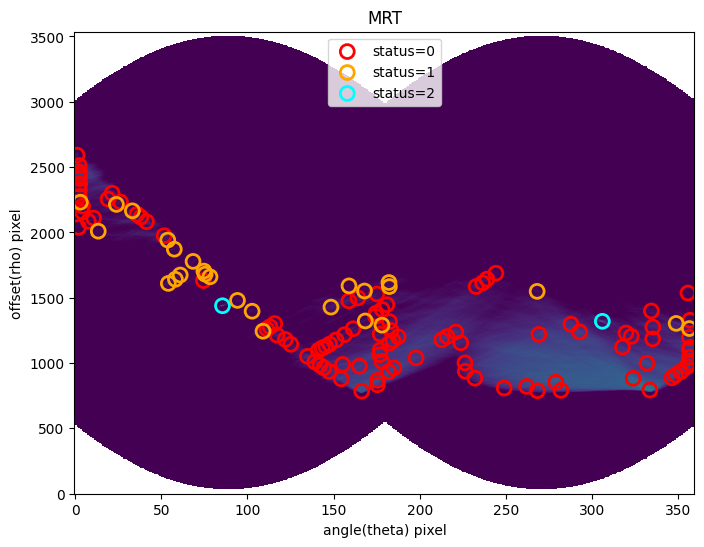

In [43]:
s4.plot_mrt(show_sources=True)

That seems to have worked! Let's make the map to confirm

<Axes: title={'center': 'Segmentation Mask'}>

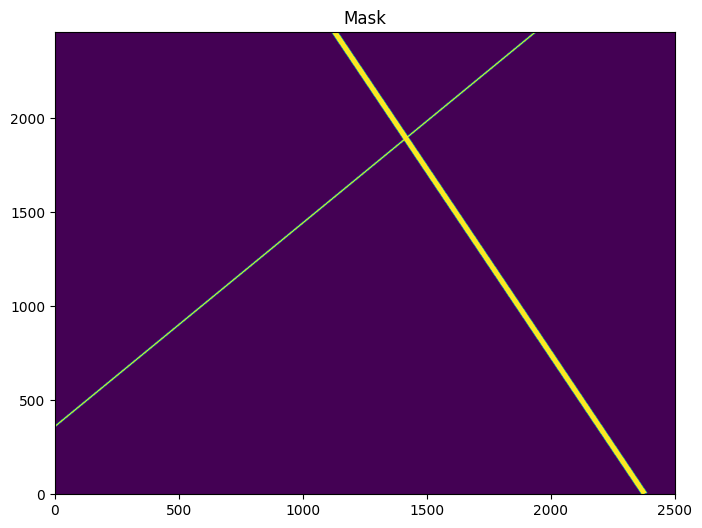

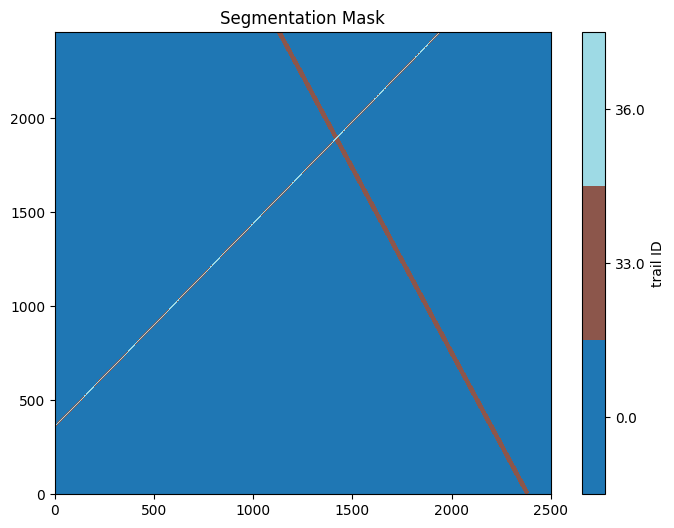

In [44]:
s4.make_mask()
s4.plot_mask()
s4.plot_segment()

Let's make a version plotting the mask on top of the original image

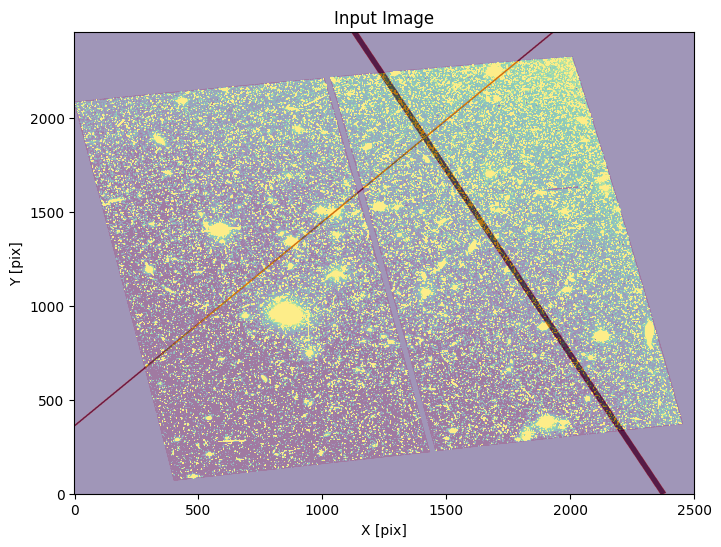

In [45]:
s4.plot_image(overlay_mask=True)

<a id="example5"></a>
## Example 5:  Finding trails in a DRC image using the WFC Wrapper

All of the setup from the last example can be streamlined using the `WfcWrapper` class.

In [46]:
w2 = WfcWrapper('hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits', binsize=2, extension=1, processes=8,
                output_root='example5')

INFO:findsat_mrt:image type is drc


INFO:findsat_mrt:masking bad pixels


INFO:findsat_mrt:Subtracting median background


INFO:findsat_mrt:Rebinning the data by 2


Run full pipeline now

In [47]:
w2.run_all()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 4 processes


INFO:findsat_mrt:Detection threshold: 5


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width15.fits


INFO:findsat_mrt:{no} sources found using kernel: 7


INFO:findsat_mrt:7 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width7.fits


INFO:findsat_mrt:{no} sources found using kernel: 12


INFO:findsat_mrt:12 sources found using kernel


INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/data/rt_line_kernel_width3.fits


INFO:findsat_mrt:{no} sources found using kernel: 22


INFO:findsat_mrt:22 sources found using kernel


INFO:findsat_mrt:Removing duplicate sources


INFO:findsat_mrt:24 final sources found


INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True


INFO:findsat_mrt:Min persistence: 0.5


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.001445285975933075
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 10.327325373371707


INFO:utils_findsat_mrt:breaking into 23.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 23


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 10.327325373371707


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 10.327325373371707, 254.35718476561092


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 23


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 10.327325373371707


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 10.327325373371707, 254.35718476561092


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.014442972051030328
baseline noise: 0.0004601346862464149
snr of feature = 30.388574873261597


INFO:utils_findsat_mrt:width of feature = 116.1316599058976


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 30.388574873261597, 116.1316599058976, 254.35718476561092


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.007990867548343269
baseline noise: 0.0006261102501457829
snr of feature = 11.762716384986003


INFO:utils_findsat_mrt:width of feature = 14.853456431693814


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 11.762716384986003, 14.853456431693814, 254.35718476561092


INFO:utils_findsat_mrt:Checking persistence, step 5 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.02476660003687991
baseline noise: 0.0005402596809257442
snr of feature = 44.84202914132314


INFO:utils_findsat_mrt:width of feature = 86.31043589289249


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 44.84202914132314, 86.31043589289249, 239.5037283339171


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.016999925142115117
baseline noise: 0.0007161101134045455
snr of feature = 22.739261356460563


INFO:utils_findsat_mrt:width of feature = 173.29509085618923


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 22.739261356460563, 173.29509085618923, 239.5037283339171


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.0035057699706710866
baseline noise: 0.0008459028065691915
snr of feature = 3.1444122698797647


INFO:utils_findsat_mrt:width of feature = 3.650281977759505


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.1444122698797647, 3.650281977759505, 253.54082902229987


INFO:utils_findsat_mrt:Checking persistence, step 8 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.020465868320059526
baseline noise: 0.00044508083229419
snr of feature = 44.98236283186416


INFO:utils_findsat_mrt:width of feature = 95.22511347453815


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 44.98236283186416, 95.22511347453815, 257.1911110000594


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.0851863657444322
baseline noise: 0.0006830291822814274
snr of feature = 123.7184863462144


INFO:utils_findsat_mrt:width of feature = 83.95744719952998


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 123.7184863462144, 83.95744719952998, 249.89054704454037


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.04222547805747342
baseline noise: 0.0006089329561774162
snr of feature = 68.34339425894167


INFO:utils_findsat_mrt:width of feature = 103.76409869437464


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 68.34339425894167, 103.76409869437464, 257.1911110000594


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.016909422934487512
baseline noise: 0.0005344663039845204
snr of feature = 30.637958854328925


INFO:utils_findsat_mrt:width of feature = 61.15212865205919


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 30.637958854328925, 61.15212865205919, 257.1911110000594


INFO:utils_findsat_mrt:Checking persistence, step 12 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.010560505084406393
baseline noise: 0.0010704187189802899
snr of feature = 8.865770186144184


INFO:utils_findsat_mrt:width of feature = 212.62797704097477


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.865770186144184, 212.62797704097477, 273.41929234887175


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.008952756287215867
baseline noise: 0.0015975928301144896
snr of feature = 4.603903647072752


INFO:utils_findsat_mrt:width of feature = 220.66225427038103


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.603903647072752, 220.66225427038103, 263.5217179840692


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.008667302342540862
baseline noise: 0.0015645503830499054
snr of feature = 4.539803918391547


INFO:utils_findsat_mrt:width of feature = 219.7985902405287


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.539803918391547, 219.7985902405287, 262.007587850249


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.011325121769075835
baseline noise: 0.0009792619291380457
snr of feature = 10.564956659802244


INFO:utils_findsat_mrt:width of feature = 40.69795920861557


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.564956659802244, 40.69795920861557, 251.58494092609286


INFO:utils_findsat_mrt:Checking persistence, step 16 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.014203319084665458
baseline noise: 0.0012528310690017583
snr of feature = 10.336978652662646


INFO:utils_findsat_mrt:width of feature = 75.61573352689163


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.336978652662646, 75.61573352689163, 256.24651083649803


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.2921076294729461
baseline noise: 0.0023449599631299584
snr of feature = 123.56828008400305


INFO:utils_findsat_mrt:width of feature = 65.10259712946174


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 123.56828008400305, 65.10259712946174, 242.26530916410394


INFO:utils_findsat_mrt:Checking persistence, step 18 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.01618254938028108
baseline noise: 0.0012870647082314198
snr of feature = 11.57322128156076


INFO:utils_findsat_mrt:width of feature = 51.80703244717017


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 11.57322128156076, 51.80703244717017, 223.9988566778716


INFO:utils_findsat_mrt:Checking persistence, step 19 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.01834950212375406
baseline noise: 0.0015078764778037172
snr of feature = 11.169101643180246


INFO:utils_findsat_mrt:width of feature = 27.163020857024833


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 11.169101643180246, 27.163020857024833, 202.25621149978014


INFO:utils_findsat_mrt:Checking persistence, step 20 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.006011940097872996
baseline noise: 0.001835000328984408
snr of feature = 2.276261046340161


INFO:utils_findsat_mrt:width of feature = 10.027901050250534


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.276261046340161, 10.027901050250534, 175.0931906427553


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 23


INFO:utils_findsat_mrt:amplitude of feature: 0.022083671660687976
baseline noise: 0.002795852861890668
snr of feature = 6.898724557970518


INFO:utils_findsat_mrt:width of feature = 41.63828319190969


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.898724557970518, 41.63828319190969, 196.90874706789506


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 23


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 27.163020857024833


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 27.163020857024833, 202.25621149978014


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 23


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 27.163020857024833


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 27.163020857024833, 202.25621149978014


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 23
Number of sections that passed: 7
persistance score: 0.30434782608695654


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.013562453910708427
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 15.908187732079455


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 15.908187732079455


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 15.908187732079455, 250.04436107840428


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 15.908187732079455


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 15.908187732079455, 250.04436107840428


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 9.637538919872532e-07
baseline noise: 7.381070418325294e-07
snr of feature = 0.30571019833993307


INFO:utils_findsat_mrt:width of feature = 47.7194544620028


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.30571019833993307, 47.7194544620028, 250.04436107840428


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02601846236095308
baseline noise: 0.002653607258622106
snr of feature = 8.804940906915988


INFO:utils_findsat_mrt:width of feature = 22.44695488803626


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.804940906915988, 22.44695488803626, 250.40197962715743


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.028755094567565052
baseline noise: 0.0034084520717392423
snr of feature = 7.436408657755335


INFO:utils_findsat_mrt:width of feature = 24.558082909600813


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.436408657755335, 24.558082909600813, 250.30277813653575


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02660610661122767
baseline noise: 0.0037070422246304946
snr of feature = 6.177179270969776


INFO:utils_findsat_mrt:width of feature = 27.3405104015809


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.177179270969776, 27.3405104015809, 250.03320431095955


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.031772653384373954
baseline noise: 0.003154446701409318
snr of feature = 9.072338001519832


INFO:utils_findsat_mrt:width of feature = 24.268191927473936


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.072338001519832, 24.268191927473936, 250.0186323789568


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.027981752971951095
baseline noise: 0.003675542875179142
snr of feature = 6.612957846556829


INFO:utils_findsat_mrt:width of feature = 28.071748183930907


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.612957846556829, 28.071748183930907, 249.0466741352404


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.025632586583871637
baseline noise: 0.003532624672537553
snr of feature = 6.255960924221042


INFO:utils_findsat_mrt:width of feature = 17.944157959469436


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.255960924221042, 17.944157959469436, 250.13983234721675


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.022542196637821837
baseline noise: 0.005427656230087909
snr of feature = 3.1532100933107055


INFO:utils_findsat_mrt:width of feature = 16.782939537729646


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.1532100933107055, 16.782939537729646, 249.2700760802945


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.027514059314094327
baseline noise: 0.006233859973771164
snr of feature = 3.4136473115949286


INFO:utils_findsat_mrt:width of feature = 19.033867469342397


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.4136473115949286, 19.033867469342397, 250.63281071881167


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.04649934162740585
baseline noise: 0.004576420402881871
snr of feature = 9.160635941165765


INFO:utils_findsat_mrt:width of feature = 32.22130857304529


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.160635941165765, 32.22130857304529, 248.7339818930075


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.031009870098384296
baseline noise: 0.006208430778798547
snr of feature = 3.9948000071582195


INFO:utils_findsat_mrt:width of feature = 34.56313499982144


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.9948000071582195, 34.56313499982144, 251.99826418229569


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.028194258547028797
baseline noise: 0.0034036790869796797
snr of feature = 7.283465575495108


INFO:utils_findsat_mrt:width of feature = 24.982029790681963


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.283465575495108, 24.982029790681963, 249.73632021681567


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02874691752746527
baseline noise: 0.0033875469325722954
snr of feature = 7.486057344639244


INFO:utils_findsat_mrt:width of feature = 101.70250702483452


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.486057344639244, 101.70250702483452, 233.25199628526553


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02463201538105292
baseline noise: 0.0035140490149246683
snr of feature = 6.009582187509972


INFO:utils_findsat_mrt:width of feature = 21.30958062574547


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.009582187509972, 21.30958062574547, 250.53564447218352


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.03039438342082919
baseline noise: 0.0036820648998145307
snr of feature = 7.254711486036052


INFO:utils_findsat_mrt:width of feature = 21.05509536548425


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.254711486036052, 21.05509536548425, 250.14669641126238


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.04188893723930315
baseline noise: 0.0034198712820055445
snr of feature = 11.248688264880503


INFO:utils_findsat_mrt:width of feature = 116.13278478292875


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 11.248688264880503, 116.13278478292875, 229.09160104577813


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.021219332682542346
baseline noise: 0.005270877346047044
snr of feature = 3.025768631944364


INFO:utils_findsat_mrt:width of feature = 19.592708709199144


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.025768631944364, 19.592708709199144, 249.75852497828535


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.024848497015740455
baseline noise: 0.005328484294434942
snr of feature = 3.6633330685974195


INFO:utils_findsat_mrt:width of feature = 17.65960273193005


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.6633330685974195, 17.65960273193005, 250.2876684638107


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02622060808756894
baseline noise: 0.003603113414761835
snr of feature = 6.277208644097627


INFO:utils_findsat_mrt:width of feature = 25.88613861233432


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.277208644097627, 25.88613861233432, 250.0649349493309


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02435337900582558
baseline noise: 0.004918500946666793
snr of feature = 3.9513823967706188


INFO:utils_findsat_mrt:width of feature = 23.86307754754486


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.9513823967706188, 23.86307754754486, 250.29311928366945


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.027931309371641184
baseline noise: 0.005341529708844923
snr of feature = 4.229084343646041


INFO:utils_findsat_mrt:width of feature = 30.91477600603031


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.229084343646041, 30.91477600603031, 249.1245196462206


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.01682439457156715
baseline noise: 0.0009200713962160869
snr of feature = 17.285966329091046


INFO:utils_findsat_mrt:width of feature = 17.982306543662872


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 17.285966329091046, 17.982306543662872, 250.09383102499643


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 17.982306543662872


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 17.982306543662872, 250.09383102499643


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 17.982306543662872


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 17.982306543662872, 250.09383102499643


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise


INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 17.982306543662872


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 17.982306543662872, 250.09383102499643


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 19
persistance score: 0.7037037037037037


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.1578369140625
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 4.114656482044154


INFO:utils_findsat_mrt:breaking into 28.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.114656482044154


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.114656482044154, 250.51015522978096


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.114656482044154


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.114656482044154, 250.51015522978096


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.114656482044154


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.114656482044154, 250.51015522978096


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 28


INFO:utils_findsat_mrt:amplitude of feature: -0.0008246047418247662
baseline noise: 0.000754851836393272
snr of feature = -2.092406088279228


INFO:utils_findsat_mrt:width of feature = 4.114317230618781


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.092406088279228, 4.114317230618781, 250.51015522978096


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.17640860959849822
baseline noise: 0.001521586898121806
snr of feature = 114.93725591108262


INFO:utils_findsat_mrt:width of feature = 4.507088830375665


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 114.93725591108262, 4.507088830375665, 250.51015522978096


INFO:utils_findsat_mrt:Checking persistence, step 6 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.22060078106760478
baseline noise: 0.0019096017556405637
snr of feature = 114.52187801252082


INFO:utils_findsat_mrt:width of feature = 4.140672226059337


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 114.52187801252082, 4.140672226059337, 250.35086004119543


INFO:utils_findsat_mrt:Checking persistence, step 7 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.26953057657913526
baseline noise: 0.003187298140468582
snr of feature = 83.56396756768731


INFO:utils_findsat_mrt:width of feature = 4.221708756426835


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 83.56396756768731, 4.221708756426835, 250.3959047271179


INFO:utils_findsat_mrt:Checking persistence, step 8 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.3441065242236005
baseline noise: 0.0030950608315971576
snr of feature = 110.1792442690148


INFO:utils_findsat_mrt:width of feature = 4.17285436908071


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 110.1792442690148, 4.17285436908071, 250.4069135307136


INFO:utils_findsat_mrt:Checking persistence, step 9 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.39306448716414666
baseline noise: 0.003904042258212629
snr of feature = 99.68141202551985


INFO:utils_findsat_mrt:width of feature = 4.152579966544863


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 99.68141202551985, 4.152579966544863, 250.40881611786168


INFO:utils_findsat_mrt:Checking persistence, step 10 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.3937182122207218
baseline noise: 0.005118241819951435
snr of feature = 75.92450377900622


INFO:utils_findsat_mrt:width of feature = 4.363664169562469


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 75.92450377900622, 4.363664169562469, 250.4191841225506


INFO:utils_findsat_mrt:Checking persistence, step 11 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.3551363521759377
baseline noise: 0.021340674091086243
snr of feature = 15.641290273219349


INFO:utils_findsat_mrt:width of feature = 5.112722319105046


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 15.641290273219349, 5.112722319105046, 250.436515979019


INFO:utils_findsat_mrt:Checking persistence, step 12 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.25451559137367086
baseline noise: 0.004094679335058778
snr of feature = 61.15763691053901


INFO:utils_findsat_mrt:width of feature = 4.238078071867392


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 61.15763691053901, 4.238078071867392, 250.43521263847623


INFO:utils_findsat_mrt:Checking persistence, step 13 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.19955504879044123
baseline noise: 0.005720981088070786
snr of feature = 33.88126349631662


INFO:utils_findsat_mrt:width of feature = 4.289477598579083


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 33.88126349631662, 4.289477598579083, 250.43783529311452


INFO:utils_findsat_mrt:Checking persistence, step 14 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.18789623082970314
baseline noise: 0.007004665364159005
snr of feature = 25.824440720768443


INFO:utils_findsat_mrt:width of feature = 109.92672018010603


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 25.824440720768443, 109.92672018010603, 254.7273128916936


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.13556105831628135
baseline noise: 0.00446474761096705
snr of feature = 29.3625356074538


INFO:utils_findsat_mrt:width of feature = 4.179863488613478


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 29.3625356074538, 4.179863488613478, 250.46949478648295


INFO:utils_findsat_mrt:Checking persistence, step 16 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.24372890953545218
baseline noise: 0.003823075068519049
snr of feature = 62.75205957696924


INFO:utils_findsat_mrt:width of feature = 164.33166465641096


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 62.75205957696924, 164.33166465641096, 254.64935827509643


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.1474854075181606
baseline noise: 0.0030674762276796364
snr of feature = 47.08037506120286


INFO:utils_findsat_mrt:width of feature = 4.232205365770312


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 47.08037506120286, 4.232205365770312, 250.5219838923147


INFO:utils_findsat_mrt:Checking persistence, step 18 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.12104138651123775
baseline noise: 0.004902586505356238
snr of feature = 23.689291332033818


INFO:utils_findsat_mrt:width of feature = 3.7706542941070893


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 23.689291332033818, 3.7706542941070893, 250.50950335195603


INFO:utils_findsat_mrt:Checking persistence, step 19 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.12248061865331025
baseline noise: 0.0026409098031705187
snr of feature = 45.378190768297856


INFO:utils_findsat_mrt:width of feature = 4.547715531079518


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 45.378190768297856, 4.547715531079518, 250.52399082466567


INFO:utils_findsat_mrt:Checking persistence, step 20 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.1150454164435184
baseline noise: 0.003590982101827509
snr of feature = 31.037312685287382


INFO:utils_findsat_mrt:width of feature = 4.271760850515989


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 31.037312685287382, 4.271760850515989, 250.516601776601


INFO:utils_findsat_mrt:Checking persistence, step 21 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.12528662635539506
baseline noise: 0.004393874728222493
snr of feature = 27.513927707283266


INFO:utils_findsat_mrt:width of feature = 4.3105334165579166


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 27.513927707283266, 4.3105334165579166, 250.55721830293714


INFO:utils_findsat_mrt:Checking persistence, step 22 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.14640355345316355
baseline noise: 0.003727279529850413
snr of feature = 38.27893045870889


INFO:utils_findsat_mrt:width of feature = 4.130243003464727


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 38.27893045870889, 4.130243003464727, 250.59137927107113


INFO:utils_findsat_mrt:Checking persistence, step 23 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.17492677648708682
baseline noise: 0.0030411377443858687
snr of feature = 56.52017540475194


INFO:utils_findsat_mrt:width of feature = 4.355381984492851


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 56.52017540475194, 4.355381984492851, 250.6025059052442


INFO:utils_findsat_mrt:Checking persistence, step 24 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.20303079512097755
baseline noise: 0.0033891317885887955
snr of feature = 58.90643261633617


INFO:utils_findsat_mrt:width of feature = 4.103453038602595


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 58.90643261633617, 4.103453038602595, 250.62876930683336


INFO:utils_findsat_mrt:Checking persistence, step 25 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.24063986558343486
baseline noise: 0.0028095124481039638
snr of feature = 84.65182394754429


INFO:utils_findsat_mrt:width of feature = 4.012096139787843


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 84.65182394754429, 4.012096139787843, 250.67074057443267


INFO:utils_findsat_mrt:Checking persistence, step 26 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.321342551521568
baseline noise: 0.0018061530130065394
snr of feature = 176.91546408720828


INFO:utils_findsat_mrt:width of feature = 4.356097767293875


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 176.91546408720828, 4.356097767293875, 250.73537119554032


INFO:utils_findsat_mrt:Checking persistence, step 27 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.002818706538450039
baseline noise: 0.0002403243569609619
snr of feature = 10.728759307188774


INFO:utils_findsat_mrt:width of feature = 117.1574307443874


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.728759307188774, 117.1574307443874, 249.86812446630557


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.356097767293875


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.356097767293875, 250.73537119554032


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 28
Number of sections that passed: 20
persistance score: 0.7142857142857143


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0023858314380049706
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 71.76582504061986


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 71.76582504061986


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 71.76582504061986, 252.01954695669573


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0125115610883842
baseline noise: 0.0018075380601473457
snr of feature = 5.9218797458485


INFO:utils_findsat_mrt:width of feature = 87.97335746498183


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.9218797458485, 87.97335746498183, 269.57195515342664


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.024705417248464145
baseline noise: 0.0034505110728071005
snr of feature = 6.159929855946094


INFO:utils_findsat_mrt:width of feature = 97.73364020098734


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.159929855946094, 97.73364020098734, 258.9308507131843


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.021690572762719632
baseline noise: 0.0037387100479739713
snr of feature = 4.8016194046590694


INFO:utils_findsat_mrt:width of feature = 101.01180671654271


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.8016194046590694, 101.01180671654271, 252.01954695669573


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.007171335347249822
baseline noise: 0.003149765641392777
snr of feature = 1.276783787659443


INFO:utils_findsat_mrt:width of feature = 71.76577860706738


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.276783787659443, 71.76577860706738, 252.01954695669573


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.014623887343012804
baseline noise: 0.0034065532962933775
snr of feature = 3.2928690882144274


INFO:utils_findsat_mrt:width of feature = 107.8113692066799


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2928690882144274, 107.8113692066799, 254.0958591619727


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.022720229527130216
baseline noise: 0.004263736957789682
snr of feature = 4.328712758797476


INFO:utils_findsat_mrt:width of feature = 121.24559034031137


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.328712758797476, 121.24559034031137, 252.01954695669573


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.015904208343602528
baseline noise: 0.003600367781792752
snr of feature = 3.417384363906082


INFO:utils_findsat_mrt:width of feature = 54.943792458884275


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.417384363906082, 54.943792458884275, 254.84638521554498


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.004770691376257808
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 253.9076495952817


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.014606677544829895
baseline noise: 0.00808654939914691
snr of feature = 0.8062929964133806


INFO:utils_findsat_mrt:width of feature = 54.94374881870783


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8062929964133806, 54.94374881870783, 254.8463876445207


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.4307702122499368
baseline noise: 0.009320707762455664
snr of feature = 45.21647016818868


INFO:utils_findsat_mrt:width of feature = 151.2298396046176


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 45.21647016818868, 151.2298396046176, 309.7901776744293


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.004811372455538247
baseline noise: 0.004427845978933392
snr of feature = 0.08661694160763043


INFO:utils_findsat_mrt:width of feature = 54.943757858968326


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.08661694160763043, 54.943757858968326, 254.84638539649453


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.018941432086206345
baseline noise: 0.005049073333406638
snr of feature = 2.75146701888492


INFO:utils_findsat_mrt:width of feature = 167.17877207668067


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.75146701888492, 167.17877207668067, 247.80406452759442


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.08751199379066017
baseline noise: 0.004415668487024127
snr of feature = 18.818515372660496


INFO:utils_findsat_mrt:width of feature = 148.2398584413426


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 18.818515372660496, 148.2398584413426, 229.86787007080218


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00718185921482897
baseline noise: 0.003654995190771156
snr of feature = 0.9649435471113963


INFO:utils_findsat_mrt:width of feature = 54.94375912062958


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9649435471113963, 54.94375912062958, 254.84638532673034


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.005390632210834635
baseline noise: 0.005222430197106723
snr of feature = 0.03220761357827182


INFO:utils_findsat_mrt:width of feature = 54.943741982479764


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.03220761357827182, 54.943741982479764, 254.84638435239276


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.004846454614970573
baseline noise: 0.007123955456636413
snr of feature = -1.6803038907908658


INFO:utils_findsat_mrt:width of feature = 54.943745616152


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.6803038907908658, 54.943745616152, 254.8463848561275


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.24239277043613952
baseline noise: 0.004097570307567055
snr of feature = 58.15524377666163


INFO:utils_findsat_mrt:width of feature = 65.35846476656741


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 58.15524377666163, 65.35846476656741, 245.27622268545286


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.01791409375740015
baseline noise: 0.002979801801372375
snr of feature = 5.011840703348004


INFO:utils_findsat_mrt:width of feature = 65.35752782928705


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.011840703348004, 65.35752782928705, 245.27623689254494


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.011097730988936176
baseline noise: 0.0032861972034789666
snr of feature = 2.3770739556309795


INFO:utils_findsat_mrt:width of feature = 20.516253146140855


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.3770739556309795, 20.516253146140855, 246.98332805860318


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.008767915036901719
baseline noise: 0.004497930736681381
snr of feature = 0.9493219327273982


INFO:utils_findsat_mrt:width of feature = 65.35752782928705


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9493219327273982, 65.35752782928705, 245.27623689254494


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.009710684002162996
baseline noise: 0.0033044347776834543
snr of feature = 1.9386823028689306


INFO:utils_findsat_mrt:width of feature = 78.09658139350162


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9386823028689306, 78.09658139350162, 243.66274066825494


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.007010940876246869
baseline noise: 0.003963142775320557
snr of feature = 0.7690356552142615


INFO:utils_findsat_mrt:width of feature = 65.35752782928705


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7690356552142615, 65.35752782928705, 245.27623689254494


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.01228737598845348
baseline noise: 0.0030996254210467226
snr of feature = 2.964148669391193


INFO:utils_findsat_mrt:width of feature = 146.2762566700207


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.964148669391193, 146.2762566700207, 218.92353033146853


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00959047716535459
baseline noise: 0.002566974148577846
snr of feature = 2.7361019668499202


INFO:utils_findsat_mrt:width of feature = 65.35752782928705


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.7361019668499202, 65.35752782928705, 245.27623689254494


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.0009371309684780087
baseline noise: 0.001166431199239897
snr of feature = -1.8034172689213805


INFO:utils_findsat_mrt:width of feature = 65.35752782928705


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.8034172689213805, 65.35752782928705, 245.27623689254494


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


INFO:utils_findsat_mrt:amplitude of feature: -7.570696428988301e-06
baseline noise: 8.071526919797653e-06
snr of feature = -1.937950960730748


INFO:utils_findsat_mrt:width of feature = 65.35752782928705


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.937950960730748, 65.35752782928705, 245.27623689254494


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 3
persistance score: 0.1111111111111111


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.003055546898394823
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 94.83256093683843


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0027511445805430412
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 102.42345736847699


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0022498415783047676
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 61.08202930978325


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 61.08202930978325


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 61.08202930978325, 256.01469041906677


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 61.08202930978325


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 61.08202930978325, 256.01469041906677


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.0004626731541447054
baseline noise: 0.0012290969473464628
snr of feature = -0.6235665907855475


INFO:utils_findsat_mrt:width of feature = 61.08198014699997


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6235665907855475, 61.08198014699997, 256.01469041906677


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.020778030250388962
baseline noise: 0.003566816764070535
snr of feature = 4.82537080673485


INFO:utils_findsat_mrt:width of feature = 47.102563724995434


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.82537080673485, 47.102563724995434, 256.01469041906677


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.012008603587319562
baseline noise: 0.00286218652819179
snr of feature = 3.195604817868421


INFO:utils_findsat_mrt:width of feature = 51.25489435111734


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.195604817868421, 51.25489435111734, 240.87328764016772


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.0068095039097205105
baseline noise: 0.003250534765316895
snr of feature = 1.0948872728197543


INFO:utils_findsat_mrt:width of feature = 51.25486923034978


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.0948872728197543, 51.25486923034978, 240.87328954727286


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.019564009924221984
baseline noise: 0.0030558914018359367
snr of feature = 5.402063212216311


INFO:utils_findsat_mrt:width of feature = 180.69505194560287


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.402063212216311, 180.69505194560287, 255.82664770949955


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.02938673165404218
baseline noise: 0.0032650598433950806
snr of feature = 8.000365403252522


INFO:utils_findsat_mrt:width of feature = 218.10346223273697


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.000365403252522, 218.10346223273697, 189.61839328905037


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.5460549603714424
baseline noise: 0.007018483946972555
snr of feature = 76.80240925207002


INFO:utils_findsat_mrt:width of feature = 149.41736068409665


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 76.80240925207002, 149.41736068409665, 189.61839328905037


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.01871004742764995
baseline noise: 0.013438978619320311
snr of feature = 0.3922224268406663


INFO:utils_findsat_mrt:width of feature = 51.25486030770111


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3922224268406663, 51.25486030770111, 240.87328412524548


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.01650650388440078
baseline noise: 0.008998857005786896
snr of feature = 0.834288940671681


INFO:utils_findsat_mrt:width of feature = 215.85576011924041


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.834288940671681, 215.85576011924041, 189.61839328905037


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.012045051615200602
baseline noise: 0.003657051341315372
snr of feature = 2.2936512208954185


INFO:utils_findsat_mrt:width of feature = 46.18987747018241


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.2936512208954185, 46.18987747018241, 266.29464568231026


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.004462483723181086
baseline noise: 0.002462663135590408
snr of feature = 0.8120560862300938


INFO:utils_findsat_mrt:width of feature = 51.25486124478476


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8120560862300938, 51.25486124478476, 240.8732870647177


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.003227608635344695
baseline noise: 0.0032372930344052803
snr of feature = -1.9970084885867108


INFO:utils_findsat_mrt:width of feature = 51.25485759245896


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.9970084885867108, 51.25485759245896, 240.87328745994904


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.01460600722012366
baseline noise: 0.0047391159567247605
snr of feature = 2.082010939065096


INFO:utils_findsat_mrt:width of feature = 51.25486283778628


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.082010939065096, 51.25486283778628, 240.87328874716815


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.02781262277986295
baseline noise: 0.003935224642925427
snr of feature = 6.067607393103532


INFO:utils_findsat_mrt:width of feature = 51.254886905159736


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.067607393103532, 51.254886905159736, 240.87329230449222


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.01345046890373456
baseline noise: 0.0029718425402585793
snr of feature = 3.525969569896606


INFO:utils_findsat_mrt:width of feature = 69.94260063971001


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.525969569896606, 69.94260063971001, 278.50785935994116


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.005467588778639267
baseline noise: 0.003730385767085184
snr of feature = 0.4656899098431535


INFO:utils_findsat_mrt:width of feature = 69.94259648389198


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4656899098431535, 69.94259648389198, 278.5078591661609


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.022390961766683353
baseline noise: 0.002882714058362349
snr of feature = 6.767319724871885


INFO:utils_findsat_mrt:width of feature = 62.014053078936996


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.767319724871885, 62.014053078936996, 250.29804401674028


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.03214919523197796
baseline noise: 0.004244881233792247
snr of feature = 6.573638333164119


INFO:utils_findsat_mrt:width of feature = 106.39436230877817


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.573638333164119, 106.39436230877817, 255.91371916254352


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.006504858076833236
baseline noise: 0.003081077580834473
snr of feature = 1.111228265492579


INFO:utils_findsat_mrt:width of feature = 60.27377619055591


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.111228265492579, 60.27377619055591, 228.34575434882598


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.2698988149951348
baseline noise: 0.003593887491917267
snr of feature = 74.09940575550661


INFO:utils_findsat_mrt:width of feature = 87.43742578478111


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 74.09940575550661, 87.43742578478111, 235.68816219032652


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.006480397139568235
baseline noise: 0.003278718793689945
snr of feature = 0.9765028803446265


INFO:utils_findsat_mrt:width of feature = 53.79997018299082


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9765028803446265, 53.79997018299082, 256.2615307550192


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.032321070620780545
baseline noise: 0.0008667922285739477
snr of feature = 36.28814075081797


INFO:utils_findsat_mrt:width of feature = 136.75121274008407


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 36.28814075081797, 136.75121274008407, 276.50206897404115


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 62.01405307893697


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 62.01405307893697, 250.29804401674028


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 5
persistance score: 0.2


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0005351726431399584
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.8758138003404383


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.8758138003404383


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.8758138003404383, 248.53880156102164


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.8758138003404383


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.8758138003404383, 248.53880156102164


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.004081404814952065
baseline noise: 0.0038261613650585257
snr of feature = 0.06671005886591386


INFO:utils_findsat_mrt:width of feature = 1.8293870003478787


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.06671005886591386, 1.8293870003478787, 248.53880156102164


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.006815928732957768
baseline noise: 0.0038211152923112415
snr of feature = 0.7837537502918637


INFO:utils_findsat_mrt:width of feature = 11.999034756002231


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7837537502918637, 11.999034756002231, 248.53880156102164


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.03693040036425495
baseline noise: 0.0035391218130809963
snr of feature = 9.434905130350696


INFO:utils_findsat_mrt:width of feature = 5.901621690995171


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.434905130350696, 5.901621690995171, 248.53880156102164


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 53.74195932022107
baseline noise: 0.007321468139087695
snr of feature = 7339.32550565981


INFO:utils_findsat_mrt:width of feature = 3.2114916555613036


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7339.32550565981, 3.2114916555613036, 250.0091868125975


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 107.9704830887292
baseline noise: 0.004859180809804442
snr of feature = 22218.894116900432


INFO:utils_findsat_mrt:width of feature = 6.467841207379024


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 22218.894116900432, 6.467841207379024, 247.07960723847447


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.0401893866704481
baseline noise: 0.003107421704768905
snr of feature = 11.933354558465677


INFO:utils_findsat_mrt:width of feature = 5.369224118078421


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 11.933354558465677, 5.369224118078421, 248.87263308824652


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.0004366325078147149
baseline noise: 0.007680347799479831
snr of feature = -1.05685061656248


INFO:utils_findsat_mrt:width of feature = 3.8362897464758134


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.05685061656248, 3.8362897464758134, 248.93554152584366


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.010343375742317175
baseline noise: 0.004657004336046334
snr of feature = 1.2210363134637772


INFO:utils_findsat_mrt:width of feature = 25.575518892576156


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2210363134637772, 25.575518892576156, 254.24185720632494


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.1912045529134943
baseline noise: 0.00475740945120241
snr of feature = 39.19089693134745


INFO:utils_findsat_mrt:width of feature = 147.5369939925556


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 39.19089693134745, 147.5369939925556, 254.24185720632494


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.026939588050564296
baseline noise: 0.0005256550768037936
snr of feature = 50.24955363195282


INFO:utils_findsat_mrt:width of feature = 59.07196766112193


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 50.24955363195282, 59.07196766112193, 243.5034089701681


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.13568378823655083
baseline noise: 0.0015760130013369022
snr of feature = 85.09306403021603


INFO:utils_findsat_mrt:width of feature = 66.39210904103791


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 85.09306403021603, 66.39210904103791, 260.0581242245492


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.0265980625356728
baseline noise: 0.0037537800151133008
snr of feature = 6.085674287940389


INFO:utils_findsat_mrt:width of feature = 61.05320749432039


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.085674287940389, 61.05320749432039, 249.05160095051204


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.005009772397414111
baseline noise: 0.004356581504910978
snr of feature = 0.1499319803306379


INFO:utils_findsat_mrt:width of feature = 61.053113667589685


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.1499319803306379, 61.053113667589685, 249.05160050142527


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.01618899284191909
baseline noise: 0.0036694364837044505
snr of feature = 3.411847136150895


INFO:utils_findsat_mrt:width of feature = 60.27193899427084


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.411847136150895, 60.27193899427084, 280.03642418779964


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.010513019213737748
baseline noise: 0.004523281590329579
snr of feature = 1.3242017999086675


INFO:utils_findsat_mrt:width of feature = 60.27191720198289


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3242017999086675, 60.27191720198289, 280.0364249207085


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.004875032727708575
baseline noise: 0.007054495536054329
snr of feature = -1.6910533436151616


INFO:utils_findsat_mrt:width of feature = 60.271903729617634


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.6910533436151616, 60.271903729617634, 280.036424958149


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.012157598185263643
baseline noise: 0.0044325523729130305
snr of feature = 1.742798541887005


INFO:utils_findsat_mrt:width of feature = 53.17602172048544


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.742798541887005, 53.17602172048544, 291.5743083507108


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.0083753300295402
baseline noise: 0.004750491757703684
snr of feature = 0.7630448502427689


INFO:utils_findsat_mrt:width of feature = 60.27191200683117


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7630448502427689, 60.27191200683117, 280.03642380928375


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.00790474788785034
baseline noise: 0.0031343824705349983
snr of feature = 1.521947452858586


INFO:utils_findsat_mrt:width of feature = 47.441808754863246


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.521947452858586, 47.441808754863246, 277.61048106898625


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.035985933098033385
baseline noise: 0.0031684881895787686
snr of feature = 10.357445868471897


INFO:utils_findsat_mrt:width of feature = 59.811819881589315


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.357445868471897, 59.811819881589315, 254.74211551929366


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 59.811819881589315


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 59.811819881589315, 254.74211551929366


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 59.811819881589315


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 59.811819881589315, 254.74211551929366


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 59.811819881589315


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 59.811819881589315, 254.74211551929366


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 9
persistance score: 0.36


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0016543269157409668
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 3.9049643969387375


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 3.9049643969387375


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 3.9049643969387375, 252.23378918806023


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.003643309178652739
baseline noise: 0.0023782903643148404
snr of feature = -2.5319025941150533


INFO:utils_findsat_mrt:width of feature = 3.903147967219809


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.5319025941150533, 3.903147967219809, 252.23381198531953


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.004052390349643117
baseline noise: 0.003476024788073276
snr of feature = 0.1658116948841766


INFO:utils_findsat_mrt:width of feature = 0.9786840123869638


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.1658116948841766, 0.9786840123869638, 252.52315369073978


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.004726744758492471
baseline noise: 0.003873065632489249
snr of feature = 0.22041431956177712


INFO:utils_findsat_mrt:width of feature = 3.901791484125738


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.22041431956177712, 3.901791484125738, 252.23402434397136


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.008227506376936007
baseline noise: 0.0031041060397248963
snr of feature = 1.6505236198906326


INFO:utils_findsat_mrt:width of feature = 32.7375925690564


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.6505236198906326, 32.7375925690564, 252.23378918806023


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.014955623707736947
baseline noise: 0.004353221899078277
snr of feature = 2.4355298338693814


INFO:utils_findsat_mrt:width of feature = 104.76963457843306


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.4355298338693814, 104.76963457843306, 267.35392783253076


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.026794580544346486
baseline noise: 0.0032853245128743346
snr of feature = 7.155839838452937


INFO:utils_findsat_mrt:width of feature = 69.71040065255096


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.155839838452937, 69.71040065255096, 252.23378918806023


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.009084777615010788
baseline noise: 0.003101124216208806
snr of feature = 1.9295110358775414


INFO:utils_findsat_mrt:width of feature = 25.942580692477975


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9295110358775414, 25.942580692477975, 245.23241423030137


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.003159815360485839
baseline noise: 0.005897708816815084
snr of feature = -0.46423001565000604


INFO:utils_findsat_mrt:width of feature = 69.71031163203091


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.46423001565000604, 69.71031163203091, 252.23378895135338


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.1344559910321134
baseline noise: 0.008523041865699108
snr of feature = 14.775587302137998


INFO:utils_findsat_mrt:width of feature = 198.67271720767087


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 14.775587302137998, 198.67271720767087, 260.0756742007177


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.2180577478041892
baseline noise: 0.006316101920463996
snr of feature = 33.52410213611154


INFO:utils_findsat_mrt:width of feature = 214.79731503493258


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 33.52410213611154, 214.79731503493258, 276.8909716855173


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.011103677123515236
baseline noise: 0.003490336401005874
snr of feature = 2.1812627345362143


INFO:utils_findsat_mrt:width of feature = 161.06461244658718


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.1812627345362143, 161.06461244658718, 239.3053140982777


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.011634408081622825
baseline noise: 0.011003543391133984
snr of feature = -2.0573328670650906


INFO:utils_findsat_mrt:width of feature = 69.71028168308811


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.0573328670650906, 69.71028168308811, 252.23378991650557


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.005670600905124057
baseline noise: 0.006371889920244094
snr of feature = -1.8899401866796262


INFO:utils_findsat_mrt:width of feature = 69.71028713084112


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.8899401866796262, 69.71028713084112, 252.2337888392062


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.033882793818854035
baseline noise: 0.003516022911135892
snr of feature = 8.636681749581603


INFO:utils_findsat_mrt:width of feature = 88.0910989005377


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.636681749581603, 88.0910989005377, 214.30740101566457


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.07310034946341377
baseline noise: 0.002028560807062974
snr of feature = 35.03557221893249


INFO:utils_findsat_mrt:width of feature = 232.72592119194292


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 35.03557221893249, 232.72592119194292, 276.4616445110781


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.021224000633951592
baseline noise: 0.005204455396750269
snr of feature = 3.0780444861155196


INFO:utils_findsat_mrt:width of feature = 70.99603764218787


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.0780444861155196, 70.99603764218787, 243.22556468072202


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.03611596723492551
baseline noise: 0.003631072596971167
snr of feature = 8.946363304620068


INFO:utils_findsat_mrt:width of feature = 50.39268555623832


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.946363304620068, 50.39268555623832, 266.4445443037486


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.005941611595392048
baseline noise: 0.0034528566826961776
snr of feature = 0.7207814112784187


INFO:utils_findsat_mrt:width of feature = 123.91765760337728


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7207814112784187, 123.91765760337728, 279.43005935585114


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.02953470250674878
baseline noise: 0.0038030527582905483
snr of feature = 6.766051218291399


INFO:utils_findsat_mrt:width of feature = 61.97326743992488


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.766051218291399, 61.97326743992488, 245.70947219732378


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.014490355568528249
baseline noise: 0.00427222641527644
snr of feature = 2.3917574023498083


INFO:utils_findsat_mrt:width of feature = 44.52258404607255


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.3917574023498083, 44.52258404607255, 263.93583703548165


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.006144492159858613
baseline noise: 0.002966371465141567
snr of feature = 1.0713832478716125


INFO:utils_findsat_mrt:width of feature = 61.97311345866626


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.0713832478716125, 61.97311345866626, 245.70947151567873


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.011432385484298278
baseline noise: 0.0020613760077709715
snr of feature = 4.545997159761486


INFO:utils_findsat_mrt:width of feature = 177.36470328270482


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.545997159761486, 177.36470328270482, 218.0138939912074


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.006387150279652094
baseline noise: 0.0007936055756832389
snr of feature = 7.048267899520747


INFO:utils_findsat_mrt:width of feature = 171.31759342813572


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.048267899520747, 171.31759342813572, 250.30764381257566


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 61.97326743992488


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 61.97326743992488, 245.70947219732378


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 4
persistance score: 0.16


INFO:utils_findsat_mrt:amplitude of feature: 0.0005345263993617526
baseline noise: 2.968553382323362e-06
snr of feature = 179.06292308727197


INFO:utils_findsat_mrt:width of feature = 31.42991312341178


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0006076601793488371
baseline noise: 0.00019222550272105453
snr of feature = 2.161183977916994


INFO:utils_findsat_mrt:width of feature = 191.23456405988054


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.161183977916994, 191.23456405988054, 275.1238875210128


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.004275190927357748
baseline noise: 0.001497875829968476
snr of feature = 1.8541691119000983


INFO:utils_findsat_mrt:width of feature = 31.429870750983696


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.8541691119000983, 31.429870750983696, 250.12388951346458


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.021658235017064313
baseline noise: 0.002403776346705317
snr of feature = 8.01008741797035


INFO:utils_findsat_mrt:width of feature = 45.12948212491074


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.01008741797035, 45.12948212491074, 260.40848582875356


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0065461227847391406
baseline noise: 0.003789194995292639
snr of feature = 0.7275761191681781


INFO:utils_findsat_mrt:width of feature = 45.12933642310887


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7275761191681781, 45.12933642310887, 260.40848566123196


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.003236077717923837
baseline noise: 0.003989562803376163
snr of feature = -0.18886407423256749


INFO:utils_findsat_mrt:width of feature = 45.12935112247456


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.18886407423256749, 45.12935112247456, 260.4084851639495


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.01619409921657258
baseline noise: 0.003602530727346293
snr of feature = 3.4952008580094818


INFO:utils_findsat_mrt:width of feature = 129.74652229690344


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.4952008580094818, 129.74652229690344, 254.79289235877212


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.5885896611107216
baseline noise: 0.004235697906333438
snr of feature = 137.95931063228835


INFO:utils_findsat_mrt:width of feature = 95.42048702334594


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 137.95931063228835, 95.42048702334594, 221.83783504126444


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.011041678862930896
baseline noise: 0.004062864053254561
snr of feature = 1.7177081778273997


INFO:utils_findsat_mrt:width of feature = 173.09666592951237


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.7177081778273997, 173.09666592951237, 219.4088803578889


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.005154870753516878
baseline noise: 0.003957138377129865
snr of feature = 0.3026763944645612


INFO:utils_findsat_mrt:width of feature = 45.129358757202226


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3026763944645612, 45.129358757202226, 260.40848689014393


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.13999299208778213
baseline noise: 0.0052274544308951
snr of feature = 25.780337148498308


INFO:utils_findsat_mrt:width of feature = 96.58307474723551


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 25.780337148498308, 96.58307474723551, 282.4086110829011


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0051215663156443415
baseline noise: 0.0058143562105504865
snr of feature = -0.11915160850465913


INFO:utils_findsat_mrt:width of feature = 15.20324274617306


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.11915160850465913, 15.20324274617306, 255.51923946166576


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.013963578291635111
baseline noise: 0.006951431424883584
snr of feature = 1.0087342358942941


INFO:utils_findsat_mrt:width of feature = 45.12937228582541


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.0087342358942941, 45.12937228582541, 260.40847757675823


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.04835456963088759
baseline noise: 0.001066411152522403
snr of feature = 44.343270760544456


INFO:utils_findsat_mrt:width of feature = 197.9400728811869


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 44.343270760544456, 197.9400728811869, 215.27900370384282


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.008815550546391887
baseline noise: 0.0045752995056257
snr of feature = 0.9267701569159476


INFO:utils_findsat_mrt:width of feature = 208.63403299810375


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9267701569159476, 208.63403299810375, 296.13446812231416


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00538808519250678
baseline noise: 0.0016926909715651826
snr of feature = 2.1831475933995046


INFO:utils_findsat_mrt:width of feature = 45.12937866322727


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.1831475933995046, 45.12937866322727, 260.40848693156863


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.06989936089849781
baseline noise: 0.003732167003750048
snr of feature = 17.728894186209665


INFO:utils_findsat_mrt:width of feature = 86.73219726689655


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 17.728894186209665, 86.73219726689655, 250.68906920331287


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.006036149036387913
baseline noise: 0.004855091631464651
snr of feature = 0.24326160957892534


INFO:utils_findsat_mrt:width of feature = 45.12934173820952


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.24326160957892534, 45.12934173820952, 260.4084834201803


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.005364856753627481
baseline noise: 0.003385969259642647
snr of feature = 0.5844375250452464


INFO:utils_findsat_mrt:width of feature = 45.12937994819538


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5844375250452464, 45.12937994819538, 260.4084834202888


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.013377525506569874
baseline noise: 0.0031834325121316274
snr of feature = 3.202233110201001


INFO:utils_findsat_mrt:width of feature = 265.11878637819893


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.202233110201001, 265.11878637819893, 255.14337518614997


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02098954543281528
baseline noise: 0.003978617899608426
snr of feature = 4.275587141675771


INFO:utils_findsat_mrt:width of feature = 28.243209014819712


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.275587141675771, 28.243209014819712, 246.16788723846096


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.048238958569216825
baseline noise: 0.004673200685867429
snr of feature = 9.322466722882204


INFO:utils_findsat_mrt:width of feature = 85.45693692414534


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.322466722882204, 85.45693692414534, 274.4110962532807


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.009991085720926794
baseline noise: 0.003323348894062093
snr of feature = 2.0063306740914584


INFO:utils_findsat_mrt:width of feature = 181.84995045545634


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.0063306740914584, 181.84995045545634, 242.14614461586473


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.0067565035115754995
baseline noise: 0.006137655151855615
snr of feature = -2.1008281411074043


INFO:utils_findsat_mrt:width of feature = 28.242837840967354


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.1008281411074043, 28.242837840967354, 246.16788734431475


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0037764491934324292
baseline noise: 0.0037296120691108297
snr of feature = 0.012558175878266586


INFO:utils_findsat_mrt:width of feature = 28.242915618026586


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.012558175878266586, 28.242915618026586, 246.16787859365843


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0008286861750458514
baseline noise: 0.0047317020631461515
snr of feature = -0.8248650984388374


INFO:utils_findsat_mrt:width of feature = 28.242913856043486


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8248650984388374, 28.242913856043486, 246.16788336977467


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02063210016866158
baseline noise: 0.0005655914515976726
snr of feature = 35.47880481641014


INFO:utils_findsat_mrt:width of feature = 45.40951685958322


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 35.47880481641014, 45.40951685958322, 226.01389119715262


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00014959537099838455
baseline noise: 0.0004920690880992478
snr of feature = -0.6959870582884249


INFO:utils_findsat_mrt:width of feature = 192.92548794037108


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6959870582884249, 192.92548794037108, 271.42340805673587


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 3
persistance score: 0.1111111111111111


INFO:utils_findsat_mrt:amplitude of feature: 0.0010447456388577153
baseline noise: 2.3166395520480938e-05
snr of feature = 44.097461878956395


INFO:utils_findsat_mrt:width of feature = 3.32957729599741


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.0002134019818849918
baseline noise: 0.00020677661293509514
snr of feature = -2.0320411910024676


INFO:utils_findsat_mrt:width of feature = 3.3282600316385924


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.0320411910024676, 3.3282600316385924, 252.17205264749114


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.029305123955015232
baseline noise: 0.0010490448701239747
snr of feature = 26.935052912991218


INFO:utils_findsat_mrt:width of feature = 55.16236134263468


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 26.935052912991218, 55.16236134263468, 256.97027467187604


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.008565679489909623
baseline noise: 0.002575849350558612
snr of feature = 2.3253806120501674


INFO:utils_findsat_mrt:width of feature = 21.774025627403205


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.3253806120501674, 21.774025627403205, 255.6835094070024


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0038981316847992854
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 252.62927374320236


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.013427989985040693
baseline noise: 0.0034920655884285684
snr of feature = 2.8452857327583287


INFO:utils_findsat_mrt:width of feature = 60.31585196991227


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.8452857327583287, 60.31585196991227, 252.17197210301964


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.005045059700393676
baseline noise: 0.005082829525033313
snr of feature = -0.007430865909159015


INFO:utils_findsat_mrt:width of feature = 3.3226554726169866


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.007430865909159015, 3.3226554726169866, 252.17268701489823


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.6735283317929218
baseline noise: 0.004353383741067655
snr of feature = 153.71375184300683


INFO:utils_findsat_mrt:width of feature = 93.44245738594853


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 153.71375184300683, 93.44245738594853, 274.3862973456032


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0010035109955042502
baseline noise: 0.0034490380985336385
snr of feature = -0.709046126242881


INFO:utils_findsat_mrt:width of feature = 0.546377440153833


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.709046126242881, 0.546377440153833, 252.1719721442341


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0027660072774205683
baseline noise: 0.005244944072641389
snr of feature = -0.47263359930784


INFO:utils_findsat_mrt:width of feature = 3.326209771365086


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.47263359930784, 3.326209771365086, 252.1722757901885


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.004091766615211906
baseline noise: 0.007028882544542528
snr of feature = -0.4178638511481604


INFO:utils_findsat_mrt:width of feature = 1.9656946129355788


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.4178638511481604, 1.9656946129355788, 252.4001362953366


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.019123194110237926
baseline noise: 0.009675052848767667
snr of feature = 0.9765467340753274


INFO:utils_findsat_mrt:width of feature = 249.6638968474007


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9765467340753274, 249.6638968474007, 252.17197210301964


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.13772440784821396
baseline noise: 0.005582043881494177
snr of feature = 23.672756211179856


INFO:utils_findsat_mrt:width of feature = 184.84603804871733


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 23.672756211179856, 184.84603804871733, 252.17197210301964


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0266787308574092
baseline noise: 0.0008987073204591468
snr of feature = 28.68567213158909


INFO:utils_findsat_mrt:width of feature = 184.16863407790785


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 28.68567213158909, 184.16863407790785, 261.98315461690936


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.009928786581229806
baseline noise: 0.004167458831234781
snr of feature = 1.3824558281930273


INFO:utils_findsat_mrt:width of feature = 233.81138147690754


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3824558281930273, 233.81138147690754, 277.17197210301964


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.01790224012917245
baseline noise: 0.0026343974486088923
snr of feature = 5.795572983349882


INFO:utils_findsat_mrt:width of feature = 77.16784130620258


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.795572983349882, 77.16784130620258, 252.17197210301964


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.07096386594825163
baseline noise: 0.004031618285275772
snr of feature = 16.601831554198725


INFO:utils_findsat_mrt:width of feature = 134.90105408866725


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 16.601831554198725, 134.90105408866725, 277.17197210301964


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.006749236571810366
baseline noise: 0.0049627161730552965
snr of feature = 0.35998842900886635


INFO:utils_findsat_mrt:width of feature = 14.866561044918427


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.35998842900886635, 14.866561044918427, 252.17197210301964


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0045569468036846215
baseline noise: 0.0031630119769501717
snr of feature = 0.44069856102110144


INFO:utils_findsat_mrt:width of feature = 1.441882844231941


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.44069856102110144, 1.441882844231941, 252.51174139730327


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0038774522059856877
baseline noise: 0.0029915314440986996
snr of feature = 0.29614288816339074


INFO:utils_findsat_mrt:width of feature = 3.3293089270755445


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.29614288816339074, 3.3293089270755445, 252.17197686053265


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.0008106135439249862
baseline noise: 0.004050482121737926
snr of feature = -1.2001276686482891


INFO:utils_findsat_mrt:width of feature = 3.3277703165234698


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.2001276686482891, 3.3277703165234698, 252.17205520581473


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.004513146154866696
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 252.78949446624506


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.013443356204741953
baseline noise: 0.0030867117716253667
snr of feature = 3.355235344070722


INFO:utils_findsat_mrt:width of feature = 175.581722266802


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.355235344070722, 175.581722266802, 252.17197210301964


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.003601821369105543
baseline noise: 0.006355442512804349
snr of feature = -1.5667302256056808


INFO:utils_findsat_mrt:width of feature = 3.1329310567352877


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.5667302256056808, 3.1329310567352877, 252.18437899566396


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0033260123284833843
baseline noise: 0.0032917098798043
snr of feature = 0.01042086026157434


INFO:utils_findsat_mrt:width of feature = 4.93851132034257


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.01042086026157434, 4.93851132034257, 253.14117673791463


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.006275379869086231
baseline noise: 0.005008103830172214
snr of feature = 0.25304508091048095


INFO:utils_findsat_mrt:width of feature = 17.5051781236169


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.25304508091048095, 17.5051781236169, 252.17197210301964


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.012258814274637334
baseline noise: 0.000269286768336094
snr of feature = 44.52327004547522


INFO:utils_findsat_mrt:width of feature = 68.20022841912908


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 44.52327004547522, 68.20022841912908, 252.17197210301964


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


INFO:utils_findsat_mrt:amplitude of feature: -3.6799264924082574e-05
baseline noise: 0.0005005447361095165
snr of feature = -1.0735184335572177


INFO:utils_findsat_mrt:width of feature = 68.20021373783226


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0735184335572177, 68.20021373783226, 252.1719721559223


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 1
persistance score: 0.037037037037037035


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0018789817113429308
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 10.686874767472943


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 10.686874767472943


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 10.686874767472943, 248.79339013306733


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.00025402375480272047
baseline noise: 0.00023973425658192448
snr of feature = -2.0596055750418496


INFO:utils_findsat_mrt:width of feature = 10.686854833176483


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.0596055750418496, 10.686854833176483, 248.79339013306733


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.008639357485439644
baseline noise: 0.0013798098728364878
snr of feature = 5.261266610362511


INFO:utils_findsat_mrt:width of feature = 93.19924260504197


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.261266610362511, 93.19924260504197, 267.01363092809913


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.013987808622328686
baseline noise: 0.0033227215630081634
snr of feature = 3.2097444390330097


INFO:utils_findsat_mrt:width of feature = 86.97388312278088


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2097444390330097, 86.97388312278088, 263.7368418416078


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.002456476302689731
baseline noise: 0.0036082079992868924
snr of feature = -0.3191977005828887


INFO:utils_findsat_mrt:width of feature = 10.68606483164558


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.3191977005828887, 10.68606483164558, 248.79339013306733


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.008817649457495873
baseline noise: 0.004081167770531122
snr of feature = 1.1605701978648006


INFO:utils_findsat_mrt:width of feature = 5.106817599422072


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.1605701978648006, 5.106817599422072, 249.51199852501264


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.000757664920679
baseline noise: 0.00347933629412477
snr of feature = -1.2177613362520887


INFO:utils_findsat_mrt:width of feature = 10.686497198056827


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.2177613362520887, 10.686497198056827, 248.7933959145241


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.006548206954195692
baseline noise: 0.004988362820133712
snr of feature = 0.3126966081469127


INFO:utils_findsat_mrt:width of feature = 7.560568654271719


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3126966081469127, 7.560568654271719, 248.79339013306733


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.03711249669532246
baseline noise: 0.02603765303710487
snr of feature = -2.4253395512427876


INFO:utils_findsat_mrt:width of feature = 10.633567494804709


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.4253395512427876, 10.633567494804709, 248.79339013306733


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.03845374936541589
baseline noise: 0.022891049770178935
snr of feature = -2.6798595849243703


INFO:utils_findsat_mrt:width of feature = 10.647936193357737


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.6798595849243703, 10.647936193357737, 248.79341961442597


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.009748831338685534
baseline noise: 0.00956137414720223
snr of feature = -2.0196056747280573


INFO:utils_findsat_mrt:width of feature = 10.670152865794648


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.0196056747280573, 10.670152865794648, 248.79343590488637


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.012191577652439167
baseline noise: 0.003788770836449912
snr of feature = 2.2178187012922397


INFO:utils_findsat_mrt:width of feature = 103.37103520868979


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.2178187012922397, 103.37103520868979, 248.79339013306733


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.0002898584853832189
baseline noise: 0.002022807283050128
snr of feature = -1.1432951560991764


INFO:utils_findsat_mrt:width of feature = 10.686147040483831


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.1432951560991764, 10.686147040483831, 248.79339013306733


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.0007070169082703552
baseline noise: 0.0024650449691303233
snr of feature = -1.286817042741331


INFO:utils_findsat_mrt:width of feature = 10.684301329008349


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.286817042741331, 10.684301329008349, 248.79339013306733


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.007096199594571537
baseline noise: 0.00542070461073948
snr of feature = 0.30909173329839307


INFO:utils_findsat_mrt:width of feature = 12.29961196561402


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.30909173329839307, 12.29961196561402, 250.46910582483972


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.034687217551504286
baseline noise: 0.003989566149954699
snr of feature = 7.694483622460592


INFO:utils_findsat_mrt:width of feature = 30.77463264738907


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.694483622460592, 30.77463264738907, 248.79339013306733


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.01012749798827819
baseline noise: 0.002869197016955714
snr of feature = 2.5297325099772006


INFO:utils_findsat_mrt:width of feature = 3.1910339300216606


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.5297325099772006, 3.1910339300216606, 252.6851454789842


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.006996705415549675
baseline noise: 0.003207590448349486
snr of feature = 1.1812963744015184


INFO:utils_findsat_mrt:width of feature = 30.77422342100334


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.1812963744015184, 30.77422342100334, 248.79339267322106


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.018422327045733593
baseline noise: 0.003377585674117177
snr of feature = 4.4542886023309425


INFO:utils_findsat_mrt:width of feature = 56.0886156423353


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.4542886023309425, 56.0886156423353, 250.12158481678824


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.06157410489592261
baseline noise: 0.004531415250258649
snr of feature = 12.588272426017019


INFO:utils_findsat_mrt:width of feature = 87.11167484345549


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 12.588272426017019, 87.11167484345549, 258.0104188737808


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.005766477129202833
baseline noise: 0.0029630266218564345
snr of feature = 0.9461442184376812


INFO:utils_findsat_mrt:width of feature = 5.375921258819801


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9461442184376812, 5.375921258819801, 235.23645046698852


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.2367023591942516
baseline noise: 0.0041677496823047736
snr of feature = 55.793804147890846


INFO:utils_findsat_mrt:width of feature = 90.0042662321664


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 55.793804147890846, 90.0042662321664, 250.49756537100842


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.010737655459997612
baseline noise: 0.0031152531900921236
snr of feature = 2.446800245369488


INFO:utils_findsat_mrt:width of feature = 138.9526399779607


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.446800245369488, 138.9526399779607, 243.9455750663328


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.039514549306557005
baseline noise: 0.001492588740321746
snr of feature = 25.47383585249287


INFO:utils_findsat_mrt:width of feature = 193.91743938621403


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 25.47383585249287, 193.91743938621403, 301.4513661139184


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


INFO:utils_findsat_mrt:amplitude of feature: 2.2747569169252435e-07
baseline noise: 1.825785713035666e-07
snr of feature = 0.24590574933522177


INFO:utils_findsat_mrt:width of feature = 158.84314480774515


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.24590574933522177, 158.84314480774515, 249.19660087844215


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 2
persistance score: 0.08


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0009637968614697456
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 79.34321119404876


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.000643246341496706
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.8231955286783545


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.8231955286783545


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.8231955286783545, 245.55536290051438


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.011421606979166152
baseline noise: 0.0023608110755384834
snr of feature = 3.838001268932953


INFO:utils_findsat_mrt:width of feature = 4.451217492919852


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.838001268932953, 4.451217492919852, 246.25260502111703


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.025422191653467843
baseline noise: 0.0030214419114824214
snr of feature = 7.413926991896018


INFO:utils_findsat_mrt:width of feature = 96.21334107621269


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.413926991896018, 96.21334107621269, 250.7038225140369


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0032079883160476413
baseline noise: 0.003502052035729779
snr of feature = -0.08396897495581007


INFO:utils_findsat_mrt:width of feature = 1.2386461375311342


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.08396897495581007, 1.2386461375311342, 245.48413109025805


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.005420840892525267
baseline noise: 0.0033660329914194475
snr of feature = 0.6104538803819959


INFO:utils_findsat_mrt:width of feature = 8.466426631918694


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6104538803819959, 8.466426631918694, 245.77639858512342


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.014578239063273993
baseline noise: 0.0035998361390506997
snr of feature = 3.049695180602962


INFO:utils_findsat_mrt:width of feature = 116.18749590844848


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.049695180602962, 116.18749590844848, 241.80138752819718


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.001349298564990841
baseline noise: 0.004051687858453883
snr of feature = -0.6669786488671585


INFO:utils_findsat_mrt:width of feature = 4.450574527167021


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6669786488671585, 4.450574527167021, 246.25258652529598


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: -5.197230522092922e-06
baseline noise: 0.003985515608329515
snr of feature = -1.0013040296495719


INFO:utils_findsat_mrt:width of feature = 4.450521726113891


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0013040296495719, 4.450521726113891, 246.25259415513978


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.007312119160777631
baseline noise: 0.004883190909472486
snr of feature = -2.49740595777107


INFO:utils_findsat_mrt:width of feature = 4.450309405732753


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.49740595777107, 4.450309405732753, 246.2525911274583


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.026151525324952147
baseline noise: 0.006165998932491073
snr of feature = 3.2412471379372896


INFO:utils_findsat_mrt:width of feature = 141.48457548830055


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2412471379372896, 141.48457548830055, 250.7038225140369


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.44686696388779246
baseline noise: 0.0076725917346855575
snr of feature = 57.24198384851325


INFO:utils_findsat_mrt:width of feature = 240.37593909629987


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 57.24198384851325, 240.37593909629987, 250.7038225140369


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.020811185657241788
baseline noise: 0.005660118408720909
snr of feature = 2.6768110054334997


INFO:utils_findsat_mrt:width of feature = 284.5856087293329


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.6768110054334997, 284.5856087293329, 250.7038225140369


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0011421535707754962
baseline noise: 0.0070710415576992714
snr of feature = -0.8384744932616232


INFO:utils_findsat_mrt:width of feature = 4.450507764412805


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8384744932616232, 4.450507764412805, 246.2526361657313


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.012172628841576313
baseline noise: 0.012573251982085526
snr of feature = -1.9681368717432828


INFO:utils_findsat_mrt:width of feature = 4.450258326816538


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.9681368717432828, 4.450258326816538, 246.25260986139608


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.017112710139313737
baseline noise: 0.004023672450542254
snr of feature = 3.2530077558891564


INFO:utils_findsat_mrt:width of feature = 130.83100147340514


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.2530077558891564, 130.83100147340514, 241.80138752819718


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0019391490519200163
baseline noise: 0.004289144482170047
snr of feature = -0.5478937443163667


INFO:utils_findsat_mrt:width of feature = 3.708072452916838


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5478937443163667, 3.708072452916838, 246.08645518001632


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00833124322749946
baseline noise: 0.006304901720171306
snr of feature = 0.3213914502180532


INFO:utils_findsat_mrt:width of feature = 11.203065231886796


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3213914502180532, 11.203065231886796, 243.46928413393792


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.008015588144798646
baseline noise: 0.0067848689571951976
snr of feature = -2.1813917402632073


INFO:utils_findsat_mrt:width of feature = 4.45031188326476


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.1813917402632073, 4.45031188326476, 246.2526078331516


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.012247488953329121
baseline noise: 0.0034004576486901745
snr of feature = 2.6017178329060338


INFO:utils_findsat_mrt:width of feature = 22.19476845201163


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.6017178329060338, 22.19476845201163, 246.41313687261604


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0021709980063934864
baseline noise: 0.0027914844651968757
snr of feature = -0.22227831339897072


INFO:utils_findsat_mrt:width of feature = 1.228012486542866


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.22227831339897072, 1.228012486542866, 245.51593256213306


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.011745518632940145
baseline noise: 0.003616186326056046
snr of feature = 2.2480402208008643


INFO:utils_findsat_mrt:width of feature = 36.70604866953016


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.2480402208008643, 36.70604866953016, 250.7038225140369


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.008418466299463285
baseline noise: 0.003726982808381676
snr of feature = 1.2587886052307113


INFO:utils_findsat_mrt:width of feature = 85.0300840740087


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2587886052307113, 85.0300840740087, 241.80138752819718


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.0005712378499008255
baseline noise: 0.003784640252877721
snr of feature = -1.150935838476715


INFO:utils_findsat_mrt:width of feature = 4.450424808441028


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.150935838476715, 4.450424808441028, 246.25262030201483


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0012742209786057528
baseline noise: 0.0029706483203668305
snr of feature = -0.57106299999577


INFO:utils_findsat_mrt:width of feature = 4.450584899091552


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.57106299999577, 4.450584899091552, 246.2525892214505


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0012772090904644223
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 246.60345602969716


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0969380509209625
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1910979.0608921056


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 1910979.0608921056, 241.80138752819718


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.451217492919852


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.451217492919852, 246.25260502111703


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 1
persistance score: 0.037037037037037035


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.00017170235514640808
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.3899022725152577


INFO:utils_findsat_mrt:breaking into 24.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.3899022725152577


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.3899022725152577, 244.0307687686001


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.0008198875355430367
baseline noise: 0.0007979408157045094
snr of feature = 0.02750419505630925


INFO:utils_findsat_mrt:width of feature = 1.3899758155816357


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.02750419505630925, 1.3899758155816357, 244.0307687686001


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.003605426031555832
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 244.1774050613111


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 24


INFO:utils_findsat_mrt:amplitude of feature: -0.004681793000236554
baseline noise: 0.003451827300430712
snr of feature = -2.3563230697121984


INFO:utils_findsat_mrt:width of feature = 1.38975813250471


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.3563230697121984, 1.38975813250471, 244.0309445215893


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.02040712905169935
baseline noise: 0.00429113381610363
snr of feature = 3.755649654903822


INFO:utils_findsat_mrt:width of feature = 1.5476158997273046


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.755649654903822, 1.5476158997273046, 244.0307687686001


INFO:utils_findsat_mrt:Checking persistence, step 6 of 24


INFO:utils_findsat_mrt:amplitude of feature: -0.003107607530942371
baseline noise: 0.00435021376729482
snr of feature = -1.7143574309624872


INFO:utils_findsat_mrt:width of feature = 1.5474718618216912


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.7143574309624872, 1.5474718618216912, 244.0309641673022


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.006447254657251584
baseline noise: 0.0037279339541720275
snr of feature = 0.7294444420176206


INFO:utils_findsat_mrt:width of feature = 17.709437946356957


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7294444420176206, 17.709437946356957, 244.87339082680757


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.07108807394324333
baseline noise: 0.004014729163422179
snr of feature = 16.706816836094475


INFO:utils_findsat_mrt:width of feature = 176.85518349874536


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 16.706816836094475, 176.85518349874536, 245.5783846683274


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.006174736550224389
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 244.64694795071665


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.028574249035929023
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 244.33885774516833


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.005880885400892144
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 244.3433861754434


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.06633922703747425
baseline noise: 0.00390605319440877
snr of feature = 15.983697798185135


INFO:utils_findsat_mrt:width of feature = 226.90072977983328


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 15.983697798185135, 226.90072977983328, 242.4831528688728


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.0261279637109946
baseline noise: 0.0038723692019204093
snr of feature = 5.747281147168782


INFO:utils_findsat_mrt:width of feature = 195.47763124419004


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.747281147168782, 195.47763124419004, 242.4831528688728


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.030401914336802137
baseline noise: 0.006614214362666579
snr of feature = 3.5964513198125827


INFO:utils_findsat_mrt:width of feature = 96.27886531307973


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.5964513198125827, 96.27886531307973, 242.4831528688728


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.02931577199697126
baseline noise: 0.005251999701682781
snr of feature = 4.581830476414205


INFO:utils_findsat_mrt:width of feature = 97.91665211680419


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.581830476414205, 97.91665211680419, 245.5783846683274


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.030388416860577458
baseline noise: 0.010145918931830755
snr of feature = 1.9951369673613286


INFO:utils_findsat_mrt:width of feature = 166.0337869937364


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9951369673613286, 166.0337869937364, 245.5783846683274


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.03137571351727837
baseline noise: 0.0038052210725345
snr of feature = 7.245437760172055


INFO:utils_findsat_mrt:width of feature = 49.742207757700214


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.245437760172055, 49.742207757700214, 245.5783846683274


INFO:utils_findsat_mrt:Checking persistence, step 18 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.006917091509525786
baseline noise: 0.0036907272310820714
snr of feature = 0.8741811779728269


INFO:utils_findsat_mrt:width of feature = 110.27613151459016


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8741811779728269, 110.27613151459016, 236.51256864557422


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.0044725611223594705
baseline noise: 0.0040085695934055235
snr of feature = 0.11574989984388871


INFO:utils_findsat_mrt:width of feature = 95.63739152951018


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.11574989984388871, 95.63739152951018, 272.05716502754933


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.005011509139441375
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 249.77134494509448


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.00845704231069803
baseline noise: 0.0041388354441898425
snr of feature = 1.0433386213917126


INFO:utils_findsat_mrt:width of feature = 49.74209289664137


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.0433386213917126, 49.74209289664137, 245.5783826256282


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.0031172765377442723
baseline noise: 0.003623209253099673
snr of feature = -0.13963662598912074


INFO:utils_findsat_mrt:width of feature = 49.74207378273039


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.13963662598912074, 49.74207378273039, 245.57838486132263


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 24


INFO:utils_findsat_mrt:amplitude of feature: -0.0002463426879516341
baseline noise: 0.00023853776695605984
snr of feature = -2.032719854365921


INFO:utils_findsat_mrt:width of feature = 49.74209091506867


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.032719854365921, 49.74209091506867, 245.57838467969353


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 49.74220775770013


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 49.74220775770013, 245.5783846683274


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 24
Number of sections that passed: 2
persistance score: 0.08333333333333333


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0019467957317829132
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 55.31796985175143


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 55.31796985175143


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 55.31796985175143, 239.1520265559495


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.007557704363966063
baseline noise: 0.0019515590600757186
snr of feature = 2.8726495746804774


INFO:utils_findsat_mrt:width of feature = 55.317943912040846


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.8726495746804774, 55.317943912040846, 239.15202668251374


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.026293825839225567
baseline noise: 0.0031635129880957505
snr of feature = 7.311590923814386


INFO:utils_findsat_mrt:width of feature = 96.86362900073956


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.311590923814386, 96.86362900073956, 264.15202655594953


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02156277981477929
baseline noise: 0.0037417618959704885
snr of feature = 4.762734351964056


INFO:utils_findsat_mrt:width of feature = 53.52983981481583


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.762734351964056, 53.52983981481583, 239.1520265559495


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.008521768878414496
baseline noise: 0.003300872543441738
snr of feature = 1.5816715932718381


INFO:utils_findsat_mrt:width of feature = 53.52976923786025


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5816715932718381, 53.52976923786025, 239.1520259190113


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.020196454538074116
baseline noise: 0.0035218349542325365
snr of feature = 4.734639697922825


INFO:utils_findsat_mrt:width of feature = 101.78278781428847


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.734639697922825, 101.78278781428847, 249.09490302021925


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.030398077264015756
baseline noise: 0.004118214928043632
snr of feature = 6.381372219554466


INFO:utils_findsat_mrt:width of feature = 84.2940820155224


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.381372219554466, 84.2940820155224, 234.2840768045062


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.015287760694567554
baseline noise: 0.0036862504131936545
snr of feature = 3.1472387876445715


INFO:utils_findsat_mrt:width of feature = 49.11310632198021


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.1472387876445715, 49.11310632198021, 248.40834312720196


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.002988407464365829
baseline noise: 0.005253652494522697
snr of feature = -0.4311752694946127


INFO:utils_findsat_mrt:width of feature = 49.11308503023986


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.4311752694946127, 49.11308503023986, 248.40834247885


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.032556654540247316
baseline noise: 0.006998025438669453
snr of feature = 3.652262959826761


INFO:utils_findsat_mrt:width of feature = 163.7590982874706


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.652262959826761, 163.7590982874706, 292.23354771328195


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.4319870787982433
baseline noise: 0.0061145193450909225
snr of feature = 69.64939276789869


INFO:utils_findsat_mrt:width of feature = 155.03898617315053


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 69.64939276789869, 155.03898617315053, 297.52144944918217


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02480205489045691
baseline noise: 0.004043321847684099
snr of feature = 5.134078815581508


INFO:utils_findsat_mrt:width of feature = 163.45277806711613


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.134078815581508, 163.45277806711613, 297.52144944918217


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02812626295612253
baseline noise: 0.005659853455535479
snr of feature = 3.969433074033805


INFO:utils_findsat_mrt:width of feature = 157.1329561186092


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.969433074033805, 157.1329561186092, 218.34723688780159


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.06833535781136463
baseline noise: 0.006394190852271018
snr of feature = 9.687100117928765


INFO:utils_findsat_mrt:width of feature = 129.64646866788746


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.687100117928765, 129.64646866788746, 200.62444868585203


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.01798341502874971
baseline noise: 0.003344739223670563
snr of feature = 4.3766269434346095


INFO:utils_findsat_mrt:width of feature = 130.541842406559


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.3766269434346095, 130.541842406559, 278.63728935829727


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0014378889701778755
baseline noise: 0.005141636766549536
snr of feature = -0.7203441169682591


INFO:utils_findsat_mrt:width of feature = 49.11308592298471


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7203441169682591, 49.11308592298471, 248.4083427174244


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0038217786035097054
baseline noise: 0.006116358286348899
snr of feature = -0.3751545569134605


INFO:utils_findsat_mrt:width of feature = 49.11308793399104


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.3751545569134605, 49.11308793399104, 248.40834303953196


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.014958206901001945
baseline noise: 0.005132370382747842
snr of feature = 1.9144831306959196


INFO:utils_findsat_mrt:width of feature = 49.11309776910667


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9144831306959196, 49.11309776910667, 248.40834091085392


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.014241448550884517
baseline noise: 0.0030856798539795863
snr of feature = 3.6153357525141145


INFO:utils_findsat_mrt:width of feature = 51.08955587238074


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.6153357525141145, 51.08955587238074, 230.94949963564812


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.009545619995691663
baseline noise: 0.003337820410314918
snr of feature = 1.859836307008216


INFO:utils_findsat_mrt:width of feature = 60.55793942125882


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.859836307008216, 60.55793942125882, 239.70794988921674


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0063863103152775914
baseline noise: 0.004214966623626932
snr of feature = 0.5151508625191064


INFO:utils_findsat_mrt:width of feature = 51.089516144657665


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5151508625191064, 51.089516144657665, 230.94949691506466


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.011550615556718456
baseline noise: 0.0033814044206639748
snr of feature = 2.4159225338832346


INFO:utils_findsat_mrt:width of feature = 229.0731169640859


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.4159225338832346, 229.0731169640859, 240.31994148931523


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.004506645191103874
baseline noise: 0.0034264729653179006
snr of feature = 0.315243177669653


INFO:utils_findsat_mrt:width of feature = 51.08950226238912


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.315243177669653, 51.08950226238912, 230.94950045919782


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.004869484508148721
baseline noise: 0.0030512695646237055
snr of feature = 0.5958880082590294


INFO:utils_findsat_mrt:width of feature = 51.08950812338898


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5958880082590294, 51.08950812338898, 230.9494991031642


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.012033900598125794
baseline noise: 0.0011697402200412017
snr of feature = 9.287669340549755


INFO:utils_findsat_mrt:width of feature = 51.089528474614326


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.287669340549755, 51.089528474614326, 230.94949943345358


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


INFO:utils_findsat_mrt:amplitude of feature: -9.08756344404993e-05
baseline noise: 0.0001269010862516242
snr of feature = -1.716113920887231


INFO:utils_findsat_mrt:width of feature = 51.089528474614326


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.716113920887231, 51.089528474614326, 230.94949943345358


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 51.089528474614326


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 51.089528474614326, 230.94949943345358


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 4
persistance score: 0.14814814814814814


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 30.01276999907782


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0004466096870601177
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.8829179633473814


INFO:utils_findsat_mrt:breaking into 26.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 26


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.8829179633473814


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.8829179633473814, 254.46550986209184


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.0013023165892306664
baseline noise: 0.0009510255374222613
snr of feature = 0.36938130258896473


INFO:utils_findsat_mrt:width of feature = 2.1876945104849597


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.36938130258896473, 2.1876945104849597, 254.46550986209184


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.002878561904681694
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 254.53481863246787


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.004649169241800728
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 254.53339174082544


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0039788421170173505
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 254.53649015597617


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.007178595846789367
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 254.52924568888895


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.004663847756186755
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 254.46550986209184


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.003487403458777372
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 254.535813375566


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.005861133782490482
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 254.53271652375685


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.03247225100456125
baseline noise: 0.019979632697376896
snr of feature = 0.6252676661480615


INFO:utils_findsat_mrt:width of feature = 268.3635321414795


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6252676661480615, 268.3635321414795, 254.46550986209184


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.05002930774105886
baseline noise: 0.006875565920488439
snr of feature = 6.276391255587699


INFO:utils_findsat_mrt:width of feature = 181.45068307764495


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.276391255587699, 181.45068307764495, 263.06785289469576


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.026010732611942287
baseline noise: 0.005383670021592354
snr of feature = 3.8314128666171423


INFO:utils_findsat_mrt:width of feature = 1.6987126381304734


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.8314128666171423, 1.6987126381304734, 254.46550986209184


INFO:utils_findsat_mrt:Checking persistence, step 13 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0013406461726529536
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 254.5352492199518


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.007634106013976056
baseline noise: 0.00338522602425772
snr of feature = 1.2551244611945787


INFO:utils_findsat_mrt:width of feature = 236.0657158690084


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2551244611945787, 236.0657158690084, 252.76679722396136


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.06974025384086525
baseline noise: 0.0017416826875364863
snr of feature = 39.04188268042613


INFO:utils_findsat_mrt:width of feature = 229.67143124805054


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 39.04188268042613, 229.67143124805054, 256.1642225002223


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 26


INFO:utils_findsat_mrt:amplitude of feature: -0.0015830166509020749
baseline noise: 0.004932598013044357
snr of feature = -1.320929588568895


INFO:utils_findsat_mrt:width of feature = 1.6496895400068183


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.320929588568895, 1.6496895400068183, 254.4642770313734


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.014305978697364451
baseline noise: 0.0034280455711210387
snr of feature = 3.173217187625109


INFO:utils_findsat_mrt:width of feature = 16.98475111740666


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.173217187625109, 16.98475111740666, 255.19407973788213


INFO:utils_findsat_mrt:Checking persistence, step 18 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.012329771349274463
baseline noise: 0.003558362798389962
snr of feature = 2.4650124362960586


INFO:utils_findsat_mrt:width of feature = 226.2246513023665


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.4650124362960586, 226.2246513023665, 239.21695215771854


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.0021519834336245275
baseline noise: 0.0035720563395620123
snr of feature = -0.39755053418659325


INFO:utils_findsat_mrt:width of feature = 7.922922680239736


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.39755053418659325, 7.922922680239736, 255.59881951004004


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.06685702815509588
baseline noise: 0.003295141772419241
snr of feature = 19.289575615440214


INFO:utils_findsat_mrt:width of feature = 94.00124856070852


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 19.289575615440214, 94.00124856070852, 238.39060984583574


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.004719994371446266
baseline noise: 0.0039052131305997483
snr of feature = 0.20863937859427065


INFO:utils_findsat_mrt:width of feature = 16.984606892335734


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.20863937859427065, 16.984606892335734, 255.1940792607828


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.02204715173256711
baseline noise: 0.0034168093755051446
snr of feature = 5.452555384160884


INFO:utils_findsat_mrt:width of feature = 136.30585367495843


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.452555384160884, 136.30585367495843, 254.13984709091588


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.11394312773295694
baseline noise: 0.0030118495628802026
snr of feature = 36.83161321775787


INFO:utils_findsat_mrt:width of feature = 116.94289759427224


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 36.83161321775787, 116.94289759427224, 255.8132037339147


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 26


INFO:utils_findsat_mrt:amplitude of feature: -0.000294041419360673
baseline noise: 0.003856061665992274
snr of feature = -1.0762543353375051


INFO:utils_findsat_mrt:width of feature = 16.9845868825322


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0762543353375051, 16.9845868825322, 255.19407693168534


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.0005631010490909764
baseline noise: 0.00025672551586213943
snr of feature = 1.1933972834759417


INFO:utils_findsat_mrt:width of feature = 16.98462742796923


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.1933972834759417, 16.98462742796923, 255.19407981782192


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 26


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.007051463526992881
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1959378.733403748


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 1959378.733403748, 238.20932862047547


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 26
Number of sections that passed: 2
persistance score: 0.07692307692307693


INFO:utils_findsat_mrt:amplitude of feature: 0.0005053938085250204
baseline noise: 2.4352353469233477e-05
snr of feature = 19.753386696835275


INFO:utils_findsat_mrt:width of feature = 31.340477960307368


INFO:utils_findsat_mrt:breaking into 27.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.0002264229680868841
baseline noise: 0.00023516267563643728
snr of feature = -1.96283548175364


INFO:utils_findsat_mrt:width of feature = 31.340332774905164


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.96283548175364, 31.340332774905164, 250.1337439970357


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02160931947416798
baseline noise: 0.001097798456004646
snr of feature = 18.684231978985885


INFO:utils_findsat_mrt:width of feature = 61.753946806029035


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 18.684231978985885, 61.753946806029035, 255.20663781107237


INFO:utils_findsat_mrt:Checking persistence, step 3 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00876772159458803
baseline noise: 0.00258447173627181
snr of feature = 2.3924617830163513


INFO:utils_findsat_mrt:width of feature = 29.31349625327846


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.3924617830163513, 29.31349625327846, 259.4547066373954


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.006703605282810579
baseline noise: 0.0039262090422438715
snr of feature = 0.7073989720576354


INFO:utils_findsat_mrt:width of feature = 61.75390951989206


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7073989720576354, 61.75390951989206, 255.20663750221155


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.011038901484913077
baseline noise: 0.0035896935088063995
snr of feature = 2.075165458508349


INFO:utils_findsat_mrt:width of feature = 30.04972653159433


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.075165458508349, 30.04972653159433, 255.99200456612638


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02798278265097513
baseline noise: 0.004872462086965016
snr of feature = 4.743047796274427


INFO:utils_findsat_mrt:width of feature = 61.753917081563486


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.743047796274427, 61.753917081563486, 255.20663950250253


INFO:utils_findsat_mrt:Checking persistence, step 7 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.6513772996213278
baseline noise: 0.004198953965213168
snr of feature = 154.1284689038641


INFO:utils_findsat_mrt:width of feature = 92.8347008675394


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 154.1284689038641, 92.8347008675394, 292.6526585215481


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.004702364914495152
baseline noise: 0.0031867586237178257
snr of feature = 0.47559494449854106


INFO:utils_findsat_mrt:width of feature = 33.81827769705916


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.47559494449854106, 33.81827769705916, 253.65066298580442


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0033537126222714705
baseline noise: 0.004599815667074183
snr of feature = -0.2709028219809784


INFO:utils_findsat_mrt:width of feature = 61.753917081563486


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.2709028219809784, 61.753917081563486, 255.20663950250253


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02166762613943949
baseline noise: 0.005332535048636868
snr of feature = 3.0632880875257045


INFO:utils_findsat_mrt:width of feature = 70.5409171293046


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.0632880875257045, 70.5409171293046, 238.4787009378898


INFO:utils_findsat_mrt:Checking persistence, step 11 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.02370560895170118
baseline noise: 0.013311247972613785
snr of feature = 0.780870508946455


INFO:utils_findsat_mrt:width of feature = 261.6434693631878


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.780870508946455, 261.6434693631878, 232.57829409198717


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.13321707751743933
baseline noise: 0.00520287567761148
snr of feature = 24.604509077679175


INFO:utils_findsat_mrt:width of feature = 151.27456891778857


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 24.604509077679175, 151.27456891778857, 276.69939479537237


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.009194493443448916
baseline noise: 0.0033276429856915536
snr of feature = 1.7630648729398204


INFO:utils_findsat_mrt:width of feature = 70.54083958759946


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.7630648729398204, 70.54083958759946, 238.47870301785278


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0020670350369908232
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 216.69379323193152


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 27


INFO:utils_findsat_mrt:amplitude of feature: -0.0016152999668591931
baseline noise: 0.0035642777534186584
snr of feature = -1.4531913836708956


INFO:utils_findsat_mrt:width of feature = 70.54082840977475


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.4531913836708956, 70.54082840977475, 238.47870043318434


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.013242004078726376
baseline noise: 0.00477716845647454
snr of feature = 1.7719357605611268


INFO:utils_findsat_mrt:width of feature = 70.5408569080654


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.7719357605611268, 70.5408569080654, 238.47870649654755


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.024492036123847268
baseline noise: 0.004367877037502767
snr of feature = 4.607308977234859


INFO:utils_findsat_mrt:width of feature = 70.54086282356243


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.607308977234859, 70.54086282356243, 238.47870574749567


INFO:utils_findsat_mrt:Checking persistence, step 18 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.004653266829199802
baseline noise: 0.0033831213855892873
snr of feature = 0.3754359654432782


INFO:utils_findsat_mrt:width of feature = 70.54086282356243


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3754359654432782, 70.54086282356243, 238.47870574749567


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.009220767868088401
baseline noise: 0.0032364943983100463
snr of feature = 1.848998556247487


INFO:utils_findsat_mrt:width of feature = 116.75104757331755


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.848998556247487, 116.75104757331755, 250.23655939985767


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.01169379587498615
baseline noise: 0.0037664442643970003
snr of feature = 2.104730895801083


INFO:utils_findsat_mrt:width of feature = 67.58624138438489


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.104730895801083, 67.58624138438489, 254.1453514034449


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.015294099289790832
baseline noise: 0.004874967199738295
snr of feature = 2.137272244746974


INFO:utils_findsat_mrt:width of feature = 38.33757647045064


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.137272244746974, 38.33757647045064, 226.49330982576893


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.008426157179842013
baseline noise: 0.0029424494754330265
snr of feature = 1.8636539897093647


INFO:utils_findsat_mrt:width of feature = 70.54086282356243


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.8636539897093647, 70.54086282356243, 238.47870574749567


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 27


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.22199461906805343
baseline noise: 0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1287.6149794538915


INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 1287.6149794538915, 309.01956857105813


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.00251434474933329
baseline noise: 0.0030372658543191006
snr of feature = -0.17216836788988962


INFO:utils_findsat_mrt:width of feature = 70.54086282356243


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.17216836788988962, 70.54086282356243, 238.47870574749567


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.009896658375862665
baseline noise: 0.0032563405689245554
snr of feature = 2.0391963513604945


INFO:utils_findsat_mrt:width of feature = 52.592423514725596


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.0391963513604945, 52.592423514725596, 237.73136275410508


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.005753708723993239
baseline noise: 0.0013944835769951586
snr of feature = 3.126049828705308


INFO:utils_findsat_mrt:width of feature = 70.54086282356243


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.126049828705308, 70.54086282356243, 238.47870574749567


INFO:utils_findsat_mrt:Checking persistence, step 27 of 27


INFO:utils_findsat_mrt:amplitude of feature: 0.0160275684612975
baseline noise: 2.319082087022524e-05
snr of feature = 690.1169100476016


INFO:utils_findsat_mrt:width of feature = 209.58512449802663


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 690.1169100476016, 209.58512449802663, 185.02661900487453


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 5
persistance score: 0.18518518518518517


INFO:utils_findsat_mrt:amplitude of feature: 0.0015496513796524794
baseline noise: 1.3982819459250816e-05
snr of feature = 109.82538712371446


INFO:utils_findsat_mrt:width of feature = 1.6995604462393885


INFO:utils_findsat_mrt:breaking into 28.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.0018694676468217447
baseline noise: 0.0010378622986978565
snr of feature = 0.801267518019735


INFO:utils_findsat_mrt:width of feature = 2.3878870806760233


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.801267518019735, 2.3878870806760233, 317.390919766127


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0012343422844690735
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 317.6088903776134


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.0191443075913028
baseline noise: 0.0025782934151083446
snr of feature = 6.4251857756454465


INFO:utils_findsat_mrt:width of feature = 74.7338712391504


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.4251857756454465, 74.7338712391504, 317.390919766127


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.004781662396840954
baseline noise: 0.003964403064394054
snr of feature = 0.20614940488444383


INFO:utils_findsat_mrt:width of feature = 7.320337165337492


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.20614940488444383, 7.320337165337492, 317.390919766127


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0035457417499391727
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 317.5986495861084


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.04362233527291142
baseline noise: 0.0039817914888061745
snr of feature = 9.955454446960587


INFO:utils_findsat_mrt:width of feature = 150.08989808291244


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.955454446960587, 150.08989808291244, 317.390919766127


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.5866741556183005
baseline noise: 0.0037234641669183556
snr of feature = 156.56138083204615


INFO:utils_findsat_mrt:width of feature = 175.69652963856208


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 156.56138083204615, 175.69652963856208, 317.390919766127


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0031484542310378006
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 317.6084440820706


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.004802776443516483
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 317.60803684324424


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 28


INFO:utils_findsat_mrt:amplitude of feature: -0.0013221332583817809
baseline noise: 0.00561062343854823
snr of feature = -1.2356481900563778


INFO:utils_findsat_mrt:width of feature = 1.558998343972121


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.2356481900563778, 1.558998343972121, 317.3917932656725


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.042253846825395125
baseline noise: 0.02631898136066081
snr of feature = 0.6054514514209994


INFO:utils_findsat_mrt:width of feature = 381.62161123859255


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6054514514209994, 381.62161123859255, 317.390919766127


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.09543751247310939
baseline noise: 0.009054587565026355
snr of feature = 9.540238502053914


INFO:utils_findsat_mrt:width of feature = 175.7885257188641


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.540238502053914, 175.7885257188641, 317.390919766127


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.029639772480934932
baseline noise: 0.0031900982100017093
snr of feature = 8.291178681586436


INFO:utils_findsat_mrt:width of feature = 185.3664530483568


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.291178681586436, 185.3664530483568, 325.8144590608914


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0023014009354161446
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 317.60829489814546


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.003047916440500114
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 317.6063515002938


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.005692605833383054
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 317.6036680655459


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.01129289384281291
baseline noise: 0.004133169251376121
snr of feature = 1.7322601993743636


INFO:utils_findsat_mrt:width of feature = 3.1762217373637895


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.7322601993743636, 3.1762217373637895, 317.390919766127


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.005087910814021272
baseline noise: 0.0038009917964131204
snr of feature = 0.33857453173736846


INFO:utils_findsat_mrt:width of feature = 1.4464803633568408


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.33857453173736846, 1.4464803633568408, 317.5452069459612


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.0029991649129275854
baseline noise: 0.0030839611031489773
snr of feature = -0.027495868911838087


INFO:utils_findsat_mrt:width of feature = 3.9393508993717887


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.027495868911838087, 3.9393508993717887, 317.390919766127


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.015594785391209516
baseline noise: 0.003385782426903658
snr of feature = 3.6059620568918684


INFO:utils_findsat_mrt:width of feature = 74.78935554496297


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.6059620568918684, 74.78935554496297, 317.390919766127


INFO:utils_findsat_mrt:Checking persistence, step 21 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.016236626422990806
baseline noise: 0.004690222305045166
snr of feature = 2.461803165603778


INFO:utils_findsat_mrt:width of feature = 74.78934807318535


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.461803165603778, 74.78934807318535, 317.3909191166757


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.006889992237387615
baseline noise: 0.002748001608214536
snr of feature = 1.5072737282218194


INFO:utils_findsat_mrt:width of feature = 74.78934463808662


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5072737282218194, 74.78934463808662, 317.3909193065867


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.017290732451551223
baseline noise: 0.007761904290490818
snr of feature = 1.2276405124879293


INFO:utils_findsat_mrt:width of feature = 19.00481471133287


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2276405124879293, 19.00481471133287, 310.1310797124194


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.003927082778551472
baseline noise: 0.006632690378765696
snr of feature = -0.40792008155184256


INFO:utils_findsat_mrt:width of feature = 74.78934308536873


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.40792008155184256, 74.78934308536873, 317.39091972003166


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.013014108714609288
baseline noise: 0.002929430461509703
snr of feature = 3.4425388776432584


INFO:utils_findsat_mrt:width of feature = 29.771034273475607


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.4425388776432584, 29.771034273475607, 310.221053178382


INFO:utils_findsat_mrt:Checking persistence, step 26 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.005275562331934113
baseline noise: 0.001576780087385391
snr of feature = 2.345781935058569


INFO:utils_findsat_mrt:width of feature = 29.77099493335504


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.345781935058569, 29.77099493335504, 310.22105475365174


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 27 of 28


INFO:utils_findsat_mrt:amplitude of feature: 0.015717480507195253
baseline noise: 4.968776286321298e-07
snr of feature = 31631.49782539899


INFO:utils_findsat_mrt:width of feature = 236.84363428059922


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 31631.49782539899, 236.84363428059922, 280.4500189049064


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 28 of 28


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 29.771034273475607


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 29.771034273475607, 310.221053178382


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 28
Number of sections that passed: 2
persistance score: 0.07142857142857142


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0023114061914384365
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 58.133309476672025


INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 58.133309476672025


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 58.133309476672025, 246.20971431572275


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 58.133309476672025


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 58.133309476672025, 246.20971431572275


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.003112817039163444
baseline noise: 0.0012955867534968195
snr of feature = 1.4026311096203143


INFO:utils_findsat_mrt:width of feature = 58.133260966351145


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.4026311096203143, 58.133260966351145, 246.20971431572275


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.019890148718330256
baseline noise: 0.003734742258527396
snr of feature = 4.325708533946574


INFO:utils_findsat_mrt:width of feature = 73.29054255784163


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.325708533946574, 73.29054255784163, 246.20971431572275


INFO:utils_findsat_mrt:Checking persistence, step 5 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.011330050347311056
baseline noise: 0.0033355375263337157
snr of feature = 2.396768963881086


INFO:utils_findsat_mrt:width of feature = 51.29114001693904


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.396768963881086, 51.29114001693904, 225.11019836397065


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.008245962525467583
baseline noise: 0.002922484358789422
snr of feature = 1.821559164437513


INFO:utils_findsat_mrt:width of feature = 51.92029585997233


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.821559164437513, 51.92029585997233, 246.5838091249698


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.0187627187293861
baseline noise: 0.0032874121907612228
snr of feature = 4.707443314262781


INFO:utils_findsat_mrt:width of feature = 154.81896460177492


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.707443314262781, 154.81896460177492, 240.8845647608363


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.0030351485469398524
baseline noise: 0.005247716106514729
snr of feature = -0.4216248582555952


INFO:utils_findsat_mrt:width of feature = 73.29052170524207


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.4216248582555952, 73.29052170524207, 246.20971430578868


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.05172510963005421
baseline noise: 0.0344640353139589
snr of feature = 0.5008431008978247


INFO:utils_findsat_mrt:width of feature = 73.29052160738763


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5008431008978247, 73.29052160738763, 246.20971247599226


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.001524904499421359
baseline noise: 0.011871838131944375
snr of feature = -0.8715527888374596


INFO:utils_findsat_mrt:width of feature = 73.29052044129182


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8715527888374596, 73.29052044129182, 246.20971394488893


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.018554579617595723
baseline noise: 0.008825247515904407
snr of feature = 1.1024429721837958


INFO:utils_findsat_mrt:width of feature = 73.29052298168057


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.1024429721837958, 73.29052298168057, 246.20971413467507


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.010120029706290307
baseline noise: 0.0035468947021065453
snr of feature = 1.8532083854307528


INFO:utils_findsat_mrt:width of feature = 54.75582898797526


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.8532083854307528, 54.75582898797526, 253.8636795444054


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.002642731139805673
baseline noise: 0.0023015347614173762
snr of feature = 0.1482473278735857


INFO:utils_findsat_mrt:width of feature = 73.2905240599008


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.1482473278735857, 73.2905240599008, 246.20971453099173


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.00960696277723579
baseline noise: 0.0023813162418449265
snr of feature = 3.0343078371618497


INFO:utils_findsat_mrt:width of feature = 73.29052789543874


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.0343078371618497, 73.29052789543874, 246.20971461266626


INFO:utils_findsat_mrt:Checking persistence, step 15 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.02020106555346163
baseline noise: 0.00534641207383636
snr of feature = 2.7784340740062334


INFO:utils_findsat_mrt:width of feature = 16.51059648080377


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.7784340740062334, 16.51059648080377, 257.1954799972412


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.03343196432329603
baseline noise: 0.003973485943531747
snr of feature = 7.4137618198243205


INFO:utils_findsat_mrt:width of feature = 26.563564450005856


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.4137618198243205, 26.563564450005856, 249.62972599282733


INFO:utils_findsat_mrt:Checking persistence, step 17 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.011495432421327138
baseline noise: 0.0027505339196383103
snr of feature = 3.179345813280777


INFO:utils_findsat_mrt:width of feature = 6.022756476718655


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.179345813280777, 6.022756476718655, 251.62900459299095


INFO:utils_findsat_mrt:Checking persistence, step 18 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.001238146791000293
baseline noise: 0.0034998407365823972
snr of feature = -0.6462276760029526


INFO:utils_findsat_mrt:width of feature = 6.022331434211935


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6462276760029526, 6.022331434211935, 251.62900690248048


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.020798352750958125
baseline noise: 0.003212177070383684
snr of feature = 5.4748462787805865


INFO:utils_findsat_mrt:width of feature = 66.13360561508136


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.4748462787805865, 66.13360561508136, 245.6062481162723


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.03745651067252023
baseline noise: 0.003890287684182284
snr of feature = 8.628210999617467


INFO:utils_findsat_mrt:width of feature = 98.09656528635054


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.628210999617467, 98.09656528635054, 246.94164318309734


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 25


INFO:utils_findsat_mrt:amplitude of feature: -0.0010651608134578687
baseline noise: 0.0030428238192066483
snr of feature = -1.3500566831160097


INFO:utils_findsat_mrt:width of feature = 6.022168582356585


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.3500566831160097, 6.022168582356585, 251.62900806015202


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.30968835093564384
baseline noise: 0.003900957104053264
snr of feature = 78.38778681105316


INFO:utils_findsat_mrt:width of feature = 156.9451553572668


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 78.38778681105316, 156.9451553572668, 245.6062481162723


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.007146366920241566
baseline noise: 0.0030154108988689346
snr of feature = 1.3699479639481742


INFO:utils_findsat_mrt:width of feature = 39.62248091381997


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3699479639481742, 39.62248091381997, 250.55611022343797


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 25


INFO:utils_findsat_mrt:amplitude of feature: 0.03600523887092951
baseline noise: 0.0007891618249294573
snr of feature = 44.6246586359496


INFO:utils_findsat_mrt:width of feature = 191.57504258379265


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 44.6246586359496, 191.57504258379265, 257.6517610697096


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 25


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 6.022756476718655


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 6.022756476718655, 251.62900459299095


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 25
Number of sections that passed: 4
persistance score: 0.16


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0009701370727270842
baseline noise: 0.0
snr of feature = inf


INFO:utils_findsat_mrt:width of feature = 1.6327572863335718


INFO:utils_findsat_mrt:breaking into 24.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.6327572863335718


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.6327572863335718, 247.28983504091218


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.6327572863335718


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.6327572863335718, 247.28983504091218


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 1.6327572863335718


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.6327572863335718, 247.28983504091218


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0038211000862698836
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 247.70946323422982


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.00253315167340224
baseline noise: 0.004382383875162045
snr of feature = -0.4219694701417335


INFO:utils_findsat_mrt:width of feature = 1.6314521877201855


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.4219694701417335, 1.6314521877201855, 247.28983504487536


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.033138372726885565
baseline noise: 0.0046965174073498985
snr of feature = 6.055945896213454


INFO:utils_findsat_mrt:width of feature = 90.75344066855658


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.055945896213454, 90.75344066855658, 247.28983504091218


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 24


INFO:utils_findsat_mrt:amplitude of feature: -0.0021265788909792657
baseline noise: 0.003367083563230589
snr of feature = -1.6315788874983828


INFO:utils_findsat_mrt:width of feature = 1.6278471787870217


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.6315788874983828, 1.6278471787870217, 247.29045891047429


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.021427910607430812
baseline noise: 0.004191389572764534
snr of feature = 4.112364344910442


INFO:utils_findsat_mrt:width of feature = 262.7138954946148


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.112364344910442, 262.7138954946148, 247.28983504091218


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0036465159781888935
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 247.7067702950711


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.011466130404034503
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 247.7047140683177


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.00637049265540531
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 247.70626140650705


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.19431449136147586
baseline noise: 0.002934390863517451
snr of feature = 65.2197029636847


INFO:utils_findsat_mrt:width of feature = 400.93416552437213


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 65.2197029636847, 400.93416552437213, 247.28983504091218


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.008103078921780995
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 247.69961657432393


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 14 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.0056588296426241785
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 247.61929595179274


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.028389508882900677
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 247.63840891093253


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 16 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.025345644221293137
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 247.67663094140767


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.1761097480222857
baseline noise: 0.005949653452401817
snr of feature = 28.600000980089344


INFO:utils_findsat_mrt:width of feature = 5.19401074422143


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 28.600000980089344, 5.19401074422143, 248.8879933979869


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.05783356100129017
baseline noise: 0.0037955051657576535
snr of feature = 14.237381712203653


INFO:utils_findsat_mrt:width of feature = 112.99168609229426


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 14.237381712203653, 112.99168609229426, 251.92736292245044


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.021226342180460687
baseline noise: 0.004558973869634756
snr of feature = 3.6559473222339927


INFO:utils_findsat_mrt:width of feature = 4.13925319256748


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.6559473222339927, 4.13925319256748, 247.98450094055437


INFO:utils_findsat_mrt:Checking persistence, step 20 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.042135954889401875
baseline noise: 0.004003138981973093
snr of feature = 9.525728704186443


INFO:utils_findsat_mrt:width of feature = 103.57578215366027


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.525728704186443, 103.57578215366027, 243.8452477479869


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.008022009260123864
baseline noise: 0.003704467607857023
snr of feature = 1.165495857787908


INFO:utils_findsat_mrt:width of feature = 2.07462670900577


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.165495857787908, 2.07462670900577, 246.55667725507968


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.0034256371266108733
baseline noise: 0.0036159643979405084
snr of feature = -0.052635272470613094


INFO:utils_findsat_mrt:width of feature = 2.0822723815674635


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.052635272470613094, 2.0822723815674635, 246.60131098669328


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 24


INFO:utils_findsat_mrt:amplitude of feature: 0.0028177720009986947
baseline noise: 0.0030390523369114293
snr of feature = -0.07281228204764005


INFO:utils_findsat_mrt:width of feature = 1.222974989434988


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.07281228204764005, 1.222974989434988, 247.5018209320007


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 24


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 4.13925319256748


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.13925319256748, 247.98450094055437


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 24
Number of sections that passed: 1
persistance score: 0.041666666666666664


INFO:utils_findsat_mrt:amplitude of feature: 0.00045921255475371353
baseline noise: 1.233023825977049e-05
snr of feature = 36.24279653637943


INFO:utils_findsat_mrt:width of feature = 61.7228518097852


INFO:utils_findsat_mrt:breaking into 26.0 sections for persistence check
Section size for persistence check: 100


INFO:utils_findsat_mrt:Checking persistence, step 1 of 26


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 61.7228518097852


INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 61.7228518097852, 254.68979488048467


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 2 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.003745438626460703
baseline noise: 0.0005131265230104603
snr of feature = 6.299249714254881


INFO:utils_findsat_mrt:width of feature = 210.5052696390301


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.299249714254881, 210.5052696390301, 279.68979488048467


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 3 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.00403921973644748
baseline noise: 0.001590719774817967
snr of feature = 1.5392402863098287


INFO:utils_findsat_mrt:width of feature = 61.722672960735


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5392402863098287, 61.722672960735, 254.6897972358815


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 4 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.004020237899398468
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 264.42881189014724


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 5 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.04158168352505435
baseline noise: 0.003305058175240516
snr of feature = 11.581225902938414


INFO:utils_findsat_mrt:width of feature = 40.90868908306629


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 11.581225902938414, 40.90868908306629, 279.68979488048467


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 6 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.02686157090835736
baseline noise: 0.0067897488536685395
snr of feature = 2.956195065130266


INFO:utils_findsat_mrt:width of feature = 231.36170680197515


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.956195065130266, 231.36170680197515, 263.10085806260787


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 7 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.005244674135399094
baseline noise: 0.003102366970005424
snr of feature = 0.6905395738499384


INFO:utils_findsat_mrt:width of feature = 61.7228303559894


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6905395738499384, 61.7228303559894, 254.6897951538028


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 8 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.013736081419061895
baseline noise: 0.003574641100481205
snr of feature = 2.842646305726411


INFO:utils_findsat_mrt:width of feature = 52.02045798994314


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.842646305726411, 52.02045798994314, 260.6244615979819


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 9 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.018635366196925372
baseline noise: 0.007650762748740611
snr of feature = 1.4357527228239997


INFO:utils_findsat_mrt:width of feature = 61.72254209834887


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.4357527228239997, 61.72254209834887, 254.68979488048467


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 10 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.06137346914763005
baseline noise: 0.018185813088400914
snr of feature = 2.3747992926846164


INFO:utils_findsat_mrt:width of feature = 62.32437707387547


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.3747992926846164, 62.32437707387547, 254.68979488048467


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 11 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.01209675140515322
snr of feature = -1.0


INFO:utils_findsat_mrt:width of feature = 0.0


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 254.68979488048467


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 12 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.01598864649069412
baseline noise: 0.0070216994677291256
snr of feature = 1.2770337244104493


INFO:utils_findsat_mrt:width of feature = 276.786722387679


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.2770337244104493, 276.786722387679, 254.68979488048467


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 13 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.014548271620037646
baseline noise: 0.0030715503985622766
snr of feature = 3.7364587039976174


INFO:utils_findsat_mrt:width of feature = 65.65146748097743


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7364587039976174, 65.65146748097743, 254.68979488048467


INFO:utils_findsat_mrt:Checking persistence, step 14 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.02693158340200017
baseline noise: 0.001963009334700549
snr of feature = 12.719539141217838


INFO:utils_findsat_mrt:width of feature = 93.08169255663014


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 12.719539141217838, 93.08169255663014, 215.8958714131983


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 15 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.04354276426006891
baseline noise: 0.003715919557136363
snr of feature = 10.717897438453893


INFO:utils_findsat_mrt:width of feature = 29.299323535568476


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.717897438453893, 29.299323535568476, 204.75963638537021


INFO:utils_findsat_mrt:Checking persistence, step 16 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.000830355099214973
baseline noise: 0.0028822196811194864
snr of feature = -0.7119042990878288


INFO:utils_findsat_mrt:width of feature = 29.29881816523448


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7119042990878288, 29.29881816523448, 204.7596383958332


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 17 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.010240151788335114
baseline noise: 0.0037727512312360515
snr of feature = 1.7142398638831464


INFO:utils_findsat_mrt:width of feature = 19.765274600049224


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.7142398638831464, 19.765274600049224, 199.04765040517321


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 18 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.0017866777153164697
baseline noise: 0.0031464539285172236
snr of feature = -0.4321614884860408


INFO:utils_findsat_mrt:width of feature = 29.298833157294155


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.4321614884860408, 29.298833157294155, 204.75963707176547


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 19 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.0037114478317476583
baseline noise: 0.003964730363428962
snr of feature = -0.06388392361246178


INFO:utils_findsat_mrt:width of feature = 29.29887299051785


INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.06388392361246178, 29.29887299051785, 204.7596318422782


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 20 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.007003364020596202
baseline noise: 0.0035256020833246892
snr of feature = 0.9864306450579179


INFO:utils_findsat_mrt:width of feature = 24.276670089473328


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.9864306450579179, 24.276670089473328, 206.64163934133595


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 21 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.004617513694016674
baseline noise: 0.0030659690695923774
snr of feature = 0.5060535801917192


INFO:utils_findsat_mrt:width of feature = 29.298852035948073


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.5060535801917192, 29.298852035948073, 204.75963968964908


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 22 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.018803018778714292
baseline noise: 0.010448811476688349
snr of feature = 0.7995366095621939


INFO:utils_findsat_mrt:width of feature = 215.42424057466457


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.7995366095621939, 215.42424057466457, 216.9844735055121


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 23 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.013924215399331497
baseline noise: 0.003944513732198206
snr of feature = 2.5300207692702803


INFO:utils_findsat_mrt:width of feature = 68.02370688085045


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.5300207692702803, 68.02370688085045, 223.36073602410175


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 24 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.0051204617747756
baseline noise: 0.002481179139478217
snr of feature = 1.0637211127981732


INFO:utils_findsat_mrt:width of feature = 29.298875851630555


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.0637211127981732, 29.298875851630555, 204.75963318662176


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 25 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.00607943787536959
baseline noise: 0.0018189851734757836
snr of feature = 2.342214089492977


INFO:utils_findsat_mrt:width of feature = 29.298905165597432


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.342214089492977, 29.298905165597432, 204.7596282574381


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Checking persistence, step 26 of 26


INFO:utils_findsat_mrt:amplitude of feature: 0.013900370640128494
baseline noise: 4.591165252343185e-06
snr of feature = 3026.634571209169


INFO:utils_findsat_mrt:width of feature = 341.86482056620173


INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3026.634571209169, 341.86482056620173, 234.0589599209387


INFO:utils_findsat_mrt:fit failed, will not update guesses


INFO:utils_findsat_mrt:Number of sections analyzed: 26
Number of sections that passed: 2
persistance score: 0.07692307692307693


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan


INFO:utils_findsat_mrt:width of feature = 30.0


INFO:findsat_mrt:Wrote diagnostic plot to ./example5_diagnostic.png


INFO:findsat_mrt:wrote catalog ./example5_catalog.fits


Let's plot the final mask to ensure it looks the same as the earlier examples.

<Axes: title={'center': 'Mask'}>

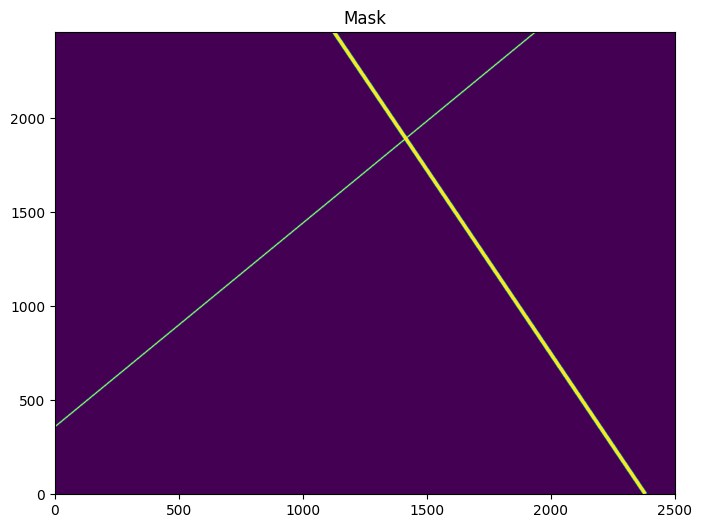

In [48]:
w2.plot_mask()

And there you go!

<a id="example6"></a>
## Example 6:  Create a new kernel for trail detection

We include a function called create_mrt_line_kernel that can be used to generate kernels for detecting trails of s specified size in the MRT. Note that kernels with widths of 1, 3, 7, and 15 pixels (convolved with a simple Gaussian HST/ACS psf model) are included already, but perhaps you want to generate a kernel with a new width, or convolved with a different PSF.

Let's generate a kernel for a trail that has an inherent width of 5 pixels and is convolved with a Gaussian PSF with `sigma=3`. 

INFO:utils_findsat_mrt:calculated endpoints: [(0, 511.5), (2047, 511.5)]


INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 processes


INFO:utils_findsat_mrt:Inteprolating onto new grid to center kernel


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:286: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=13,24 m=175 fp=0.000000 s=0.000000
  self.tck = _fitpack_py.bisplrep(x, y, z, kx=kx, ky=ky, s=0.0)


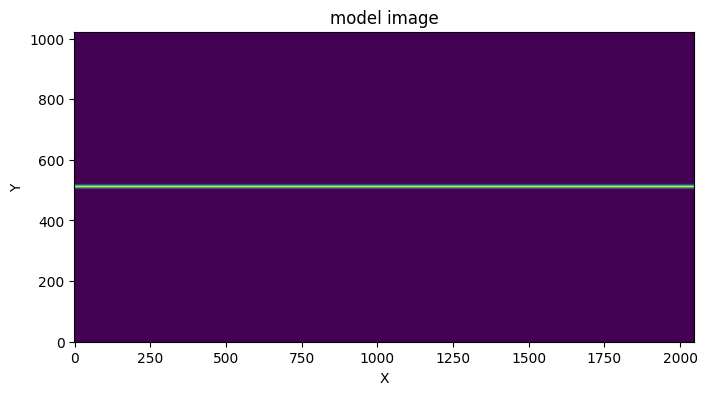

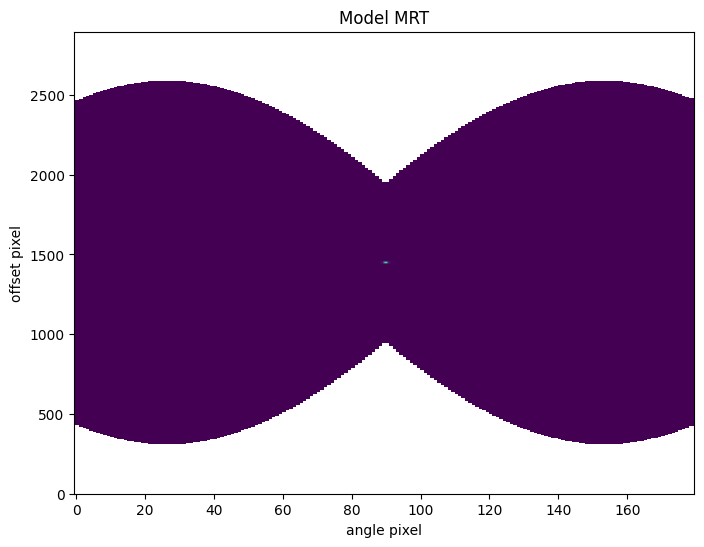

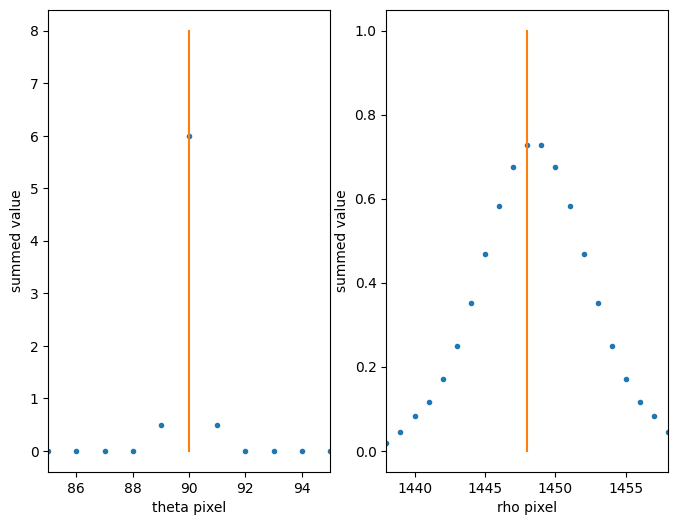

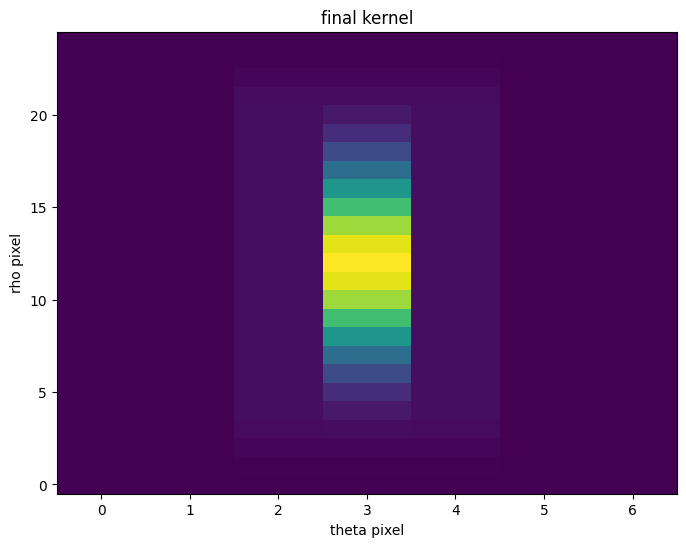

In [49]:
out = create_mrt_line_kernel(5, 3, processes=8, plot=True)

The first plot show the model streak. The second plot shows the resulting MRT. The kernsl is created by taking a cutout around the signal in the MRT. The third double-plot shows 1D slices of the signal in the MRT, with orange lines showing the location of the maximum values. These serve as first guesses of the center, after which the center is redetermined using a Guassian fit and the cutout extracted with the kernel perfectly centered. The 4th plot above shows the final kernel.

The kernel can be saved by defining the `outfile` keyword in `create_mrt_line_kernel`. By adding this file path into the `kernels` keyword in `TrailFinder` or `WfcWrapper`, it will be used for source detection when running `find_mrt_sources`.

### For more help:

More details may be found on the [ACS website](http://www.stsci.edu/hst/instrumentation/acs) and in the [ACS Instrument](https://hst-docs.stsci.edu/display/ACSIHB) and [Data Handbooks](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/other-documents/_documents/acs_dhb.pdf).

Please visit the [HST Help Desk](http://hsthelp.stsci.edu). Through the help desk portal, you can explore the *HST* Knowledge Base and request additional help from experts.

---
[Top of Page](#titleFindsat)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 
<br></br>
<br></br>